![image.png](attachment:image.png)

# Home Credit Risk Assessment Model

### Objective
The goal of this project is to classify loan applicants for Home Credit who are at risk of loan payment difficulties by estimating their probability of default.

### Purpose
The model is designed to assist financial institutions in minimizing risk by identifying borrowers who may miss or delay payments.

### Methodology
We employed several machine learning models to predict loan defaults using applicant data. The baseline model was set using AutoML, focusing on basic applicant features, excluding detailed loan history from Home Credit or external sources. We also explored deep learning techniques. Final model selection is based on the highest ROC-AUC score to ensure as accurate as possible prediction of default risk.

## Features

### Applicant Demographics
- **Age**: Age of the applicant.
- **Income**: Total annual income of the applicant.
- **Employment Status**: Employment status of the applicant (e.g., employed, self-employed, unemployed).
- **Gender**: Gender of the applicant.
- **Family Status**: Marital status of the applicant (e.g., single, married).
- **Number of Children**: Number of dependents.

### Credit History
- **Past Defaults**: Record of past defaults or late payments.
- **Credit Score**: External credit score indicating the creditworthiness of the applicant.
- **Number of Past Loans**: Number of previous loans taken by the applicant.
- **Previous Loan Status**: Status of previous loans (e.g., closed, active, overdue).

### Current Financial Status
- **Current Debt**: Total current debt of the applicant.
- **Credit Utilization**: Ratio of credit used to the total credit limit available.
- **Savings/Assets**: Ownership of assets like cars, real estate.
- **Current Employment Duration**: Duration of current employment in days.
- **Mobile/Phone Verification**: Availability and verification of contact information (e.g., mobile phone, work phone).

### Loan Details
- **Loan Amount**: Amount of the loan applied for.
- **Loan Duration**: Duration of the loan in terms of months or years.
- **Interest Rate**: Interest rate applied to the loan.
- **Loan Purpose**: Purpose for which the loan is taken (e.g., consumer goods, car loan, mortgage).
- **Annuity**: Monthly payment amount for the loan.
- **Goods Price**: Price of the goods for which the loan is given (if applicable).

## Usage
By integrating these features into a predictive model, the bank can assess the risk profile of each loan applicant. The resulting predictions can help the bank indicate whether to approve or reject loan applications.

### Data description

**application_{train|test}.csv**
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**bureau.csv**
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv**
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

**HomeCredit_columns_description.csv**
This file contains descriptions for the columns in the various data files.

**Missing data explanation** XNA - Not available, XAP - Not applicable, 365243 denotes infinity in DAYS variables in the datasets, therefore the can be considered missing values.


### Dependencies

![image.png](attachment:image.png)

### Libraries

In [ ]:
%load_ext nb_black
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import numpy as np

from scipy import stats
from scipy.stats import levene, mannwhitneyu
from flaml import AutoML

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
    log_loss,
    precision_recall_curve
)

import dask
import shap
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from optuna_integration.dask import DaskStorage
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
from joblib import Parallel, delayed
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

from tensorflow.keras.layers import Dense, Dropout
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.neural_network import MLPClassifier

from preprocessing.preprocessing import (
    preprocessing_pipeline,
    clean_application_train,
    clean_previous_application,
    clean_installments_payments,
    merge_bureau_and_balance,
    find_and_transform_skewed_features,
    merge_datasets,
    encode_bureau_status,
    aggregate_bureau_balance,
    feature_engineering,
    get_feature_names,
)

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

### Data Part

In [ ]:
application_train = pd.read_csv("application_train.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
pos_cash_balance = pd.read_csv("POS_CASH_balance.csv")
credit_card_balance = pd.read_csv("credit_card_balance.csv")
previous_application = pd.read_csv("previous_application.csv")
installments_payments = pd.read_csv("installments_payments.csv")

<IPython.core.display.Javascript object>

In [ ]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


<IPython.core.display.Javascript object>

**Application set**

This is the main dataset, split into two files: Train (which includes the TARGET variable) and Test (without the TARGET). It contains statistical information for all loan applications, where each row represents a single loan.

Shape: 307,511 data points (rows) and 122 features (including the TARGET variable).

From the "HomeCredit_columns_description.csv" file, we can determine that some variables are actually of boolean type, and we will convert them accordingly to ensure proper data formatting.

In [ ]:
bool_columns = [
    "TARGET",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "LIVE_REGION_NOT_WORK_REGION",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

for column in bool_columns:
    if column in application_train.columns:
        application_train[column] = application_train[column].astype(bool)

In [ ]:
application_train.describe().T

count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

                                 25%       50%       75%          max  
SK_ID_CURR                  189145.5  278202.0  367142.5     456255.0  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[106 rows x 8 columns]

<IPython.core.display.Javascript object>

In [ ]:
application_train.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

<IPython.core.display.Javascript object>

application_train data sample has a lot missing values in some of the features. Each feature will have to be evaluated visually to make proper assumptions about the data it contains and it's distributions.

In [ ]:
bureau.describe().T

count          mean           std          min  \
SK_ID_CURR              1716428.0  2.782149e+05  1.029386e+05   100001.000   
SK_ID_BUREAU            1716428.0  5.924434e+06  5.322657e+05  5000000.000   
DAYS_CREDIT             1716428.0 -1.142108e+03  7.951649e+02    -2922.000   
CREDIT_DAY_OVERDUE      1716428.0  8.181666e-01  3.654443e+01        0.000   
DAYS_CREDIT_ENDDATE     1610875.0  5.105174e+02  4.994220e+03   -42060.000   
DAYS_ENDDATE_FACT       1082775.0 -1.017437e+03  7.140106e+02   -42023.000   
AMT_CREDIT_MAX_OVERDUE   591940.0  3.825418e+03  2.060316e+05        0.000   
CNT_CREDIT_PROLONG      1716428.0  6.410406e-03  9.622391e-02        0.000   
AMT_CREDIT_SUM          1716415.0  3.549946e+05  1.149811e+06        0.000   
AMT_CREDIT_SUM_DEBT     1458759.0  1.370851e+05  6.774011e+05 -4705600.320   
AMT_CREDIT_SUM_LIMIT    1124648.0  6.229515e+03  4.503203e+04  -586406.115   
AMT_CREDIT_SUM_OVERDUE  1716428.0  3.791276e+01  5.937650e+03        0.000   
DAYS_CREDIT_UPDATE      1716428.0 -5.937483e+02  7.207473e+02   -41947.000   
AMT_ANNUITY              489637.0  1.571276e+04  3.258269e+05        0.000   

                               25%        50%         75%           max  
SK_ID_CURR               188866.75   278055.0   367426.00  4.562550e+05  
SK_ID_BUREAU            5463953.75  5926303.5  6385681.25  6.843457e+06  
DAYS_CREDIT               -1666.00     -987.0     -474.00  0.000000e+00  
CREDIT_DAY_OVERDUE            0.00        0.0        0.00  2.792000e+03  
DAYS_CREDIT_ENDDATE       -1138.00     -330.0      474.00  3.119900e+04  
DAYS_ENDDATE_FACT         -1489.00     -897.0     -425.00  0.000000e+00  
AMT_CREDIT_MAX_OVERDUE        0.00        0.0        0.00  1.159872e+08  
CNT_CREDIT_PROLONG            0.00        0.0        0.00  9.000000e+00  
AMT_CREDIT_SUM            51300.00   125518.5   315000.00  5.850000e+08  
AMT_CREDIT_SUM_DEBT           0.00        0.0    40153.50  1.701000e+08  
AMT_CREDIT_SUM_LIMIT          0.00        0.0        0.00  4.705600e+06  
AMT_CREDIT_SUM_OVERDUE        0.00        0.0        0.00  3.756681e+06  
DAYS_CREDIT_UPDATE         -908.00     -395.0      -33.00  3.720000e+02  
AMT_ANNUITY                   0.00        0.0    13500.00  1.184534e+08

<IPython.core.display.Javascript object>

In [ ]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

<IPython.core.display.Javascript object>

In [ ]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


<IPython.core.display.Javascript object>

In [ ]:
bureau.isna().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

<IPython.core.display.Javascript object>

First key take away that we can clearly see is that there is missing data present in this data set as well.

In [ ]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

<IPython.core.display.Javascript object>

In [ ]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


<IPython.core.display.Javascript object>

In [ ]:
bureau_balance.describe().T

count          mean            std        min        25%  \
SK_ID_BUREAU    27299925.0  6.036297e+06  492348.856904  5001709.0  5730933.0   
MONTHS_BALANCE  27299925.0 -3.074169e+01      23.864509      -96.0      -46.0   

                      50%        75%        max  
SK_ID_BUREAU    6070821.0  6431951.0  6842888.0  
MONTHS_BALANCE      -25.0      -11.0        0.0

<IPython.core.display.Javascript object>

In [ ]:
bureau_balance.isna().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

<IPython.core.display.Javascript object>

bureau_balance set doesn't have any missing values.

In [ ]:
pos_cash_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

<IPython.core.display.Javascript object>

In [ ]:
pos_cash_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


<IPython.core.display.Javascript object>

In [ ]:
pos_cash_balance.describe().T

count          mean            std        min  \
SK_ID_PREV             10001358.0  1.903217e+06  535846.530722  1000001.0   
SK_ID_CURR             10001358.0  2.784039e+05  102763.745090   100001.0   
MONTHS_BALANCE         10001358.0 -3.501259e+01      26.066570      -96.0   
CNT_INSTALMENT          9975287.0  1.708965e+01      11.995056        1.0   
CNT_INSTALMENT_FUTURE   9975271.0  1.048384e+01      11.109058        0.0   
SK_DPD                 10001358.0  1.160693e+01     132.714043        0.0   
SK_DPD_DEF             10001358.0  6.544684e-01      32.762491        0.0   

                             25%        50%        75%        max  
SK_ID_PREV             1434405.0  1896565.0  2368963.0  2843499.0  
SK_ID_CURR              189550.0   278654.0   367429.0   456255.0  
MONTHS_BALANCE             -54.0      -28.0      -13.0       -1.0  
CNT_INSTALMENT              10.0       12.0       24.0       92.0  
CNT_INSTALMENT_FUTURE        3.0        7.0       14.0       85.0  
SK_DPD                       0.0        0.0        0.0     4231.0  
SK_DPD_DEF                   0.0        0.0        0.0     3595.0

<IPython.core.display.Javascript object>

In [ ]:
pos_cash_balance.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

More missing data that wil have to be addressed.

In [ ]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

<IPython.core.display.Javascript object>

In [ ]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

<IPython.core.display.Javascript object>

In [ ]:
credit_card_balance.describe().T

count          mean            std  \
SK_ID_PREV                  3840312.0  1.904504e+06  536469.470563   
SK_ID_CURR                  3840312.0  2.783242e+05  102704.475133   
MONTHS_BALANCE              3840312.0 -3.452192e+01      26.667751   
AMT_BALANCE                 3840312.0  5.830016e+04  106307.031025   
AMT_CREDIT_LIMIT_ACTUAL     3840312.0  1.538080e+05  165145.699523   
AMT_DRAWINGS_ATM_CURRENT    3090496.0  5.961325e+03   28225.688579   
AMT_DRAWINGS_CURRENT        3840312.0  7.433388e+03   33846.077334   
AMT_DRAWINGS_OTHER_CURRENT  3090496.0  2.881696e+02    8201.989345   
AMT_DRAWINGS_POS_CURRENT    3090496.0  2.968805e+03   20796.887047   
AMT_INST_MIN_REGULARITY     3535076.0  3.540204e+03    5600.154122   
AMT_PAYMENT_CURRENT         3072324.0  1.028054e+04   36078.084953   
AMT_PAYMENT_TOTAL_CURRENT   3840312.0  7.588857e+03   32005.987768   
AMT_RECEIVABLE_PRINCIPAL    3840312.0  5.596588e+04  102533.616843   
AMT_RECIVABLE               3840312.0  5.808881e+04  105965.369908   
AMT_TOTAL_RECEIVABLE        3840312.0  5.809829e+04  105971.801103   
CNT_DRAWINGS_ATM_CURRENT    3090496.0  3.094490e-01       1.100401   
CNT_DRAWINGS_CURRENT        3840312.0  7.031439e-01       3.190347   
CNT_DRAWINGS_OTHER_CURRENT  3090496.0  4.812496e-03       0.082639   
CNT_DRAWINGS_POS_CURRENT    3090496.0  5.594791e-01       3.240649   
CNT_INSTALMENT_MATURE_CUM   3535076.0  2.082508e+01      20.051494   
SK_DPD                      3840312.0  9.283667e+00      97.515700   
SK_DPD_DEF                  3840312.0  3.316220e-01      21.479231   

                                    min         25%        50%           75%  \
SK_ID_PREV                  1000018.000  1434385.00  1897122.0  2.369328e+06   
SK_ID_CURR                   100006.000   189517.00   278396.0  3.675800e+05   
MONTHS_BALANCE                  -96.000      -55.00      -28.0 -1.100000e+01   
AMT_BALANCE                 -420250.185        0.00        0.0  8.904669e+04   
AMT_CREDIT_LIMIT_ACTUAL           0.000    45000.00   112500.0  1.800000e+05   
AMT_DRAWINGS_ATM_CURRENT      -6827.310        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_CURRENT          -6211.620        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_OTHER_CURRENT        0.000        0.00        0.0  0.000000e+00   
AMT_DRAWINGS_POS_CURRENT          0.000        0.00        0.0  0.000000e+00   
AMT_INST_MIN_REGULARITY           0.000        0.00        0.0  6.633911e+03   
AMT_PAYMENT_CURRENT               0.000      152.37     2702.7  9.000000e+03   
AMT_PAYMENT_TOTAL_CURRENT         0.000        0.00        0.0  6.750000e+03   
AMT_RECEIVABLE_PRINCIPAL    -423305.820        0.00        0.0  8.535924e+04   
AMT_RECIVABLE               -420250.185        0.00        0.0  8.889949e+04   
AMT_TOTAL_RECEIVABLE        -420250.185        0.00        0.0  8.891451e+04   
CNT_DRAWINGS_ATM_CURRENT          0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_CURRENT              0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_OTHER_CURRENT        0.000        0.00        0.0  0.000000e+00   
CNT_DRAWINGS_POS_CURRENT          0.000        0.00        0.0  0.000000e+00   
CNT_INSTALMENT_MATURE_CUM         0.000        4.00       15.0  3.200000e+01   
SK_DPD                            0.000        0.00        0.0  0.000000e+00   
SK_DPD_DEF                        0.000        0.00        0.0  0.000000e+00   

                                    max  
SK_ID_PREV                  2843496.000  
SK_ID_CURR                   456250.000  
MONTHS_BALANCE                   -1.000  
AMT_BALANCE                 1505902.185  
AMT_CREDIT_LIMIT_ACTUAL     1350000.000  
AMT_DRAWINGS_ATM_CURRENT    2115000.000  
AMT_DRAWINGS_CURRENT        2287098.315  
AMT_DRAWINGS_OTHER_CURRENT  1529847.000  
AMT_DRAWINGS_POS_CURRENT    2239274.160  
AMT_INST_MIN_REGULARITY      202882.005  
AMT_PAYMENT_CURRENT         4289207.445  
AMT_PAYMENT_TOTAL_CURRENT   4278315.690  
AMT_RECEIVABLE_PRINCIPAL    147231

<IPython.core.display.Javascript object>

In [ ]:
credit_card_balance.isna().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
MONTHS_BALANCE                     0
AMT_BALANCE                        0
AMT_CREDIT_LIMIT_ACTUAL            0
AMT_DRAWINGS_ATM_CURRENT      749816
AMT_DRAWINGS_CURRENT               0
AMT_DRAWINGS_OTHER_CURRENT    749816
AMT_DRAWINGS_POS_CURRENT      749816
AMT_INST_MIN_REGULARITY       305236
AMT_PAYMENT_CURRENT           767988
AMT_PAYMENT_TOTAL_CURRENT          0
AMT_RECEIVABLE_PRINCIPAL           0
AMT_RECIVABLE                      0
AMT_TOTAL_RECEIVABLE               0
CNT_DRAWINGS_ATM_CURRENT      749816
CNT_DRAWINGS_CURRENT               0
CNT_DRAWINGS_OTHER_CURRENT    749816
CNT_DRAWINGS_POS_CURRENT      749816
CNT_INSTALMENT_MATURE_CUM     305236
NAME_CONTRACT_STATUS               0
SK_DPD                             0
SK_DPD_DEF                         0
dtype: int64

<IPython.core.display.Javascript object>

Missing information will be probably one of the biggest challenges here as we can see that credit card balance information set has also a lot features that have missing values.

In [ ]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

<IPython.core.display.Javascript object>

In [ ]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

<IPython.core.display.Javascript object>

In [ ]:
previous_application.describe().T

count          mean            std  \
SK_ID_PREV                 1670214.0  1.923089e+06  532597.958696   
SK_ID_CURR                 1670214.0  2.783572e+05  102814.823849   
AMT_ANNUITY                1297979.0  1.595512e+04   14782.137335   
AMT_APPLICATION            1670214.0  1.752339e+05  292779.762387   
AMT_CREDIT                 1670213.0  1.961140e+05  318574.616546   
AMT_DOWN_PAYMENT            774370.0  6.697402e+03   20921.495410   
AMT_GOODS_PRICE            1284699.0  2.278473e+05  315396.557937   
HOUR_APPR_PROCESS_START    1670214.0  1.248418e+01       3.334028   
NFLAG_LAST_APPL_IN_DAY     1670214.0  9.964675e-01       0.059330   
RATE_DOWN_PAYMENT           774370.0  7.963682e-02       0.107823   
RATE_INTEREST_PRIMARY         5951.0  1.883569e-01       0.087671   
RATE_INTEREST_PRIVILEGED      5951.0  7.735025e-01       0.100879   
DAYS_DECISION              1670214.0 -8.806797e+02     779.099667   
SELLERPLACE_AREA           1670214.0  3.139511e+02    7127.443459   
CNT_PAYMENT                1297984.0  1.605408e+01      14.567288   
DAYS_FIRST_DRAWING          997149.0  3.422099e+05   88916.115834   
DAYS_FIRST_DUE              997149.0  1.382627e+04   72444.869708   
DAYS_LAST_DUE_1ST_VERSION   997149.0  3.376777e+04  106857.034789   
DAYS_LAST_DUE               997149.0  7.658240e+04  149647.415123   
DAYS_TERMINATION            997149.0  8.199234e+04  153303.516729   
NFLAG_INSURED_ON_APPROVAL   997149.0  3.325702e-01       0.471134   

                                    min           25%           50%  \
SK_ID_PREV                 1.000001e+06  1.461857e+06  1.923110e+06   
SK_ID_CURR                 1.000010e+05  1.893290e+05  2.787145e+05   
AMT_ANNUITY                0.000000e+00  6.321780e+03  1.125000e+04   
AMT_APPLICATION            0.000000e+00  1.872000e+04  7.104600e+04   
AMT_CREDIT                 0.000000e+00  2.416050e+04  8.054100e+04   
AMT_DOWN_PAYMENT          -9.000000e-01  0.000000e+00  1.638000e+03   
AMT_GOODS_PRICE            0.000000e+00  5.084100e+04  1.123200e+05   
HOUR_APPR_PROCESS_START    0.000000e+00  1.000000e+01  1.200000e+01   
NFLAG_LAST_APPL_IN_DAY     0.000000e+00  1.000000e+00  1.000000e+00   
RATE_DOWN_PAYMENT         -1.497876e-05  0.000000e+00  5.160508e-02   
RATE_INTEREST_PRIMARY      3.478125e-02  1.607163e-01  1.891222e-01   
RATE_INTEREST_PRIVILEGED   3.731501e-01  7.156448e-01  8.350951e-01   
DAYS_DECISION             -2.922000e+03 -1.300000e+03 -5.810000e+02   
SELLERPLACE_AREA          -1.000000e+00 -1.000000e+00  3.000000e+00   
CNT_PAYMENT                0.000000e+00  6.000000e+00  1.200000e+01   
DAYS_FIRST_DRAWING        -2.922000e+03  3.652430e+05  3.652430e+05   
DAYS_FIRST_DUE            -2.892000e+03 -1.628000e+03 -8.310000e+02   
DAYS_LAST_DUE_1ST_VERSION -2.801000e+03 -1.242000e+03 -3.610000e+02   
DAYS_LAST_DUE             -2.889000e+03 -1.314000e+03 -5.370000e+02   
DAYS_TERMINATION          -2.874000e+03 -1.270000e+03 -4.990000e+02   
NFLAG_INSURED_ON_APPROVAL  0.000000e+00  0.000000e+00  0.000000e+00   

                                    75%          max  
SK_ID_PREV                 2.384280e+06  2845382.000  
SK_ID_CURR                 3.675140e+05   456255.000  
AMT_ANNUITY                2.065842e+04   418058.145  
AMT_APPLICATION            1.803600e+05  6905160.000  
AMT_CREDIT                 2.164185e+05  6905160.000  
AMT_DOWN_PAYMENT           7.740000e+03  3060045.000  
AMT_GOODS_PRICE            2.340000e+05  6905160.000  
HOUR_APPR_PROCESS_START    1.500000e+01       23.000  
NFLAG_LAST_APPL_IN_DAY     1.000000e+00        1.000  
RATE_DOWN_PAYMENT          1.089091e-01        1.000  
RATE_INTEREST_PRIMARY      1.933299e-01        1.000  
RATE_INTEREST_PRIVILEGED   8.525370e-01        1.000  
DAYS_DECISION             -2.800000e+02       -1.000  
SELLERPLACE_AREA           8.200000e+01  4000000.000  
CNT_PAYMENT                2.400000e+01       84.000  
DAYS_FIRST_DRAWING         3.652430e+05   365243.000  
DAYS_FIRST_DUE

<IPython.core.display.Javascript object>

In [ ]:
previous_application.isna().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

<IPython.core.display.Javascript object>

In [ ]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

<IPython.core.display.Javascript object>

In [ ]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


<IPython.core.display.Javascript object>

In [ ]:
installments_payments.describe().T

count          mean            std        min  \
SK_ID_PREV              13605401.0  1.903365e+06  536202.905546  1000001.0   
SK_ID_CURR              13605401.0  2.784449e+05  102718.310411   100001.0   
NUM_INSTALMENT_VERSION  13605401.0  8.566373e-01       1.035216        0.0   
NUM_INSTALMENT_NUMBER   13605401.0  1.887090e+01      26.664067        1.0   
DAYS_INSTALMENT         13605401.0 -1.042270e+03     800.946284    -2922.0   
DAYS_ENTRY_PAYMENT      13602496.0 -1.051114e+03     800.585883    -4921.0   
AMT_INSTALMENT          13605401.0  1.705091e+04   50570.254429        0.0   
AMT_PAYMENT             13602496.0  1.723822e+04   54735.783981        0.0   

                                25%          50%          75%          max  
SK_ID_PREV              1434191.000  1896520.000  2369094.000  2843499.000  
SK_ID_CURR               189639.000   278685.000   367530.000   456255.000  
NUM_INSTALMENT_VERSION        0.000        1.000        1.000      178.000  
NUM_INSTALMENT_NUMBER         4.000        8.000       19.000      277.000  
DAYS_INSTALMENT           -1654.000     -818.000     -361.000       -1.000  
DAYS_ENTRY_PAYMENT        -1662.000     -827.000     -370.000       -1.000  
AMT_INSTALMENT             4226.085     8884.080    16710.210  3771487.845  
AMT_PAYMENT                3398.265     8125.515    16108.425  3771487.845

<IPython.core.display.Javascript object>

In [ ]:
installments_payments.isna().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

<IPython.core.display.Javascript object>

Installment payments data set is no different and contains quite a lot features with missing data points.

For evaluating distributions, we will use boxplots for numerical features and Sweetviz reports to assess the overall data quality, including missing data, distributions, skewness, and the distributions of categorical features.

### EDA of the Applications data only. Based on the target dimension

In [ ]:
def generate_explorative_plots(df, target):
    df[target] = df[target].astype("str")

    numeric_columns = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    categorical_columns = df.select_dtypes(include=["object", "bool"]).columns.tolist()

    for column in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df, y=column, x=target)
        plt.title(f"Box Plot of {column} by {target}")
        plt.show()

    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column, hue=target)
        plt.title(f"Bar Chart of {column} by {target}")
        plt.xticks(rotation=45)
        plt.show()


bool_columns = [
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

for column in bool_columns:
    if column in application_train.columns:
        application_train[column] = application_train[column].astype(bool)

application_train["TARGET"] = application_train["TARGET"].astype(str)

<IPython.core.display.Javascript object>

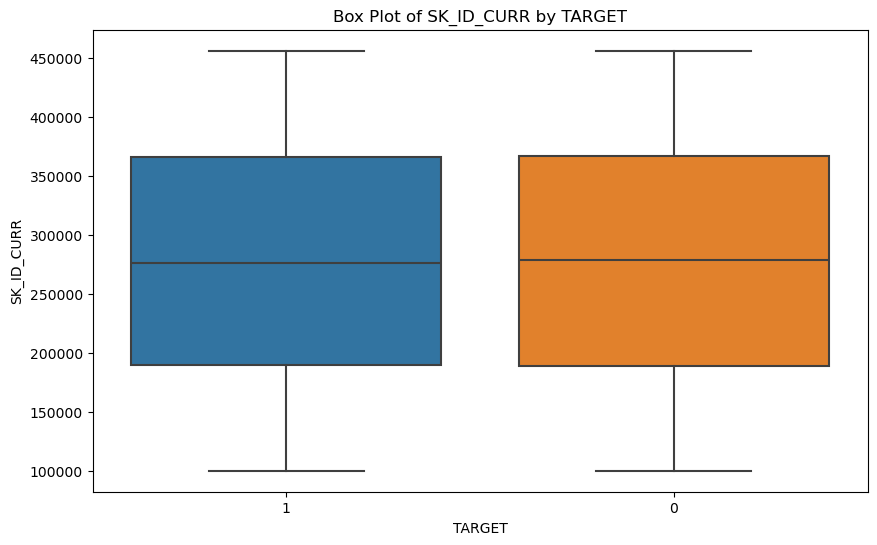

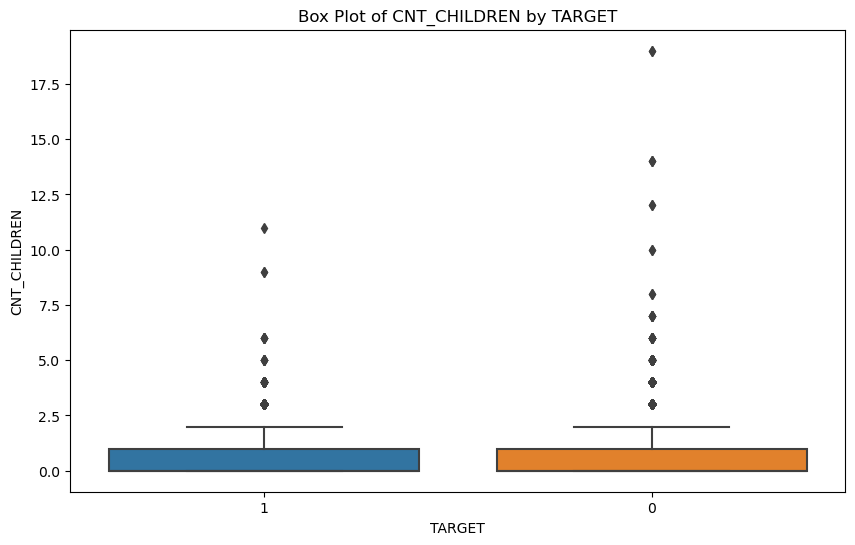

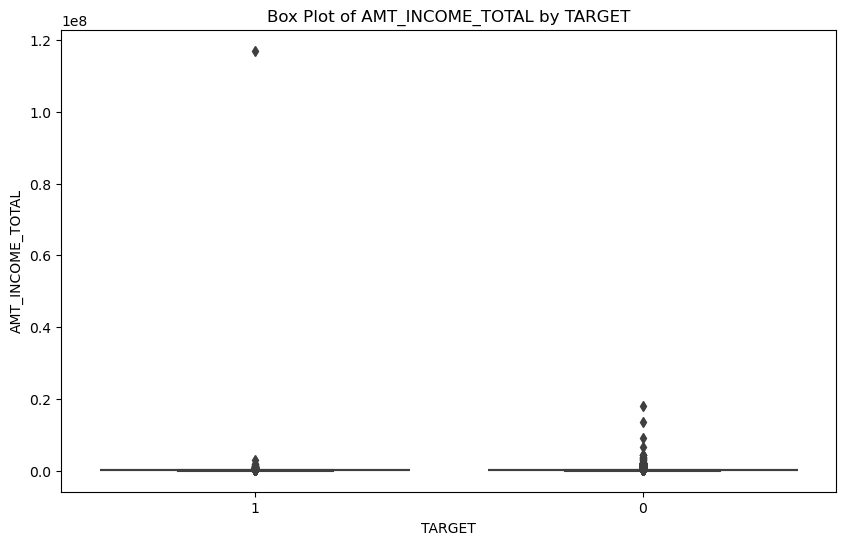

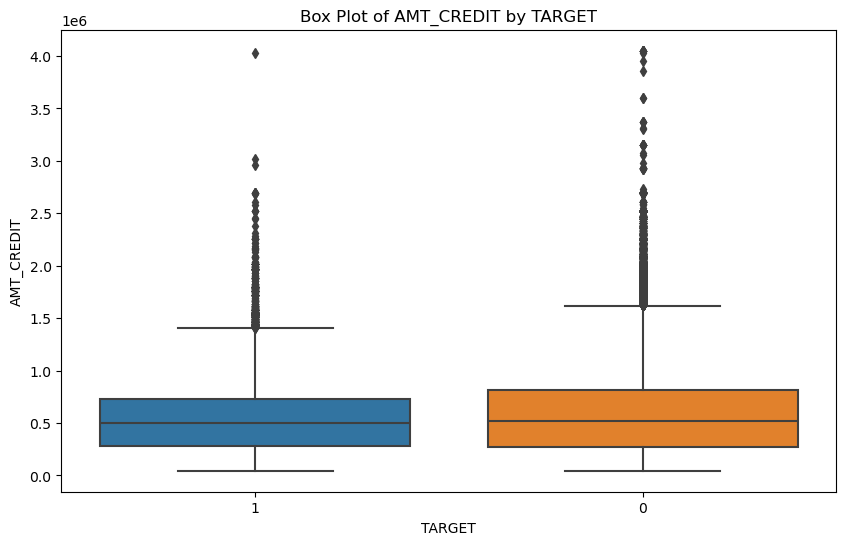

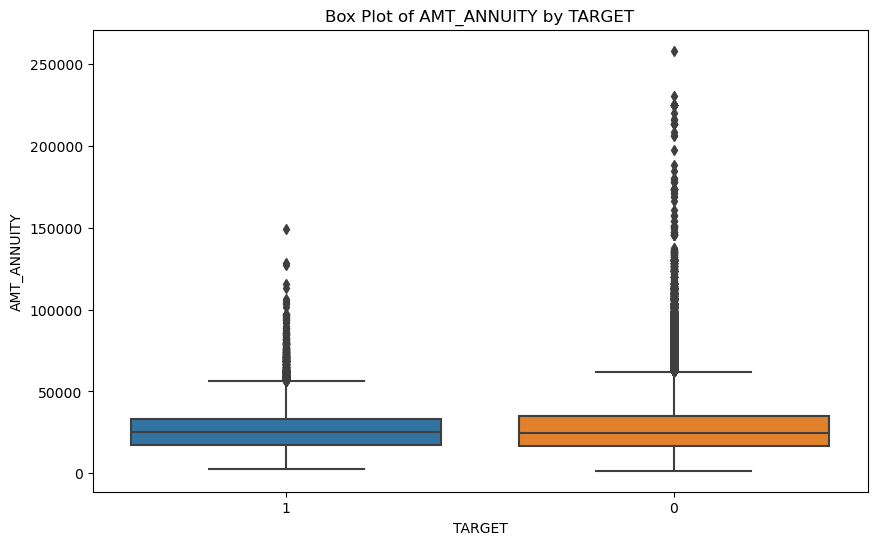

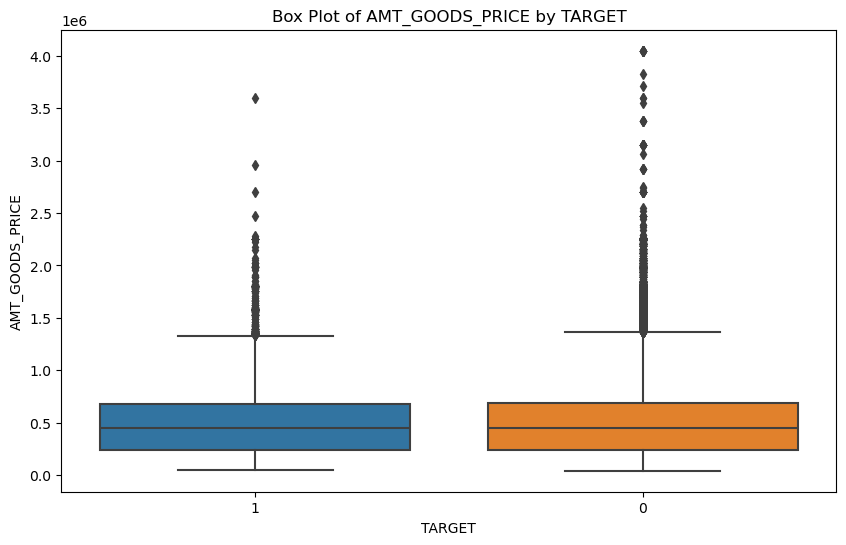

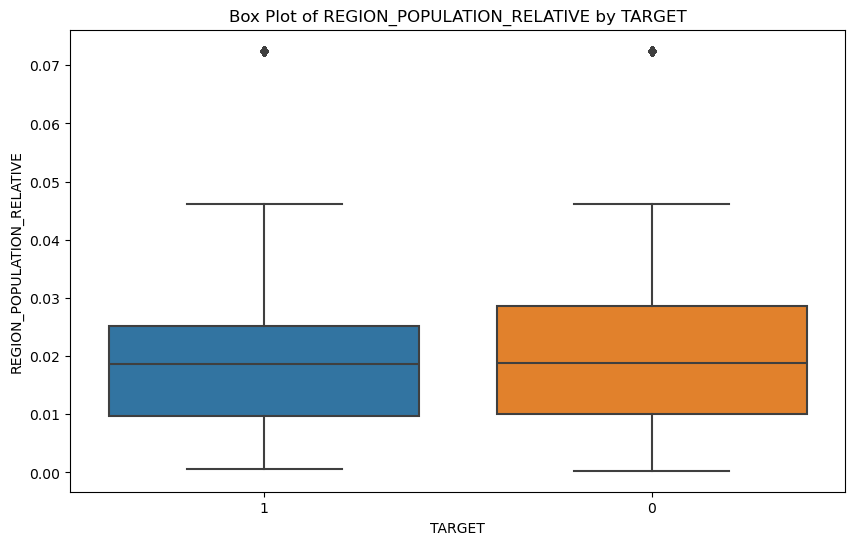

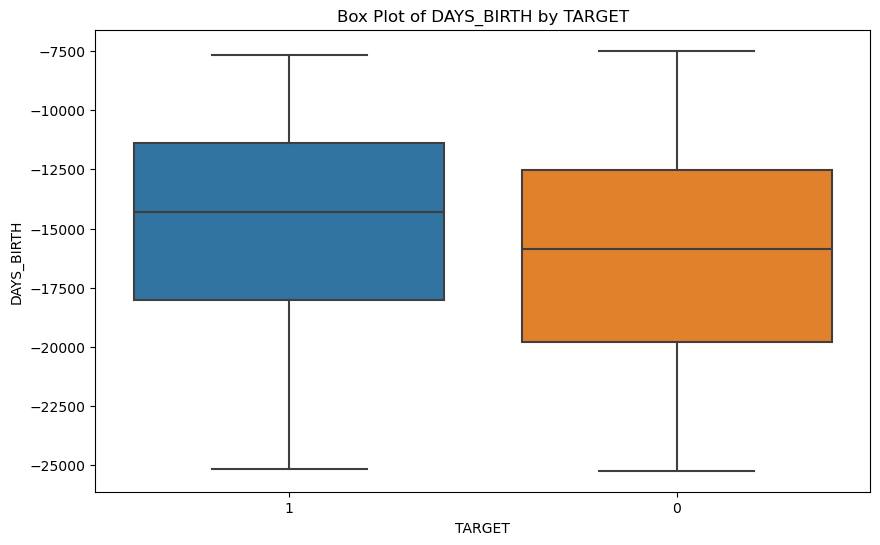

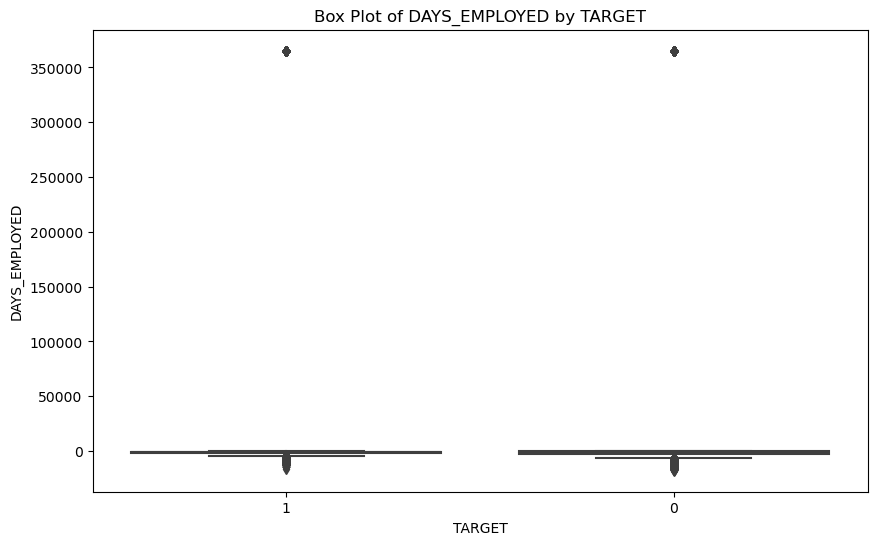

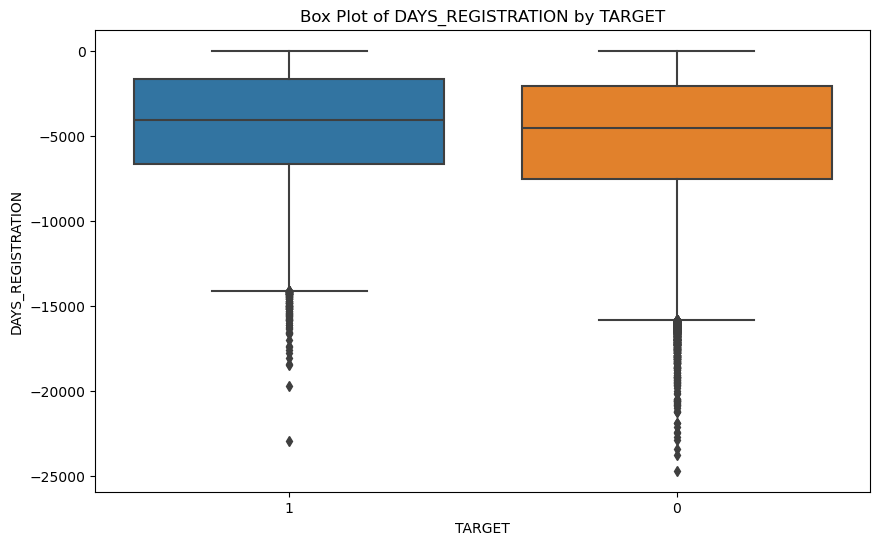

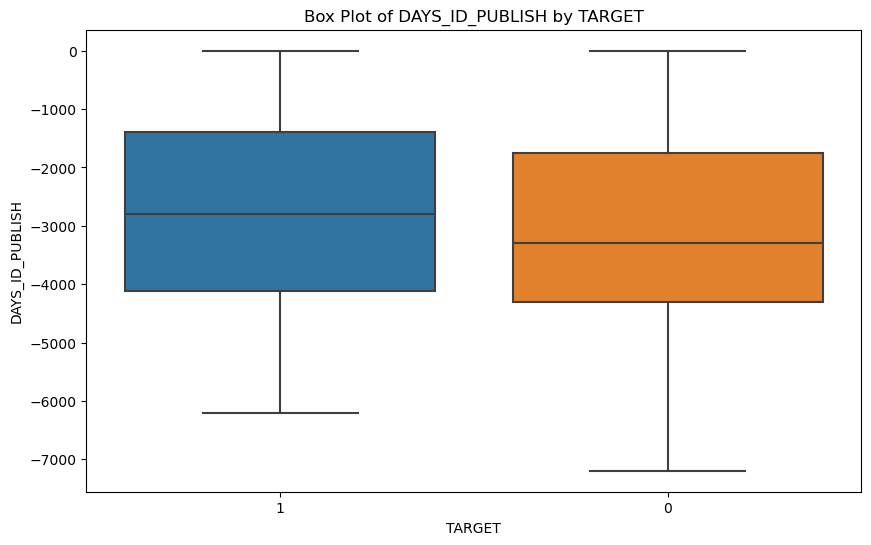

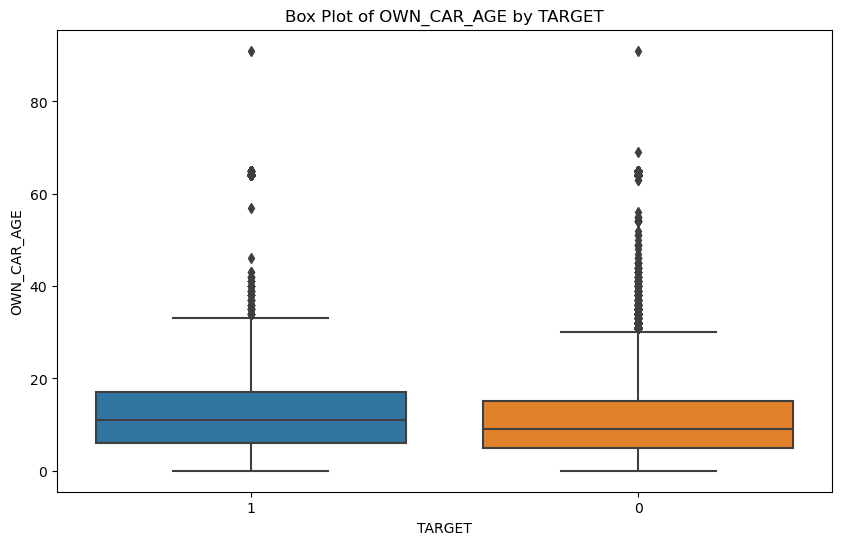

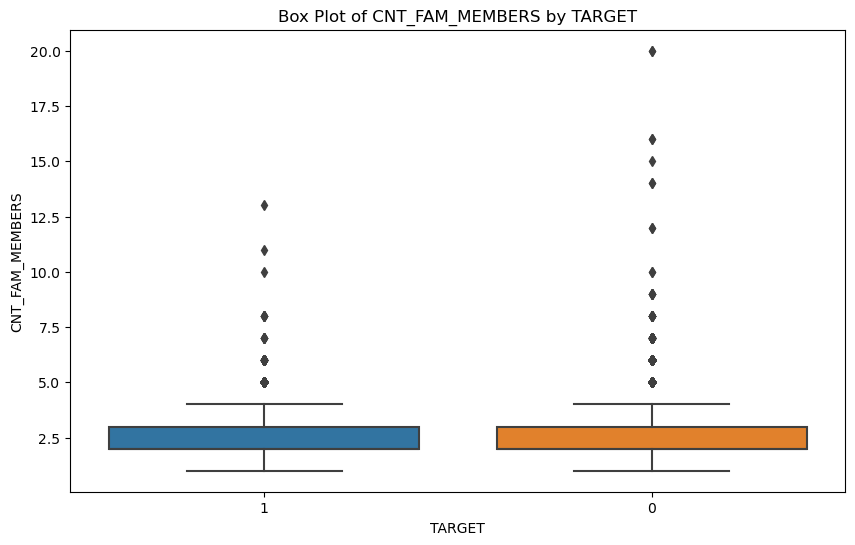

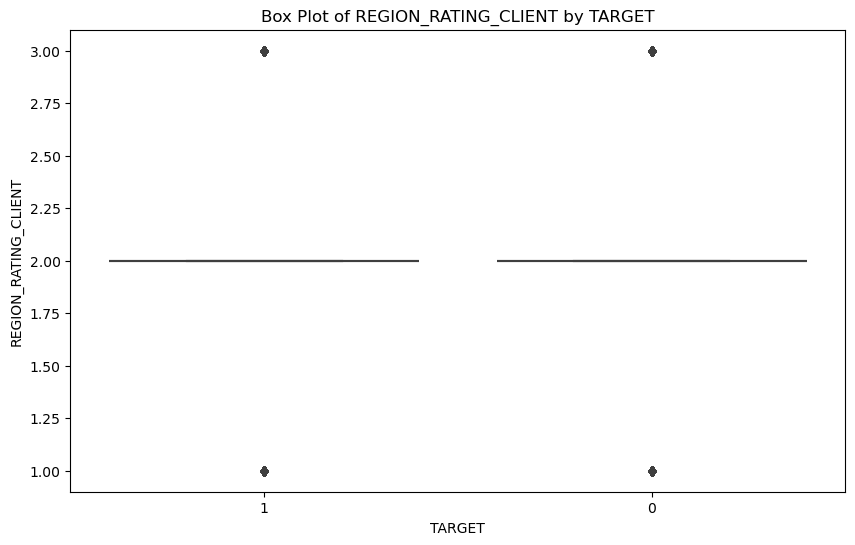

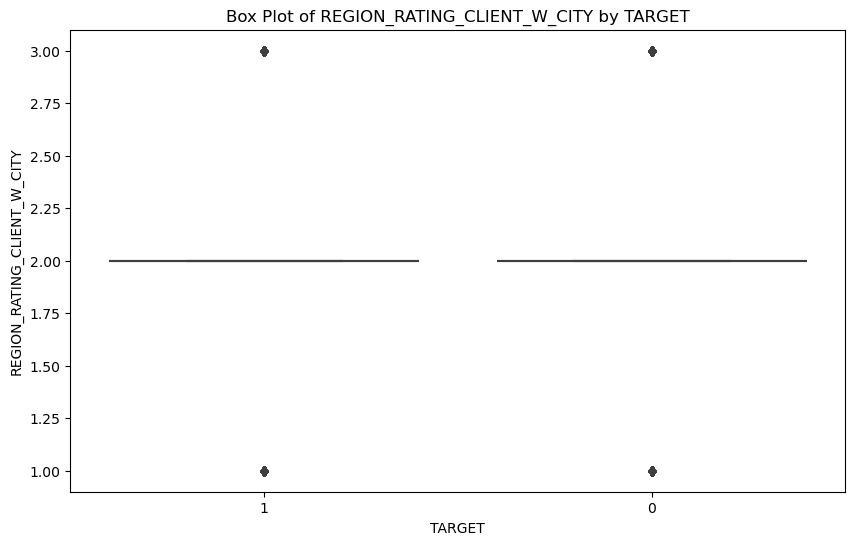

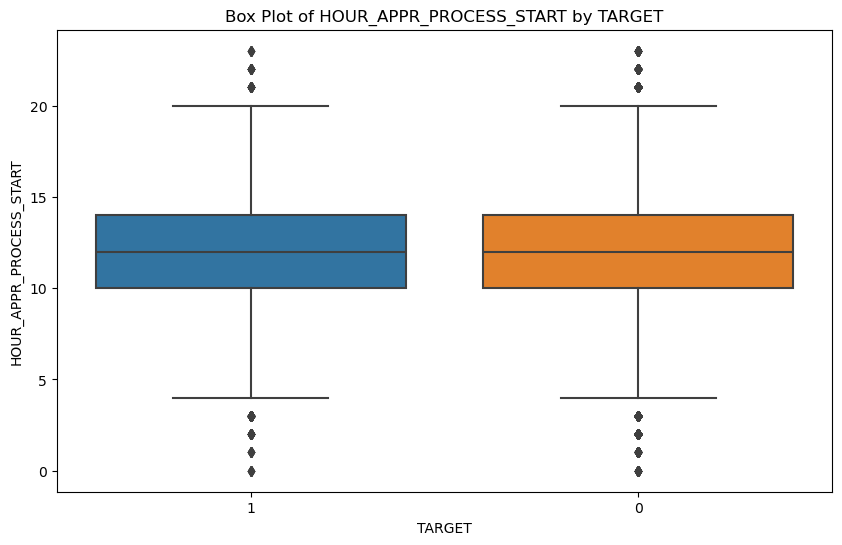

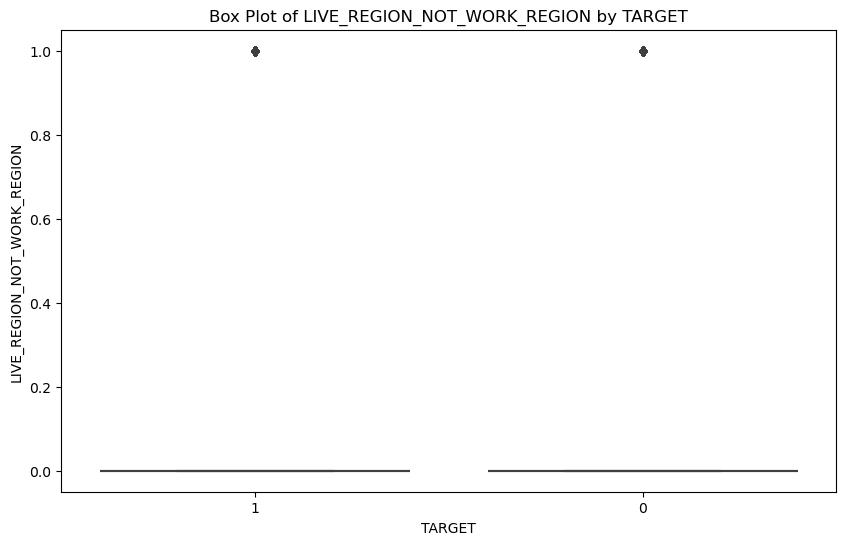

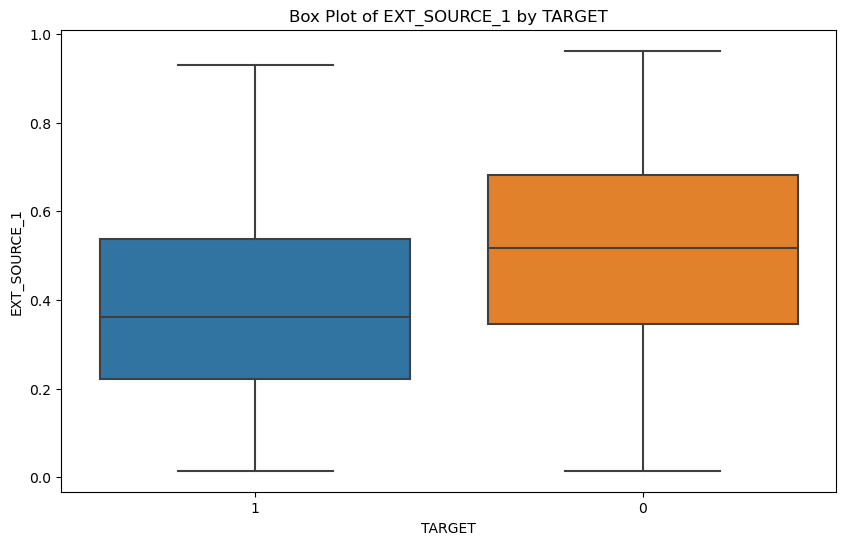

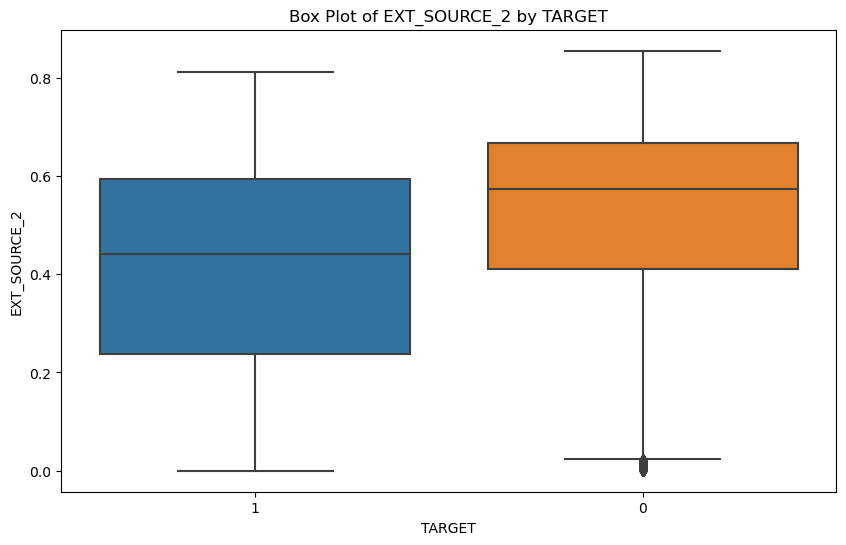

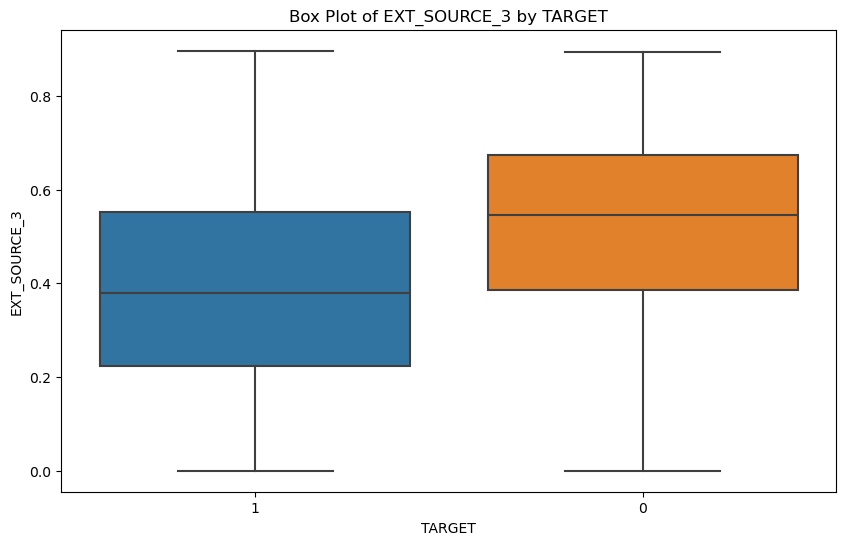

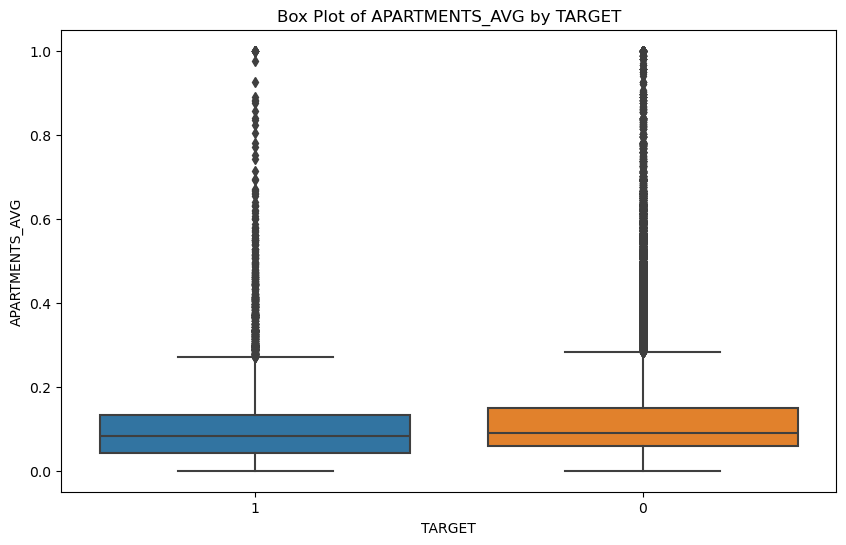

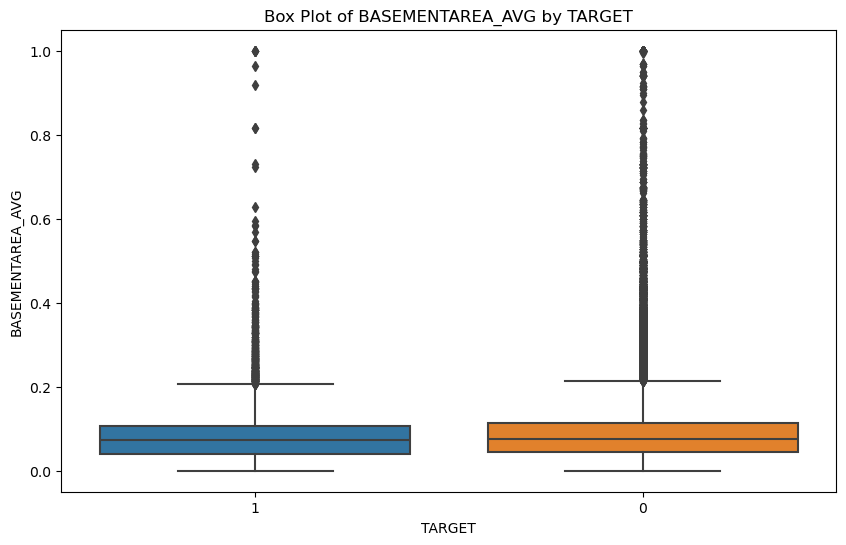

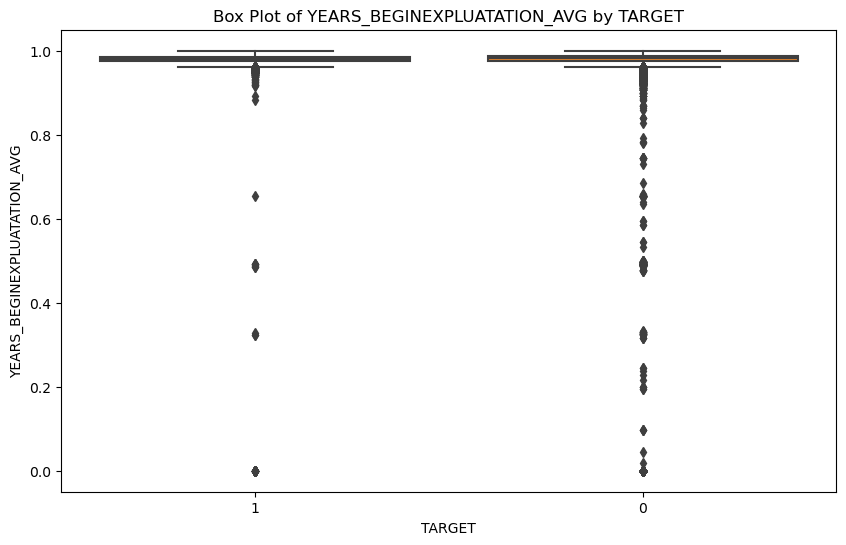

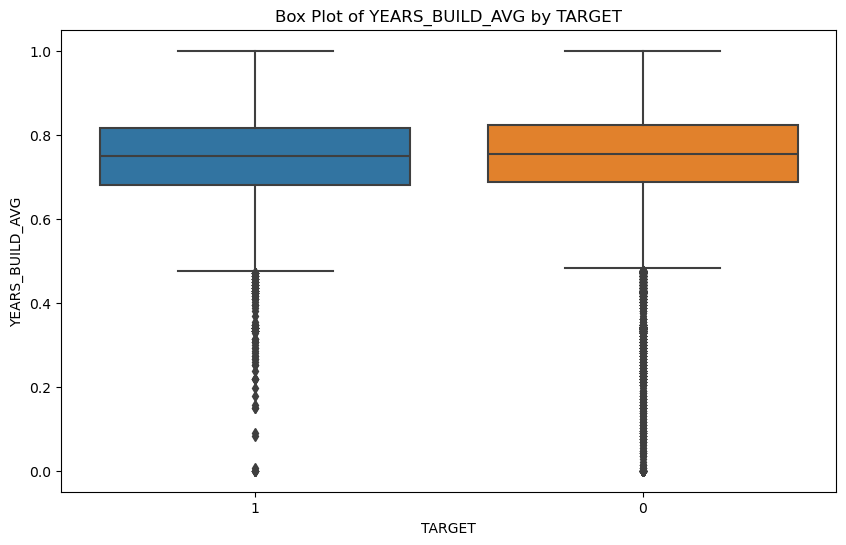

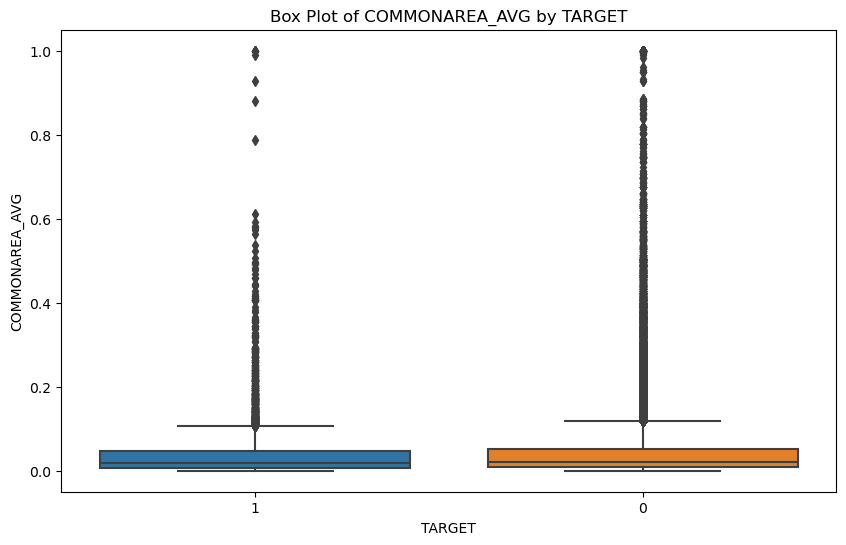

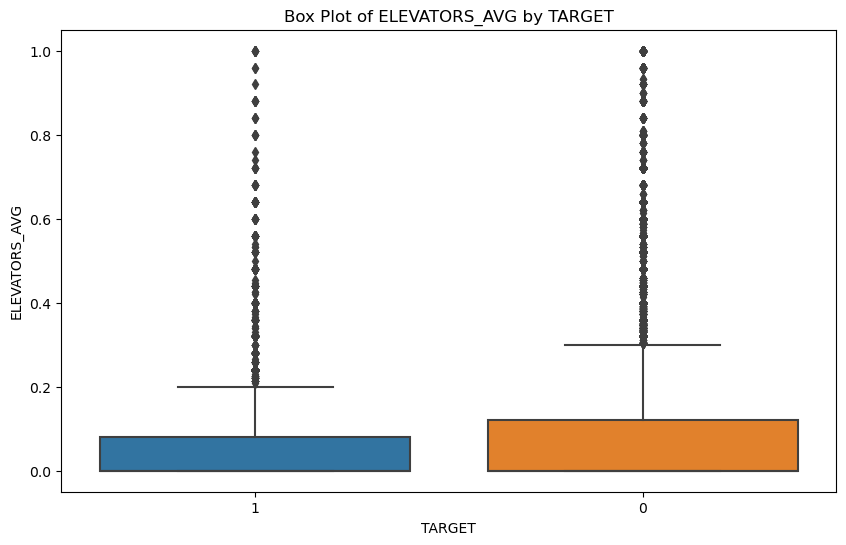

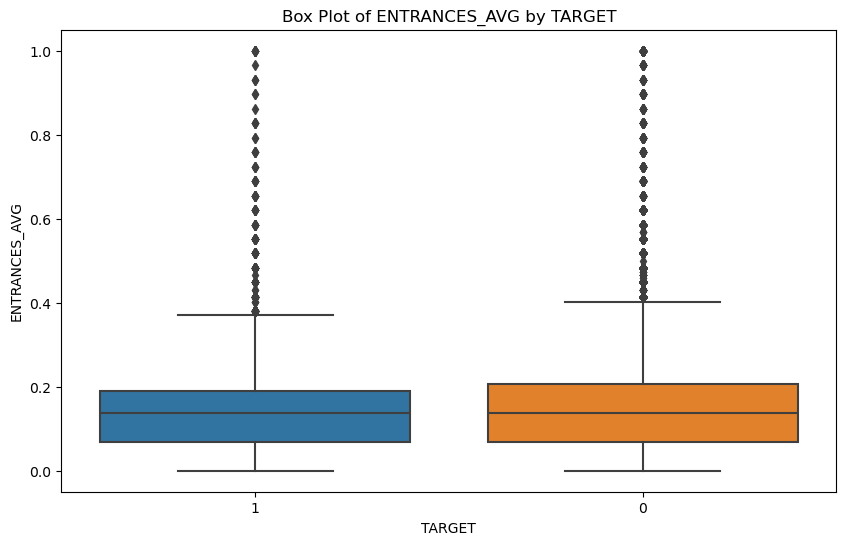

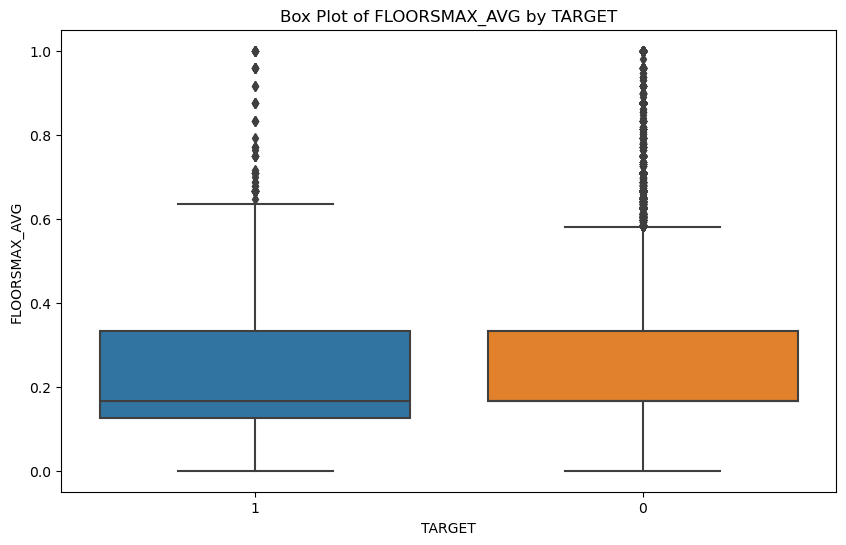

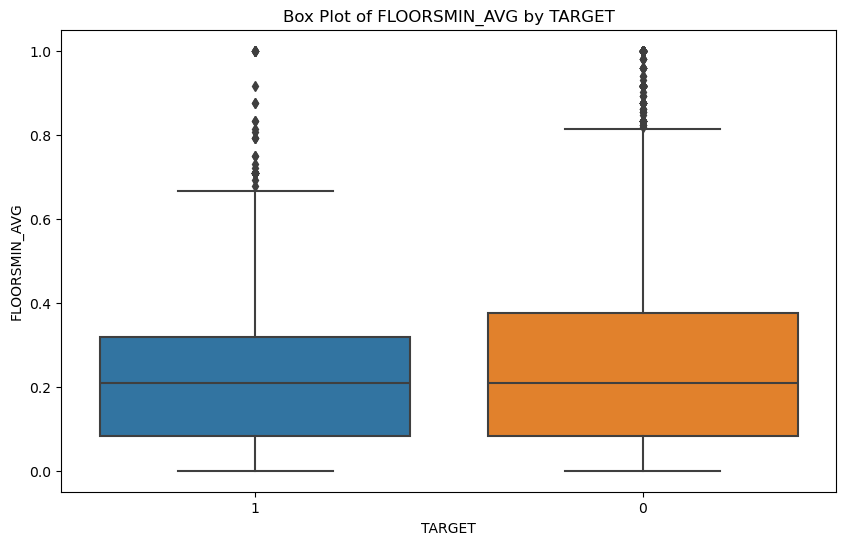

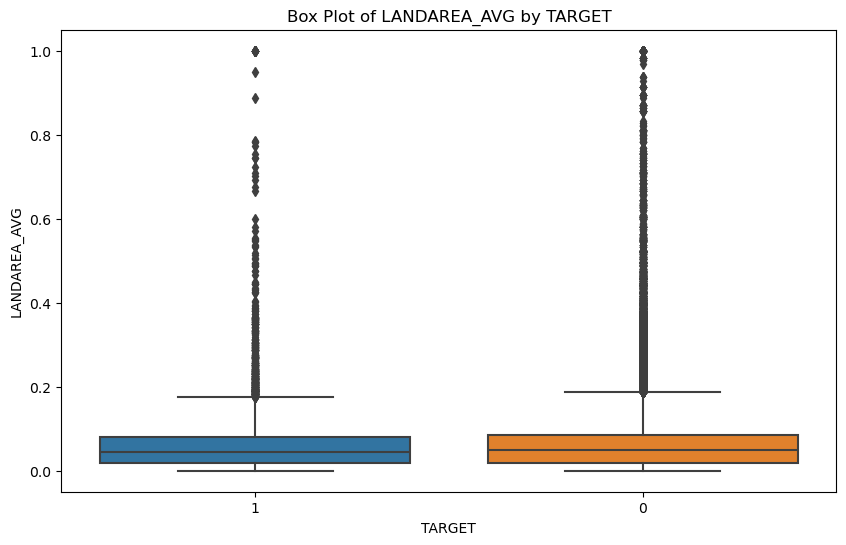

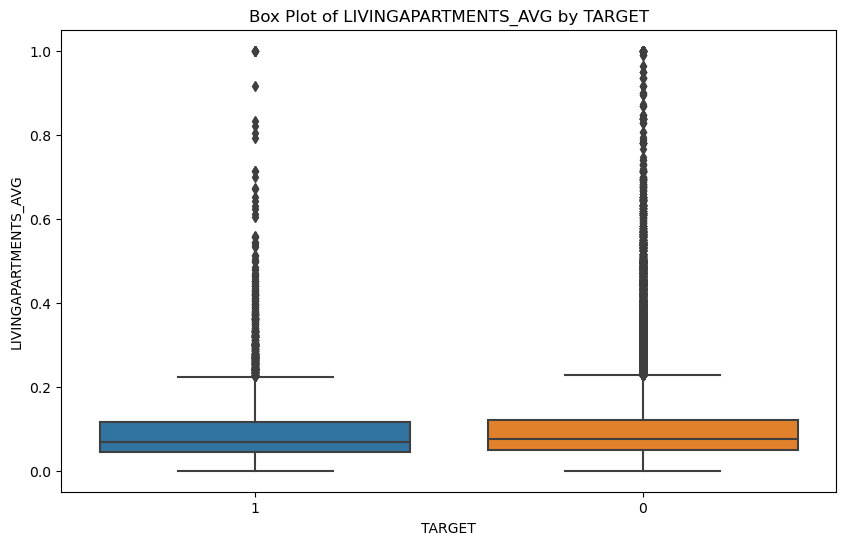

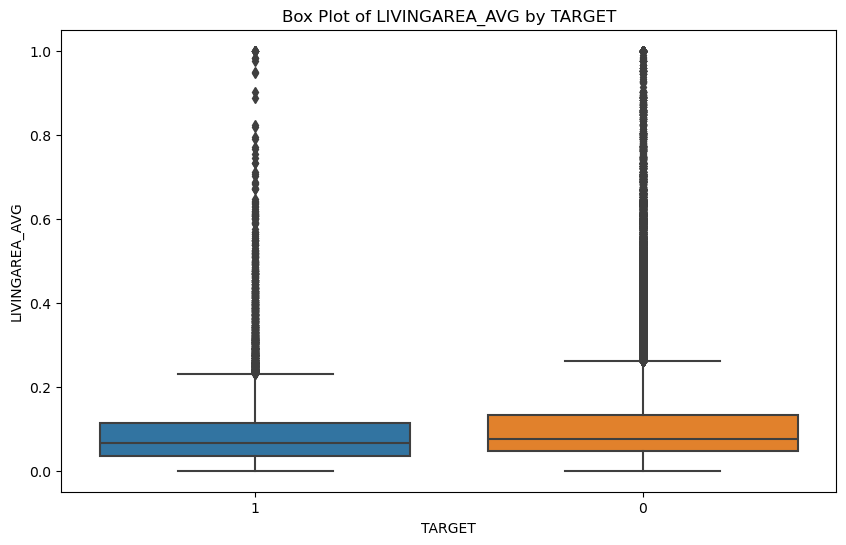

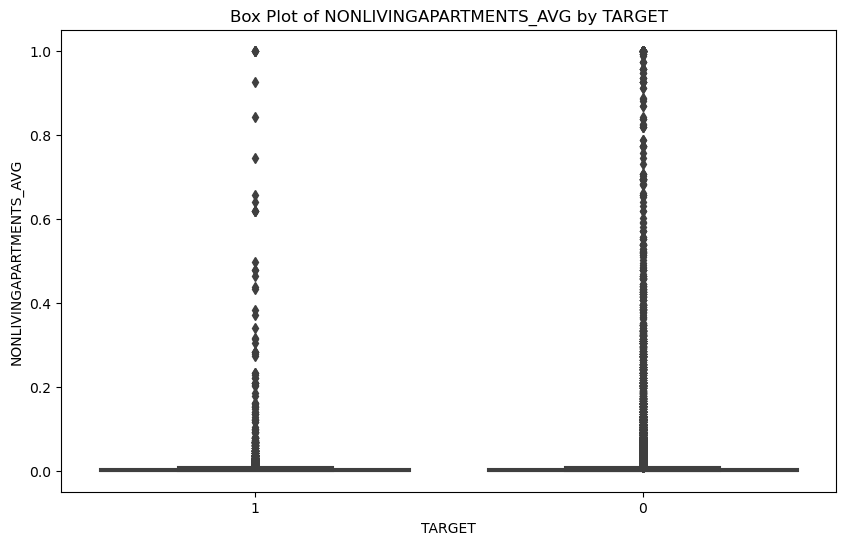

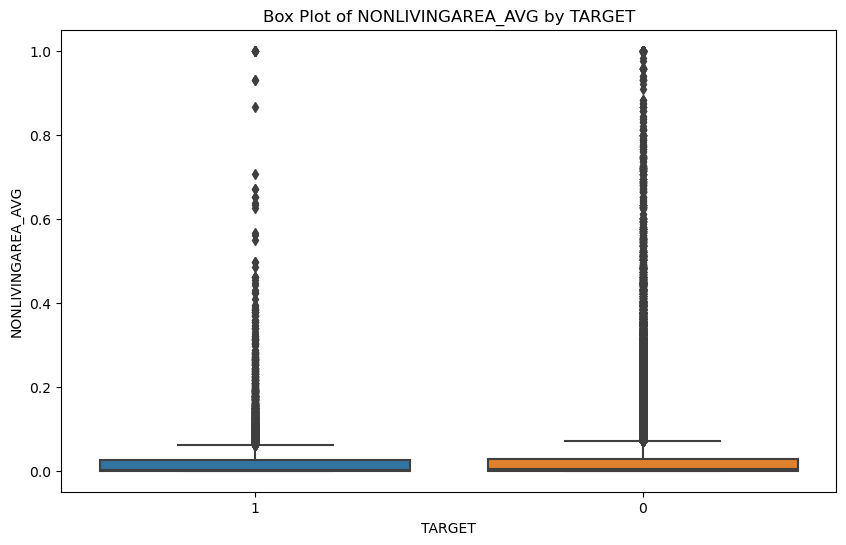

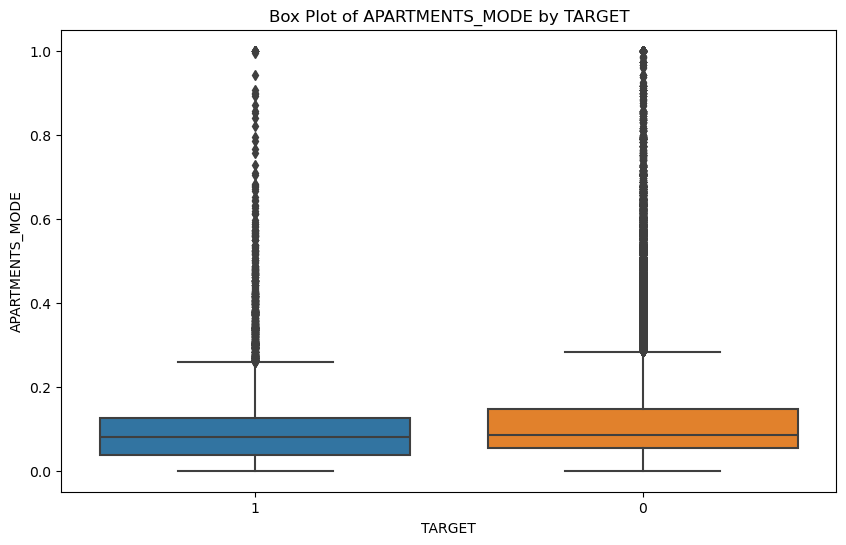

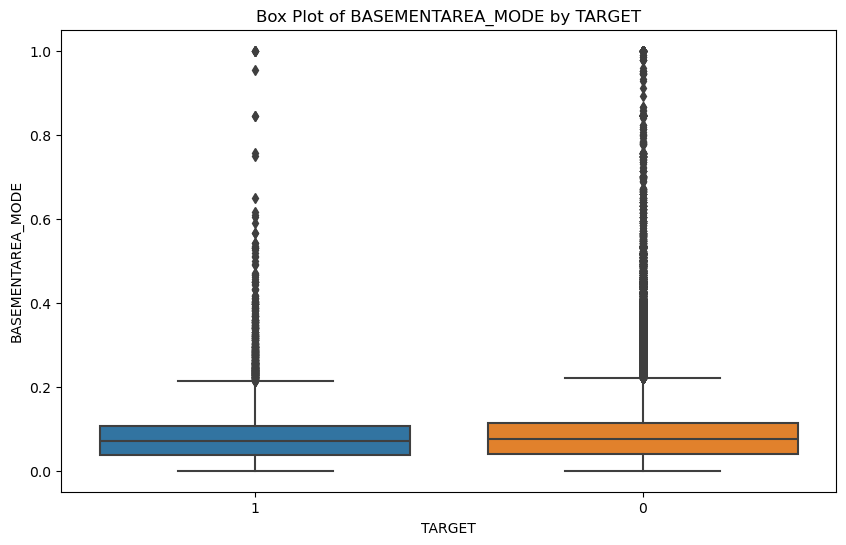

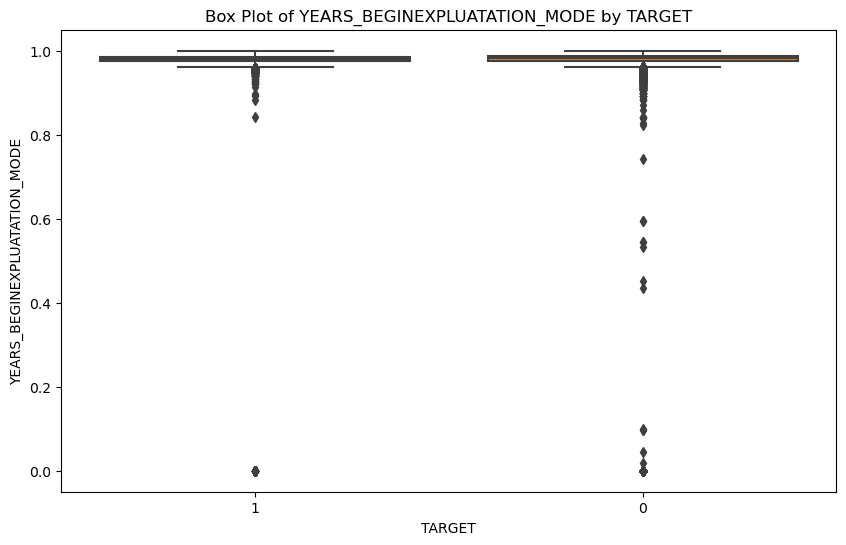

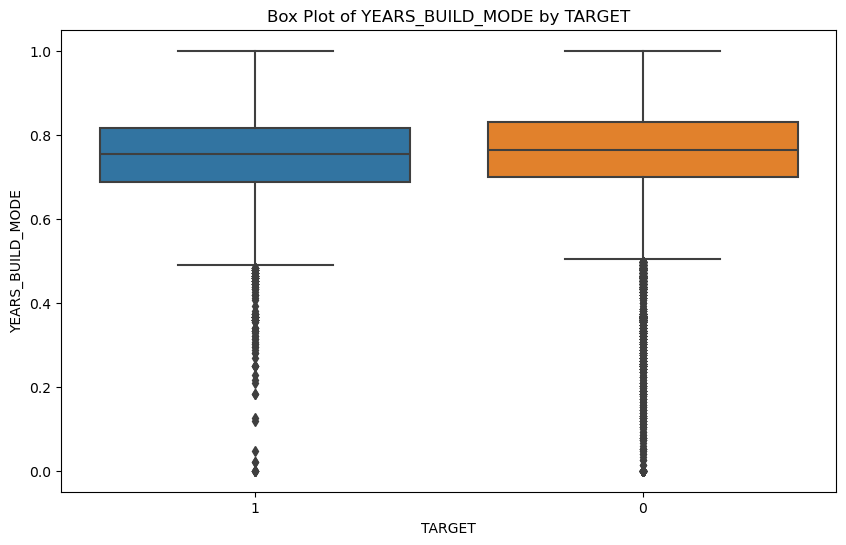

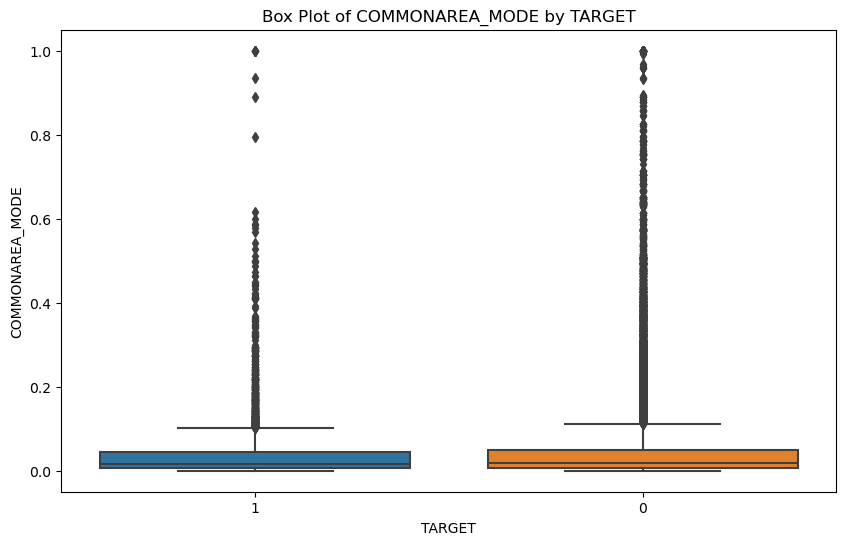

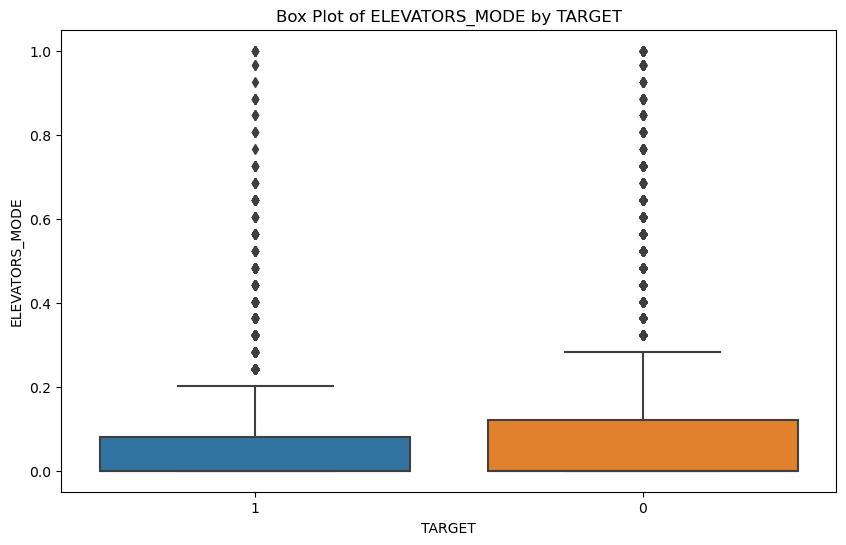

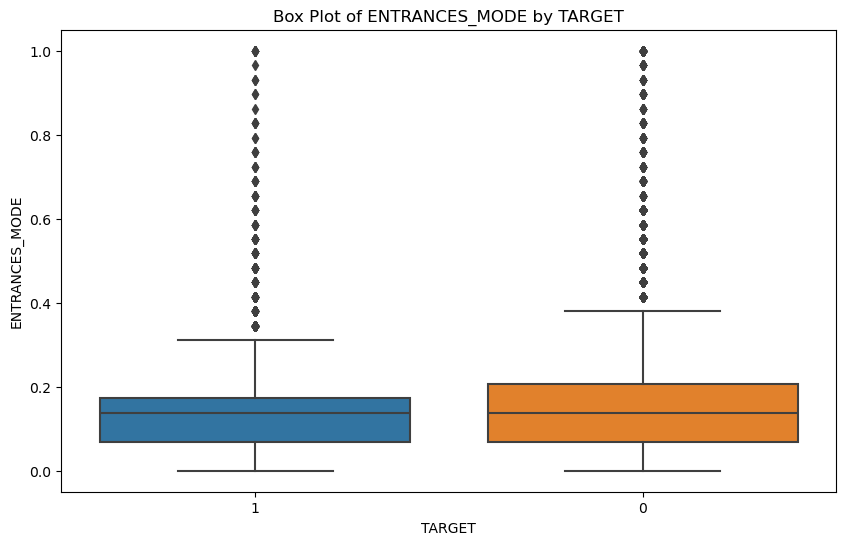

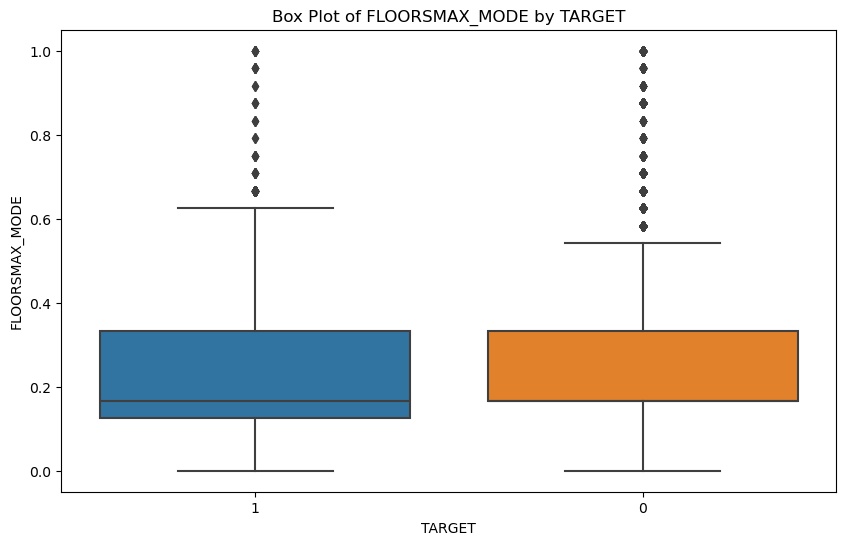

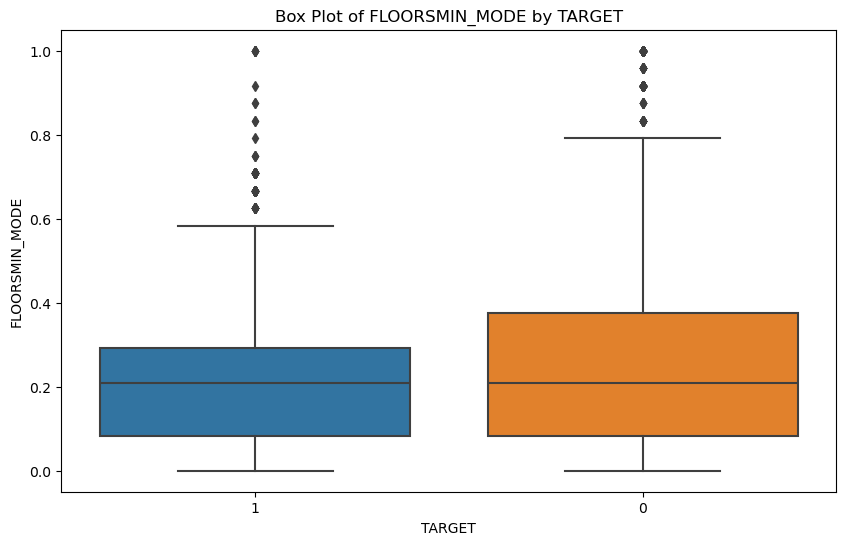

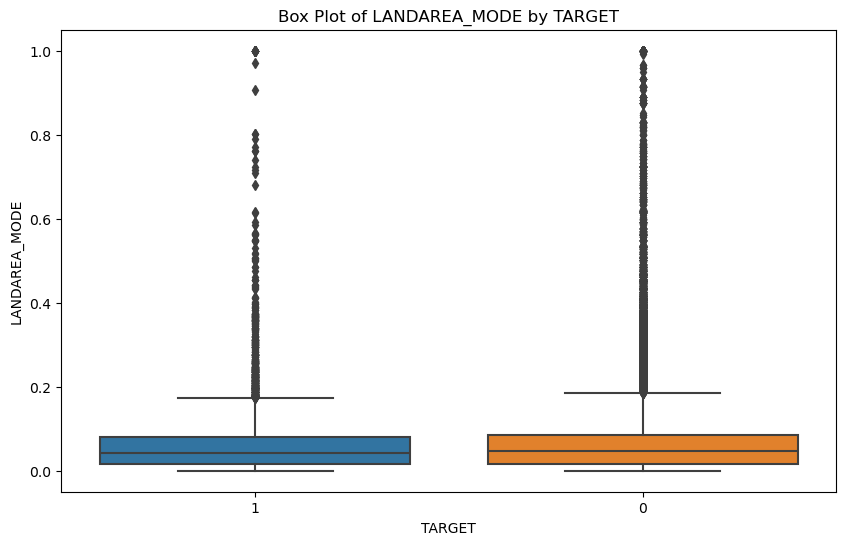

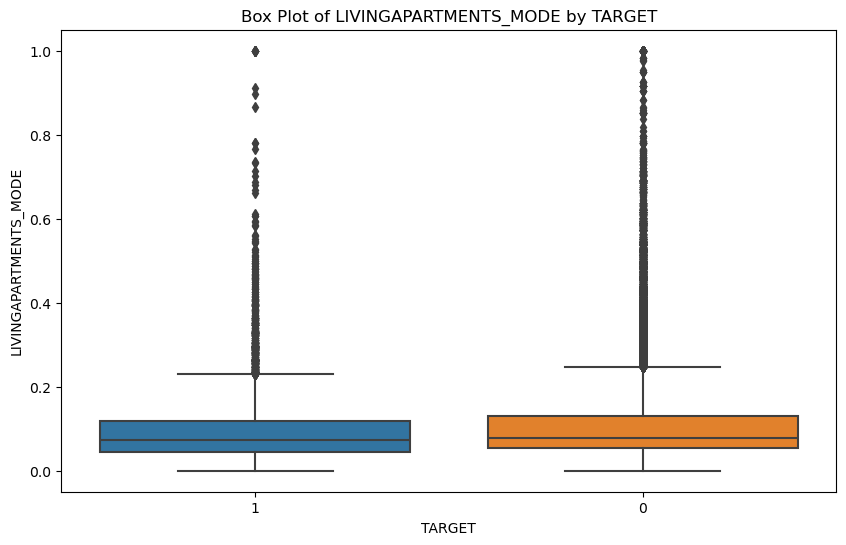

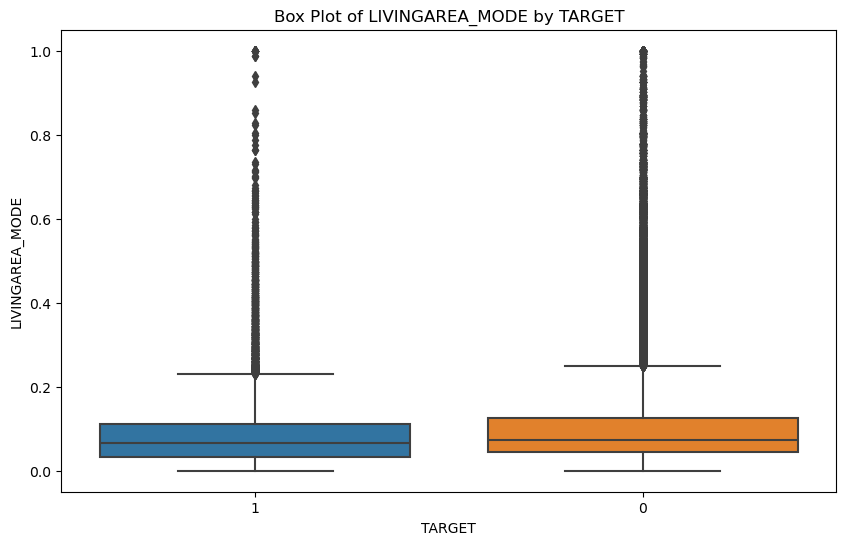

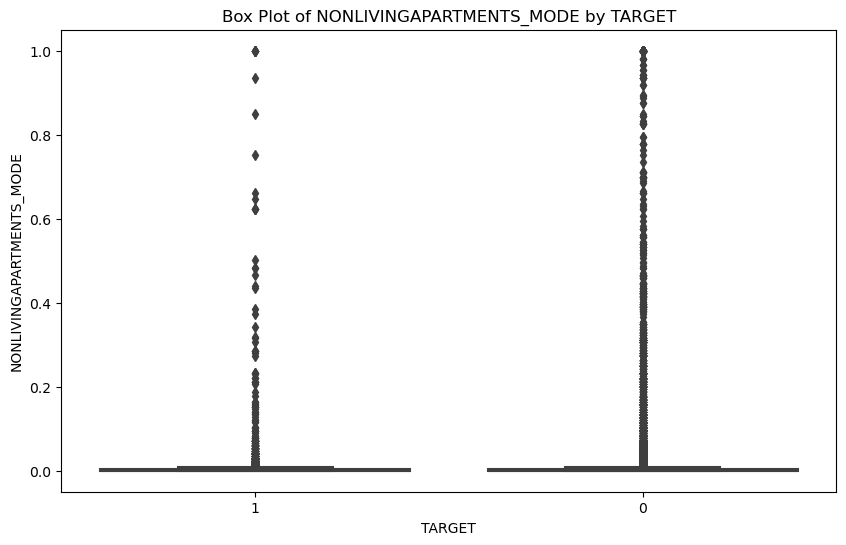

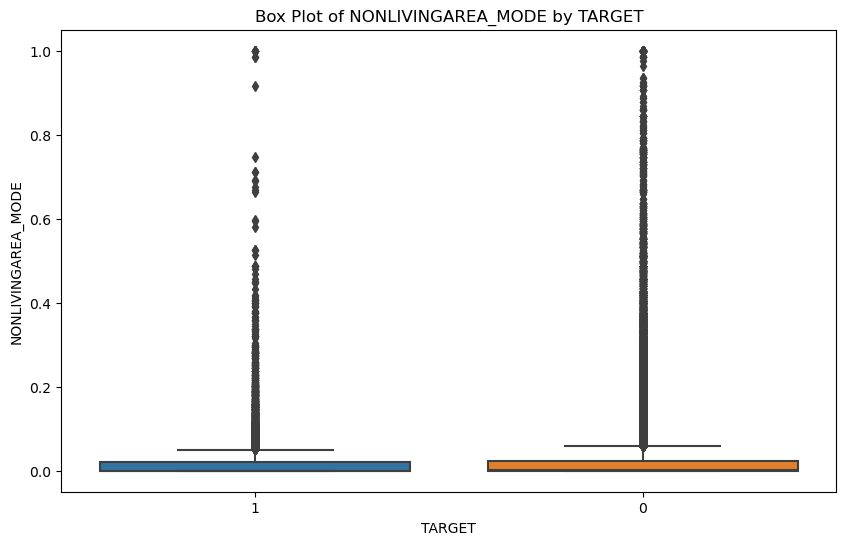

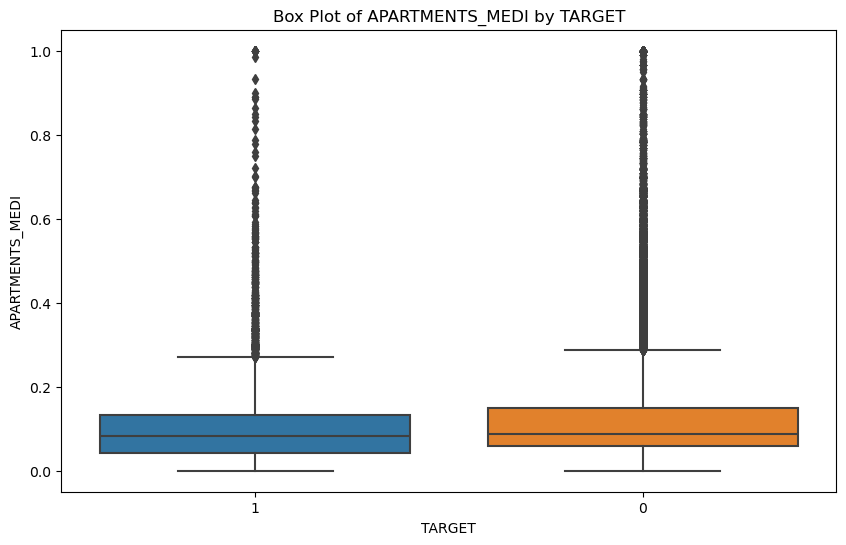

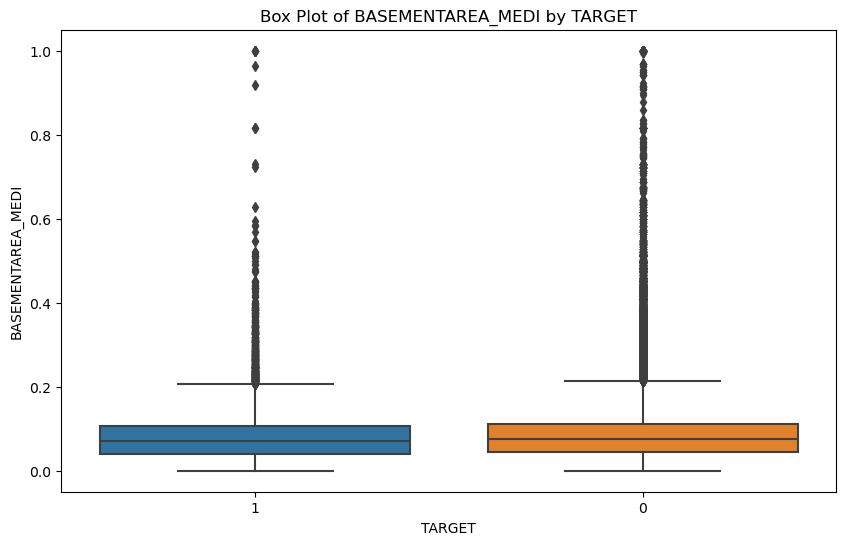

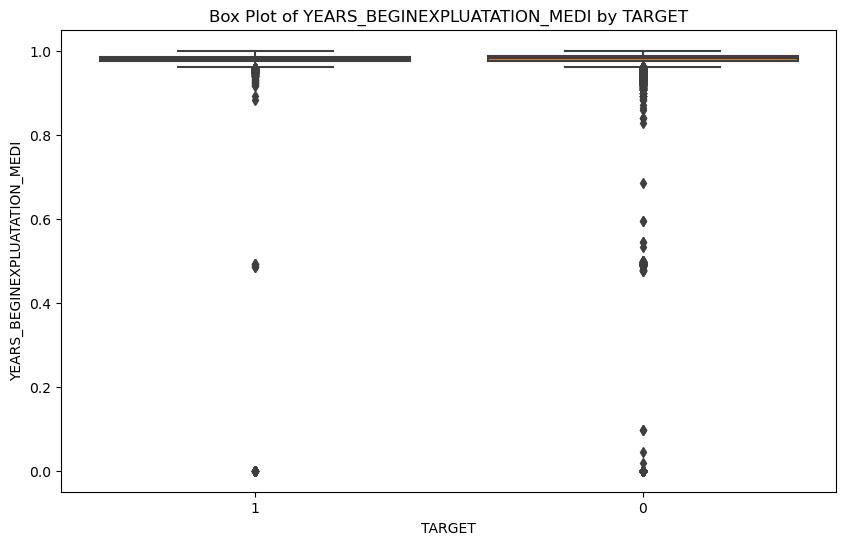

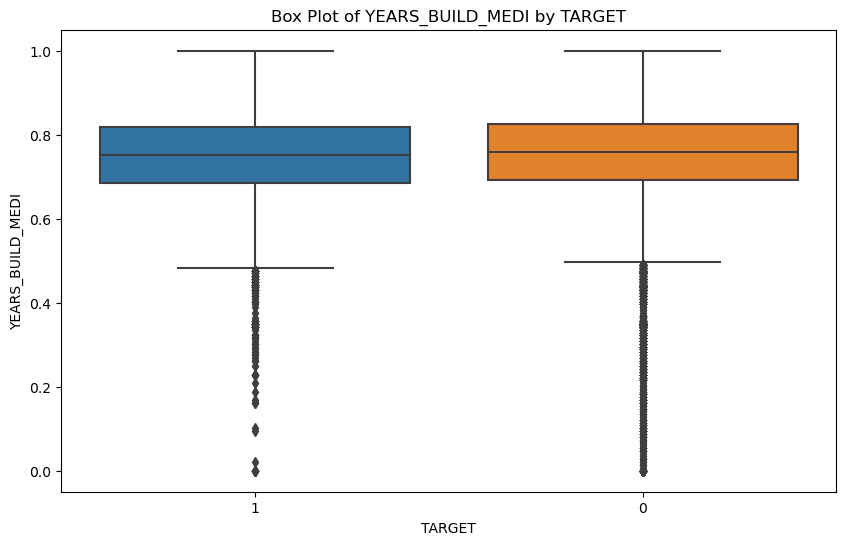

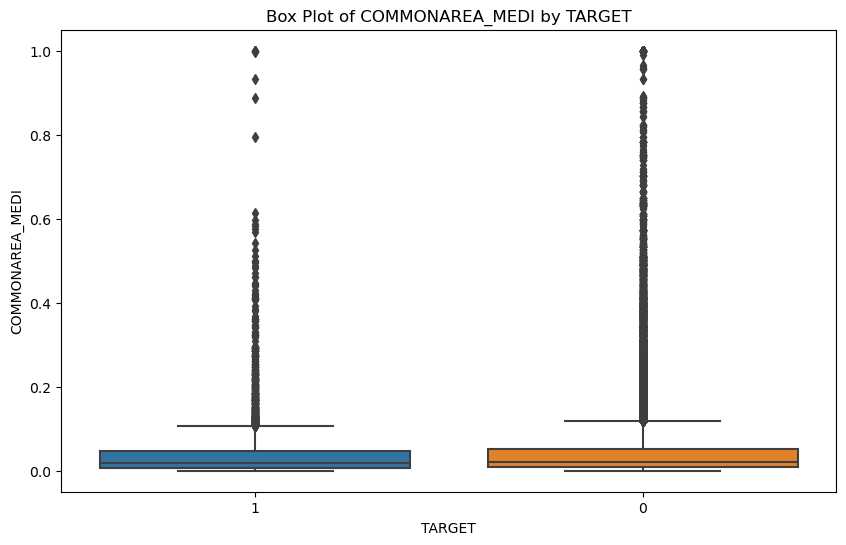

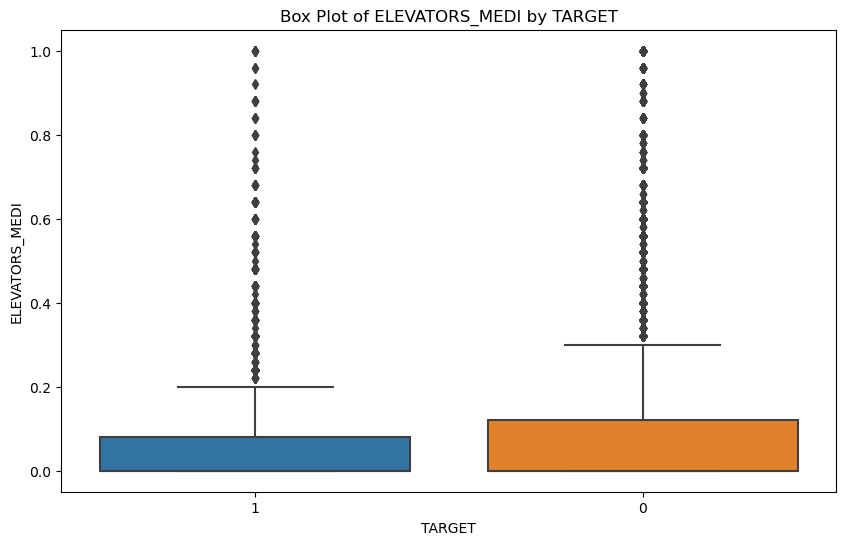

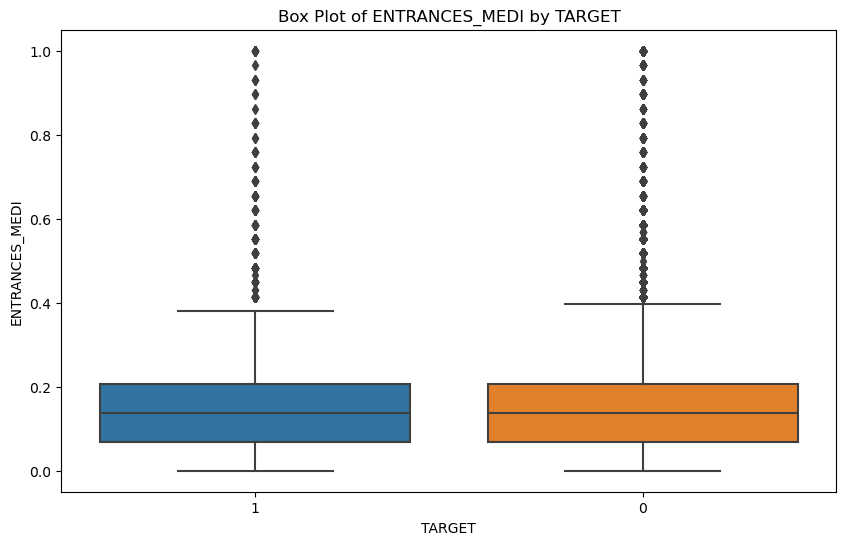

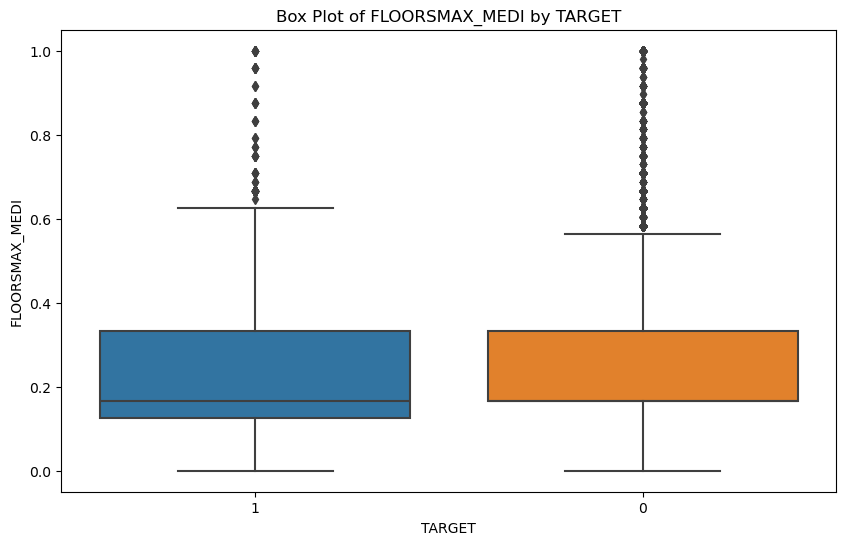

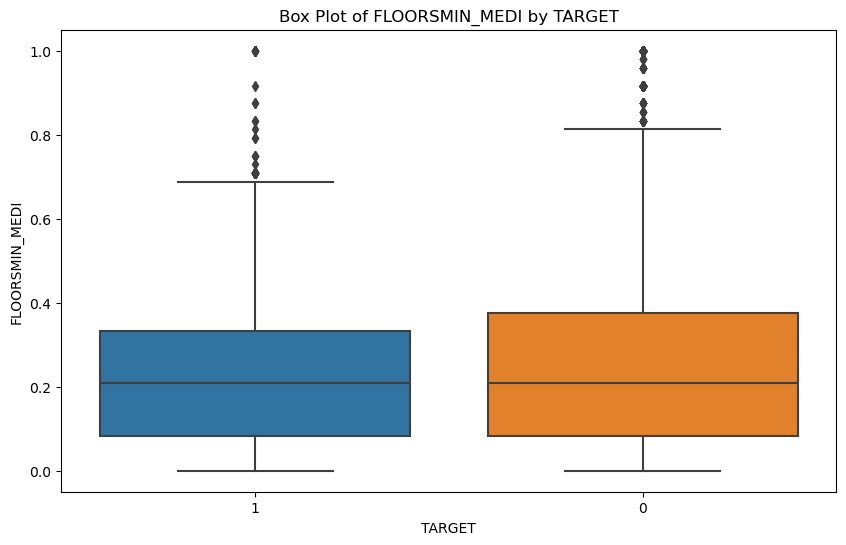

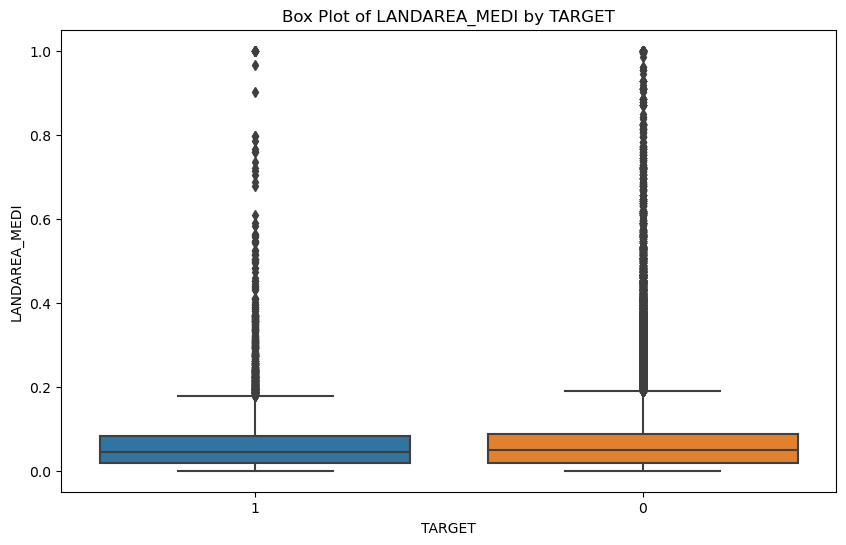

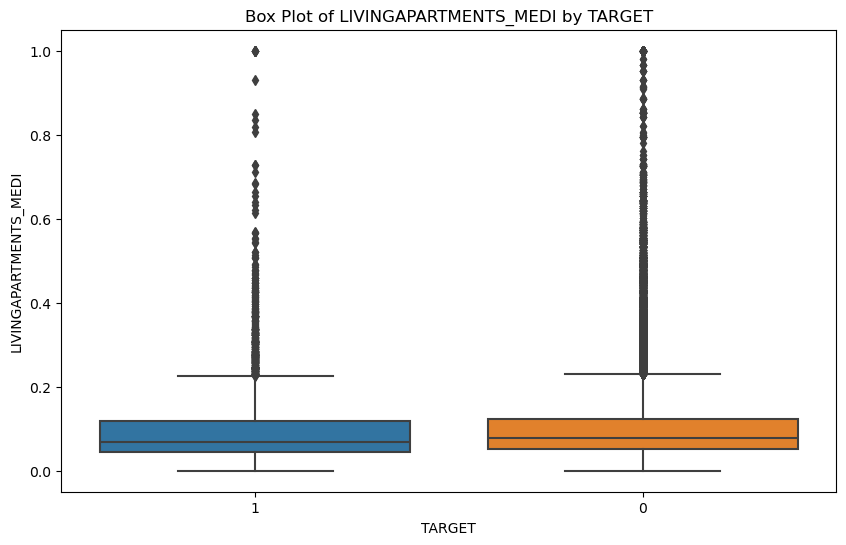

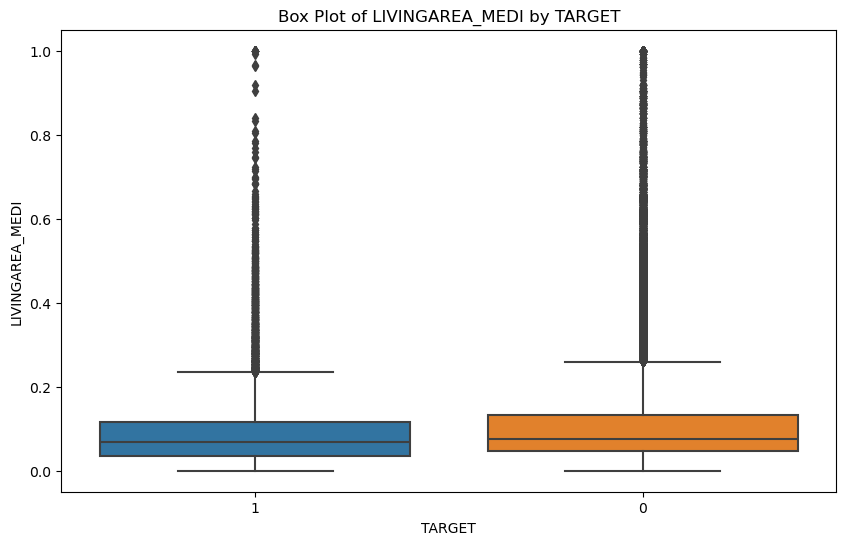

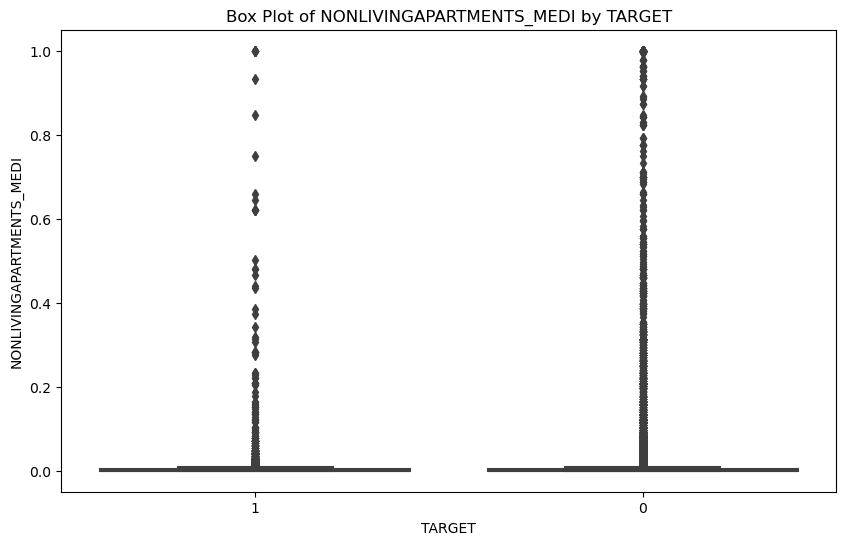

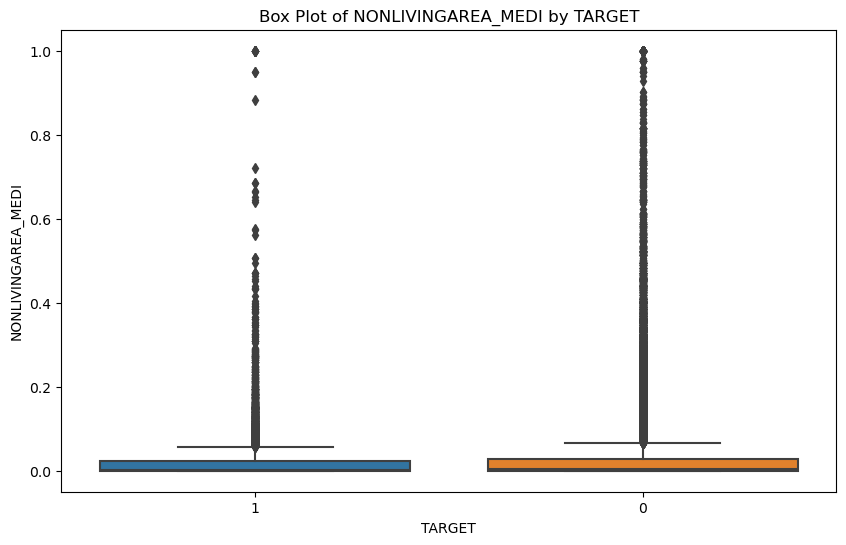

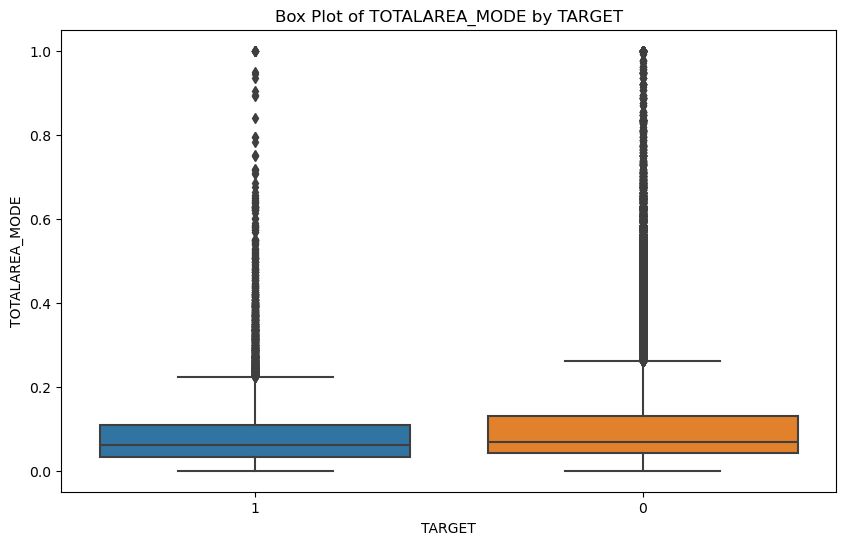

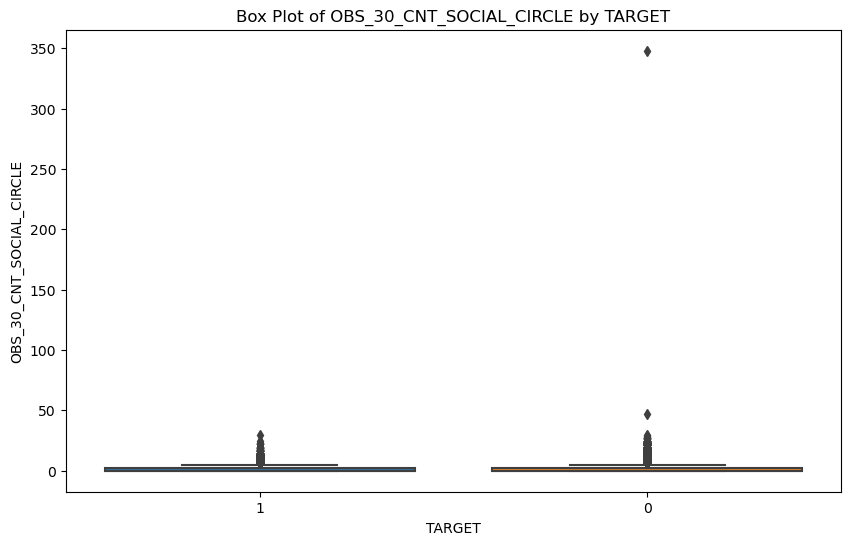

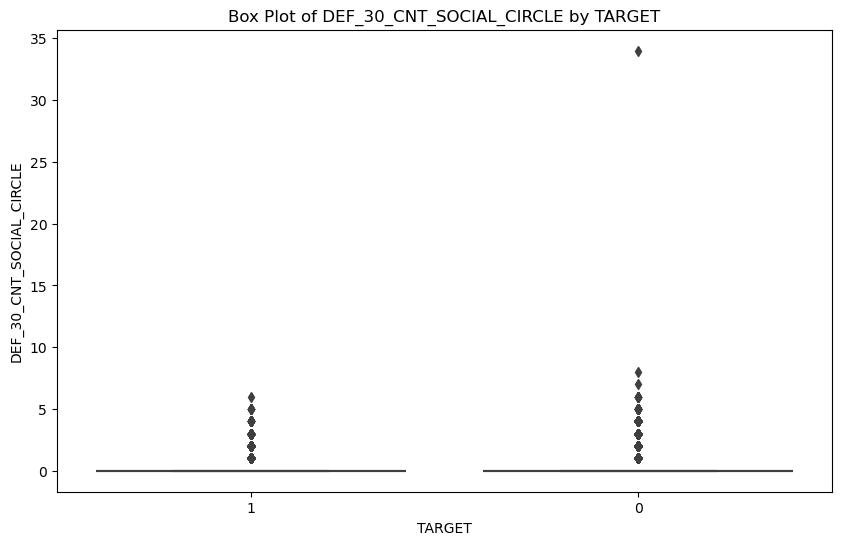

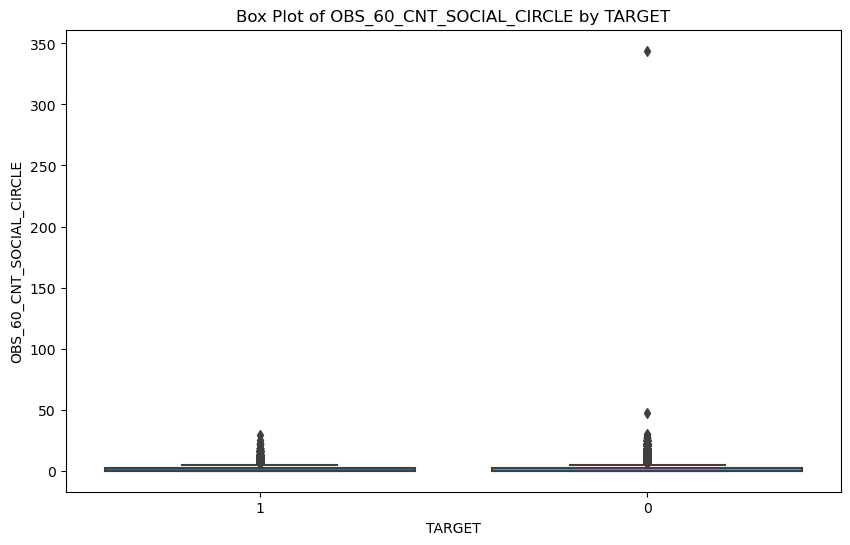

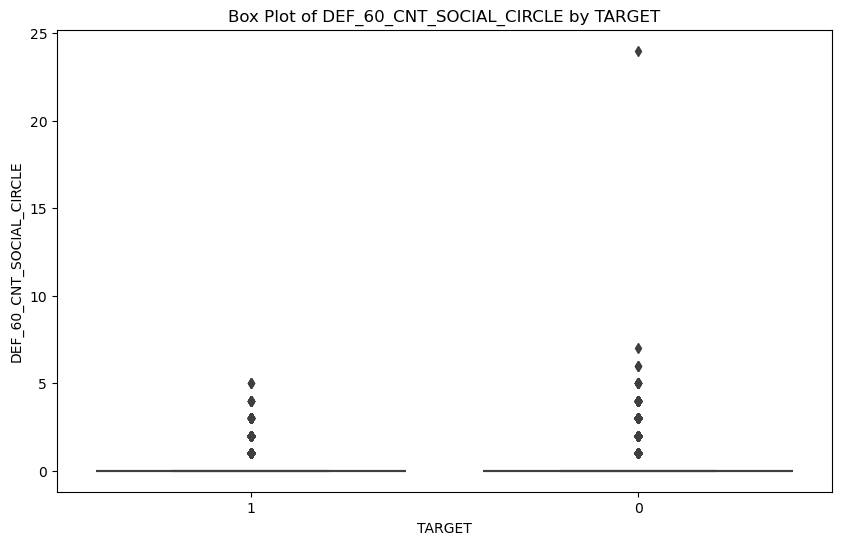

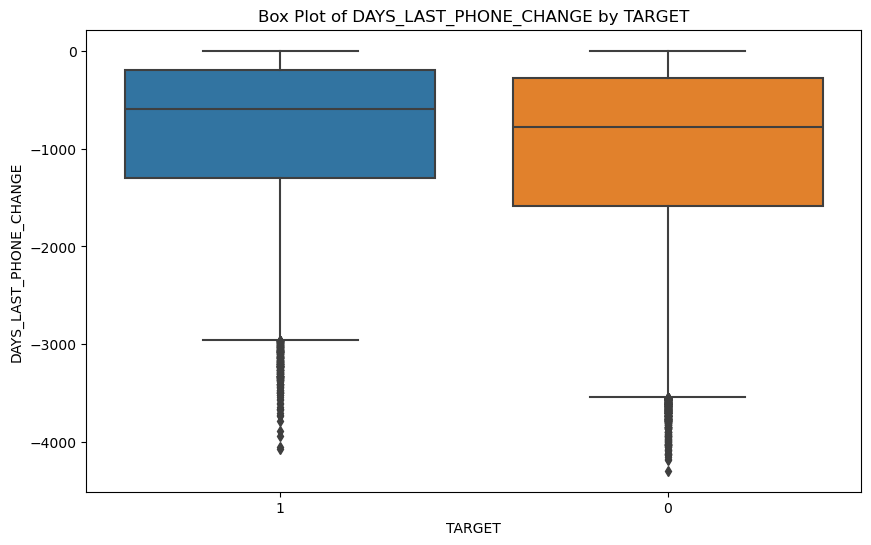

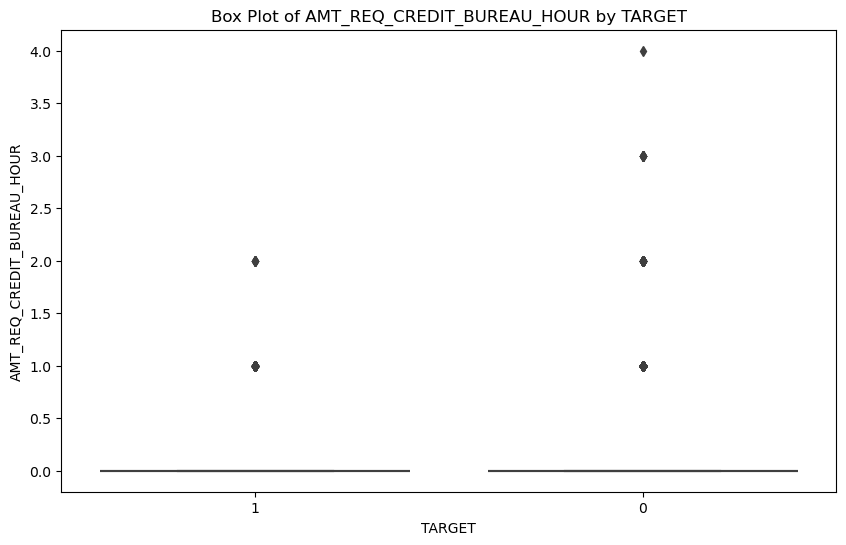

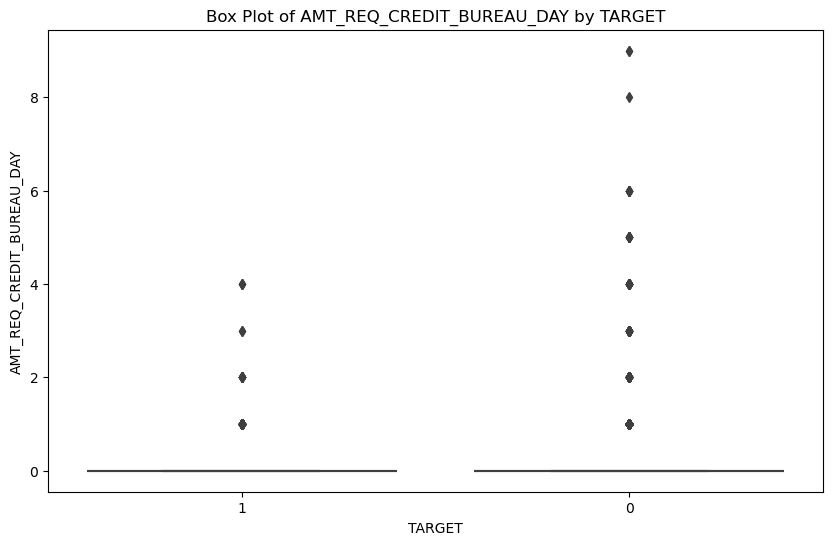

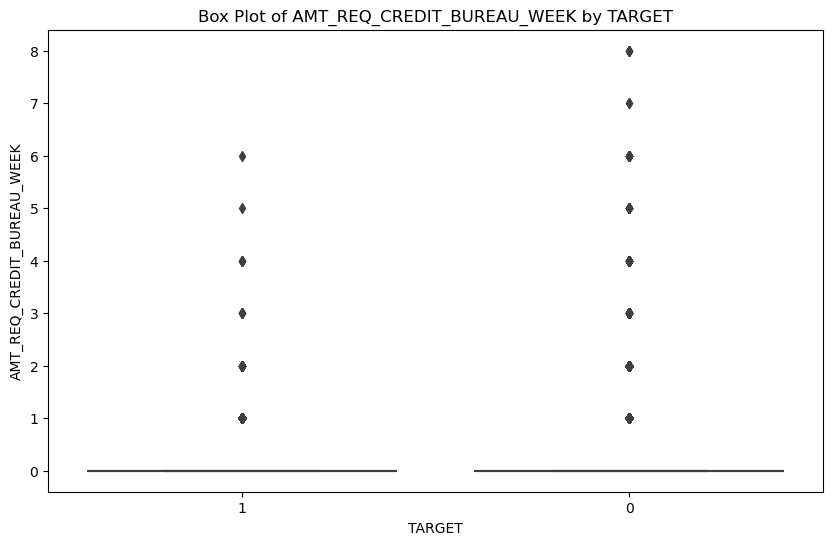

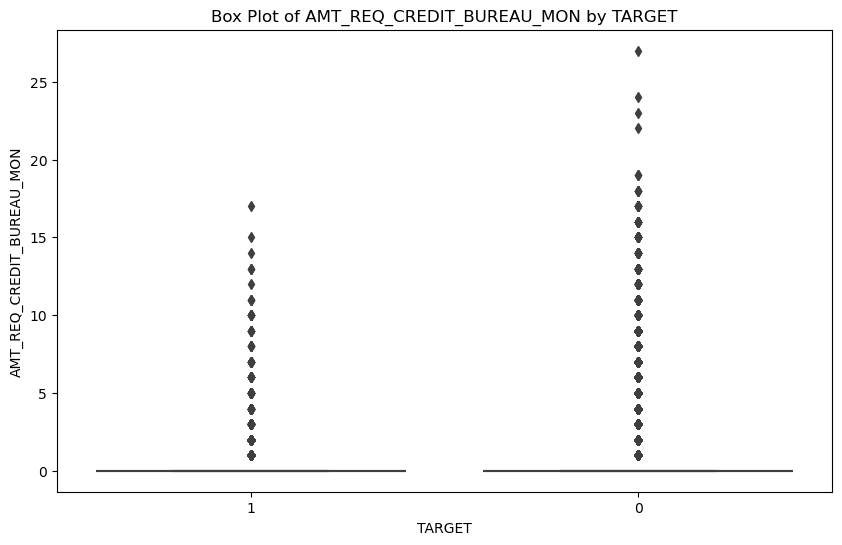

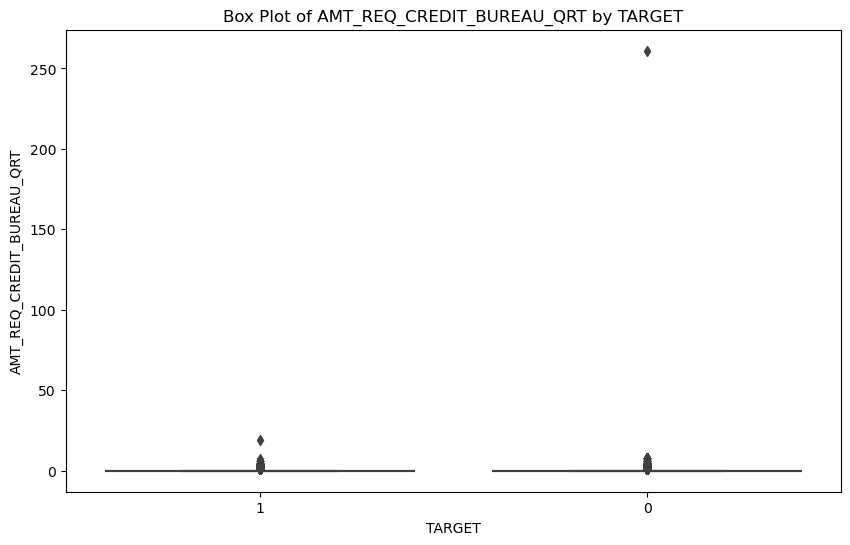

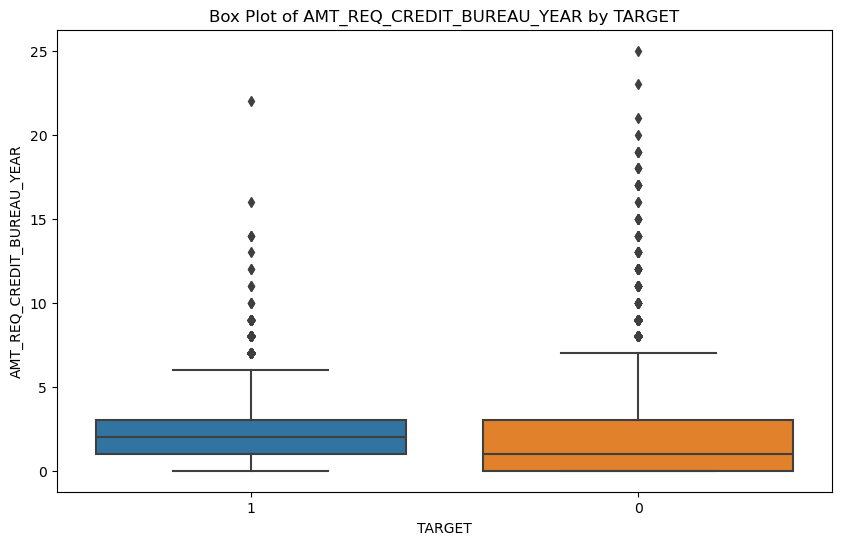

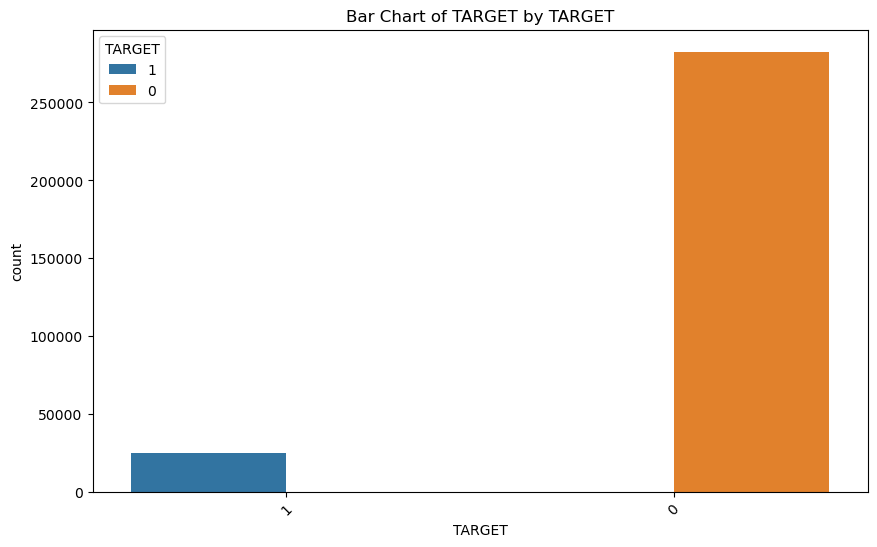

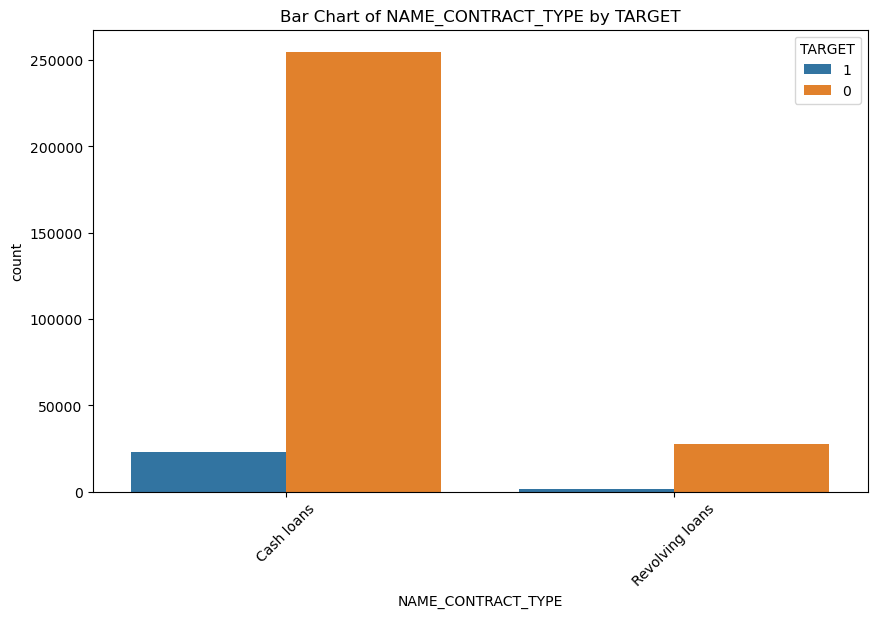

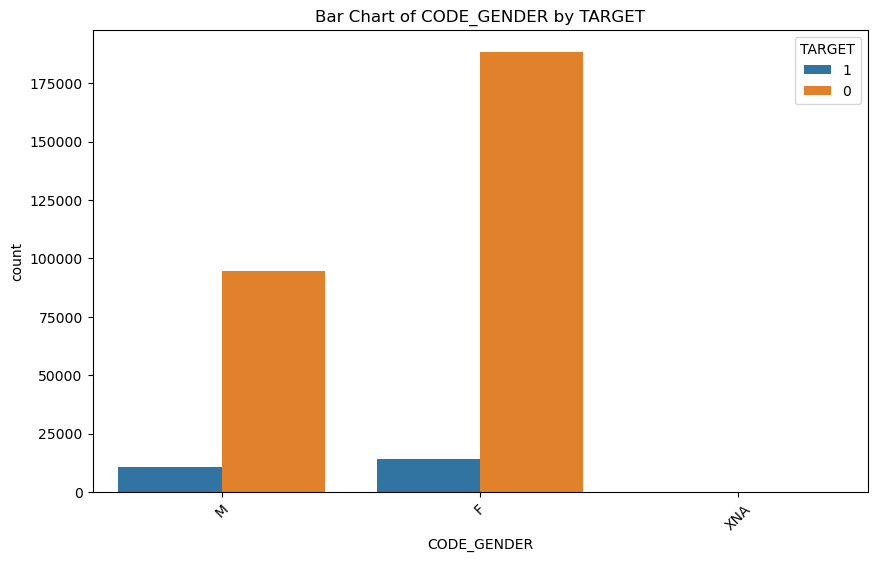

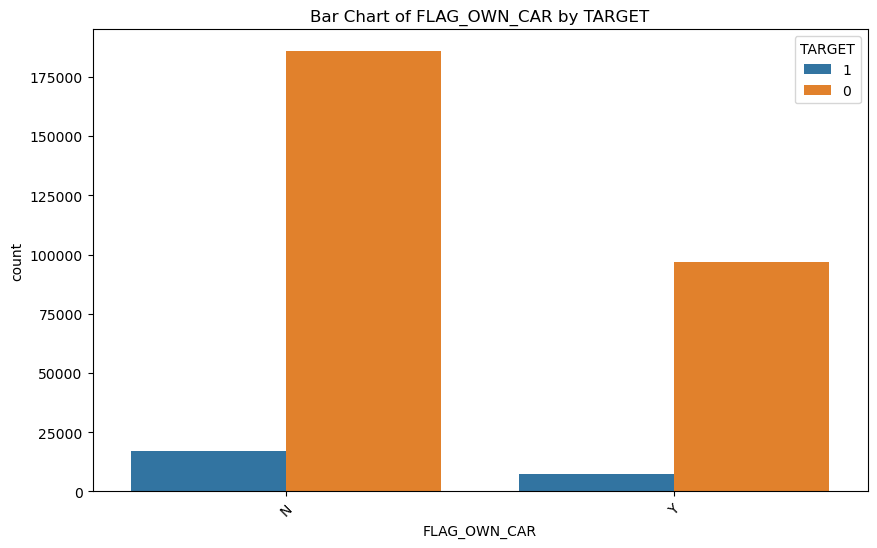

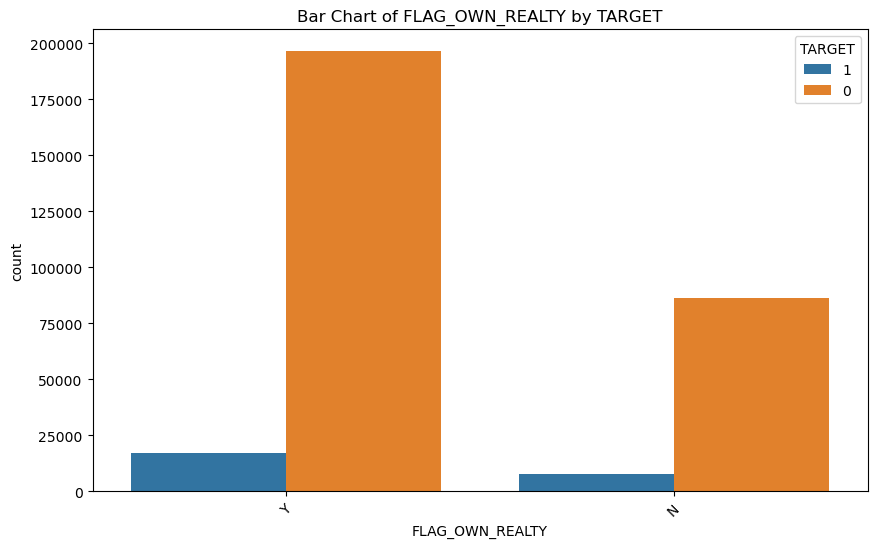

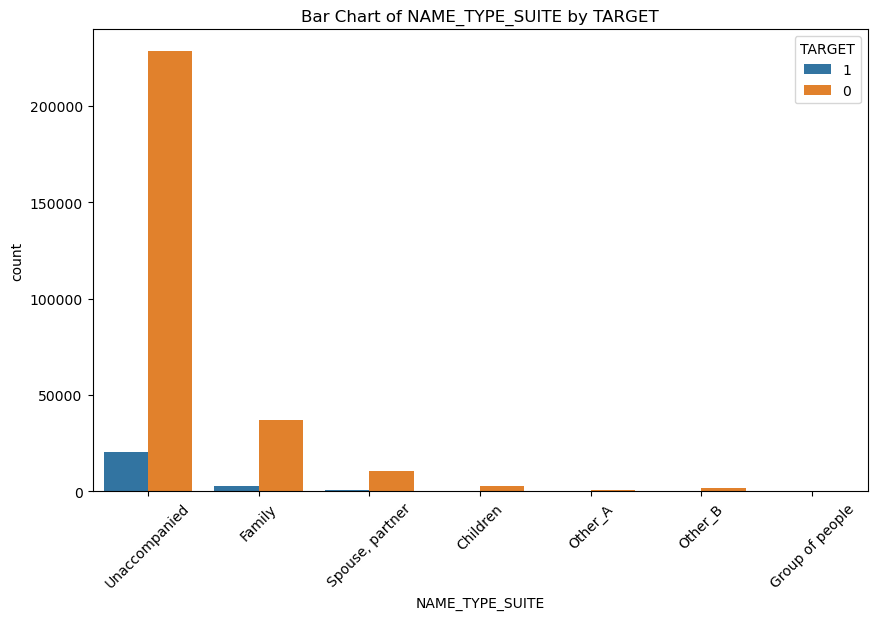

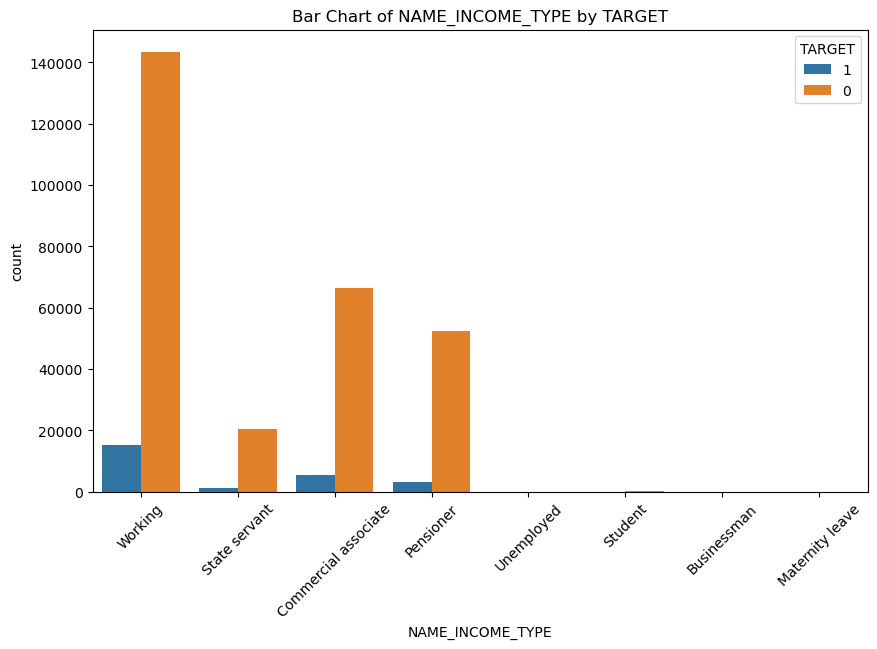

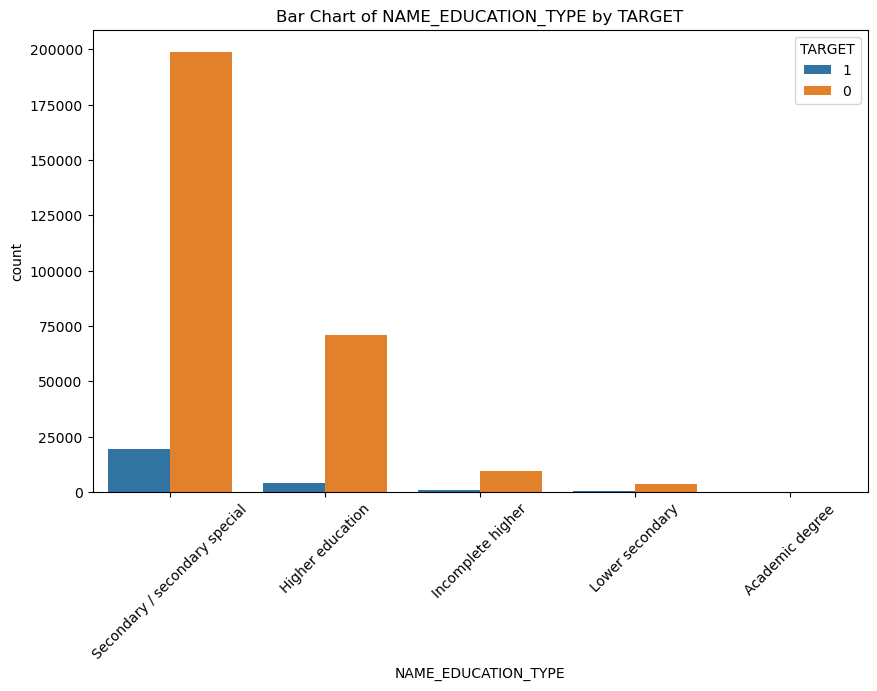

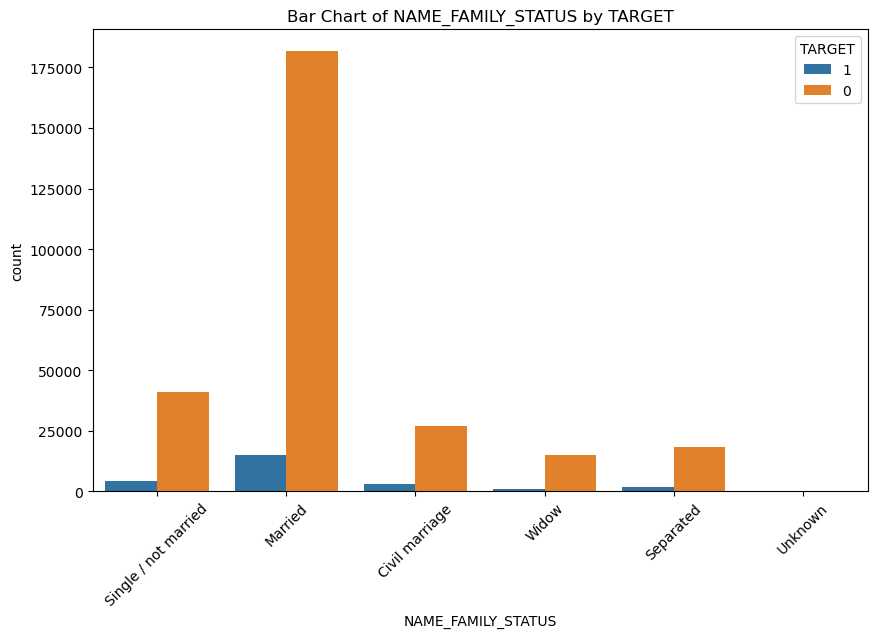

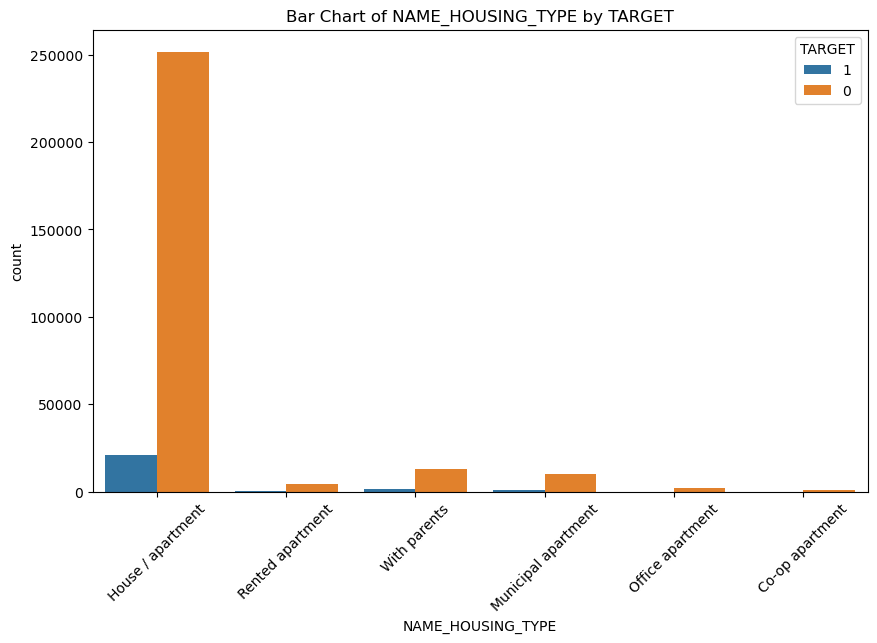

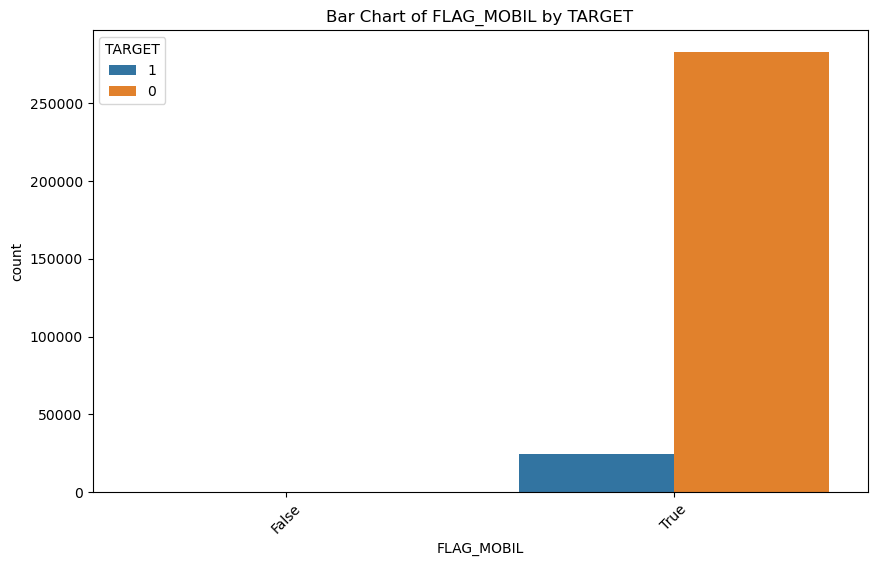

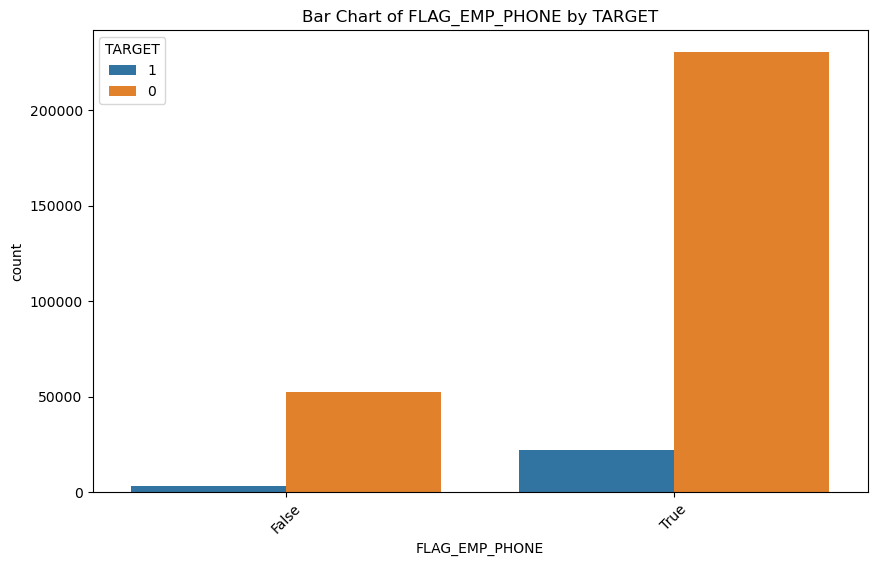

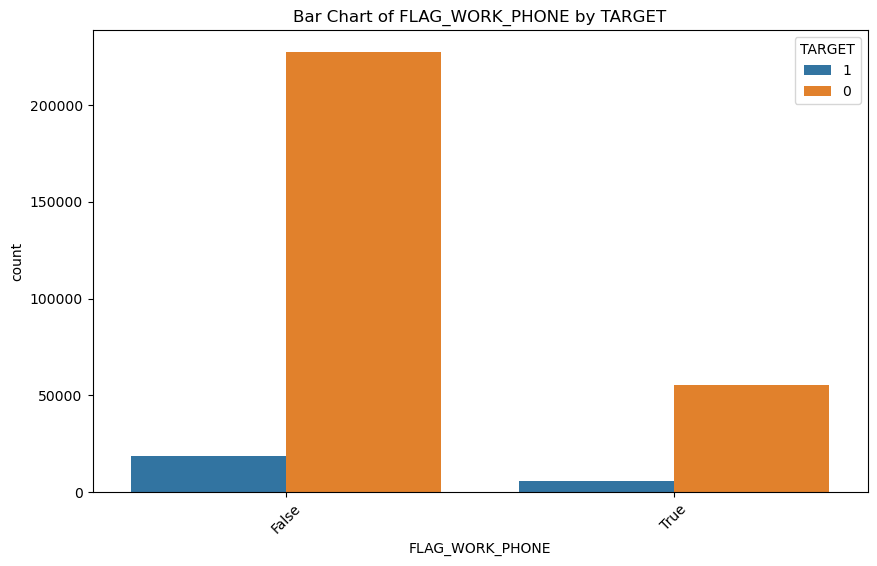

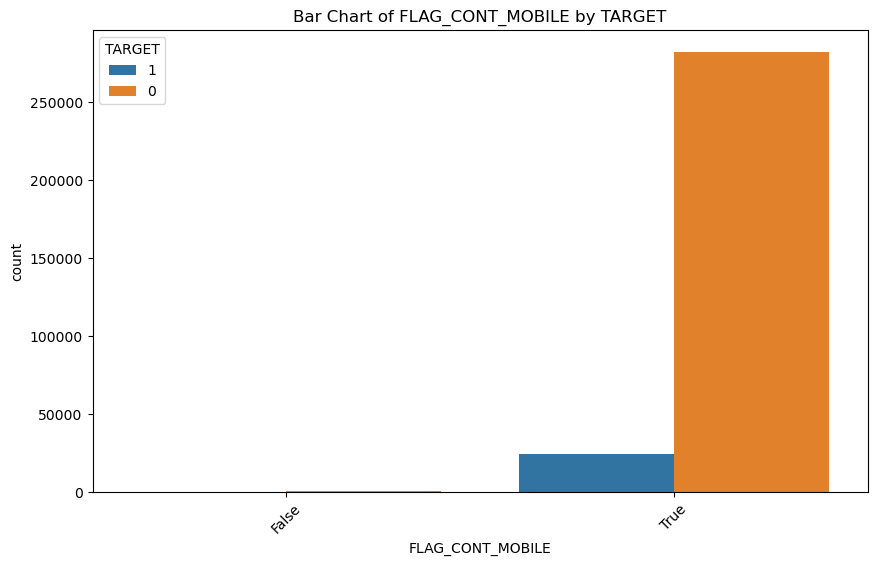

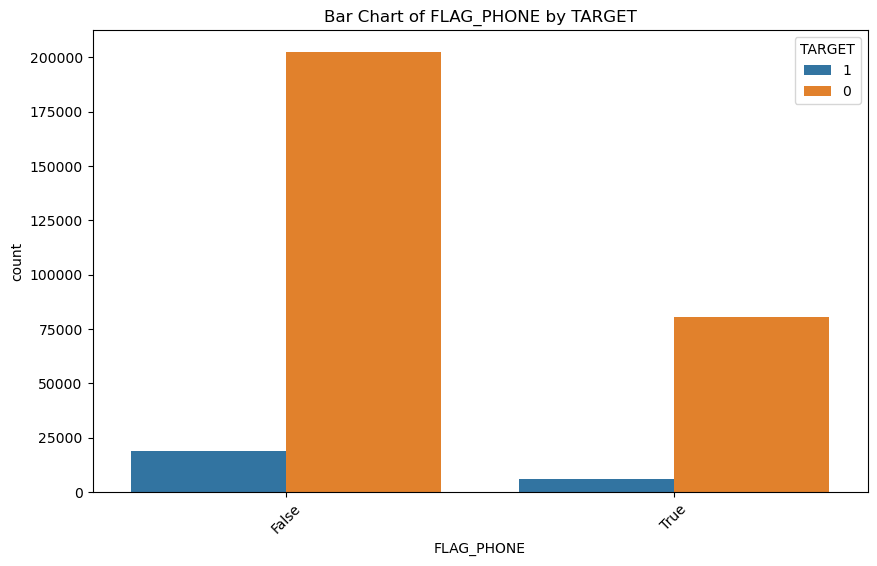

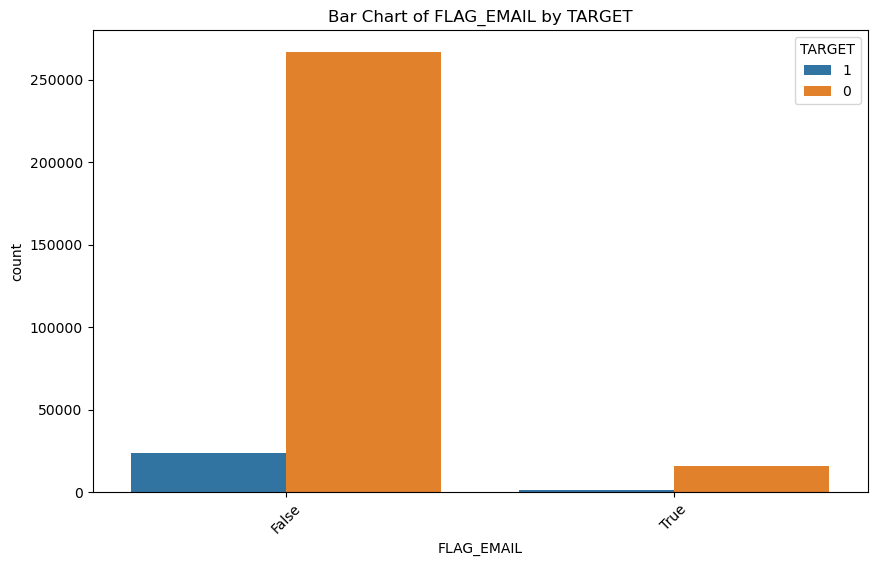

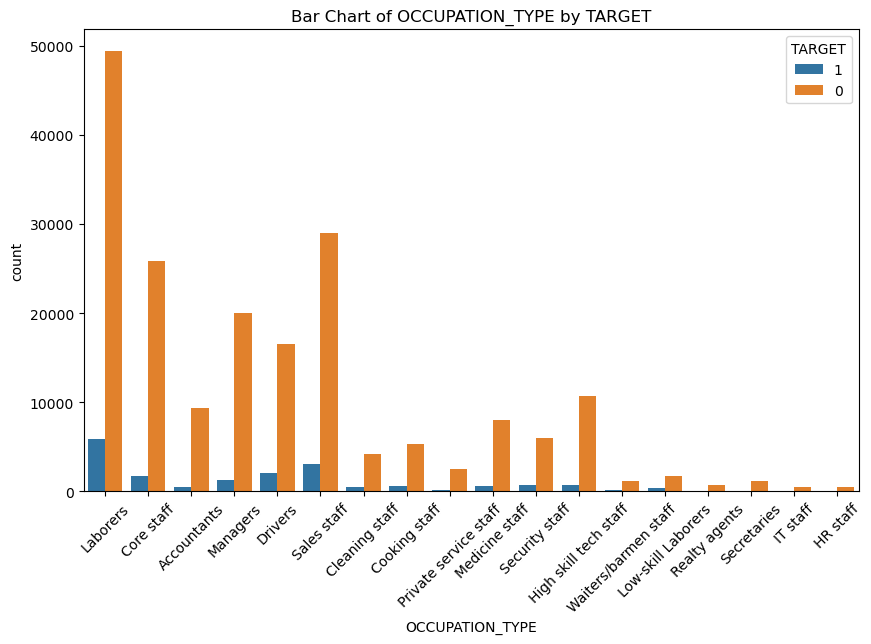

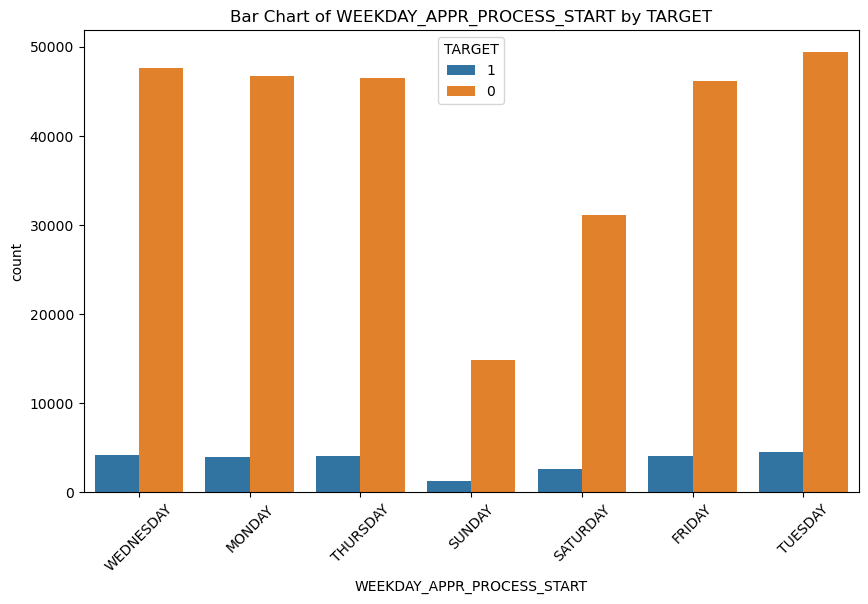

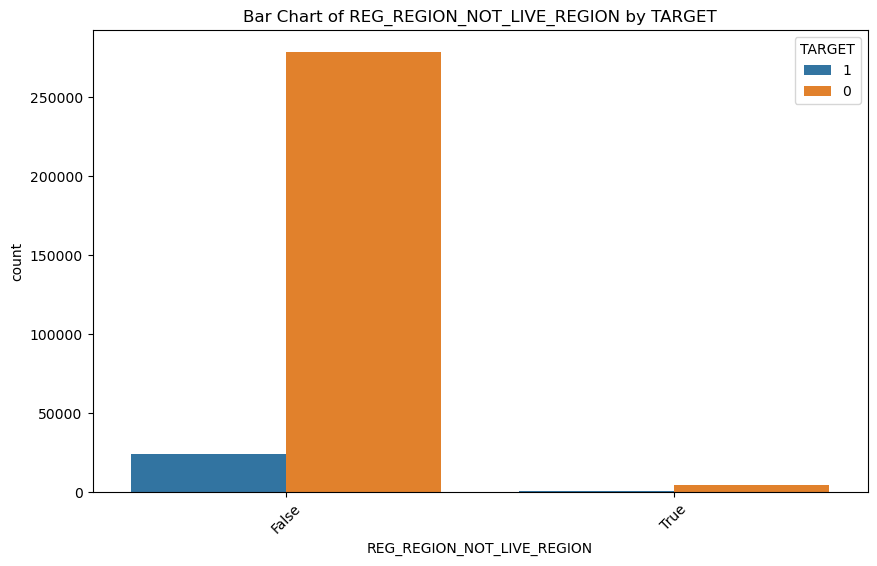

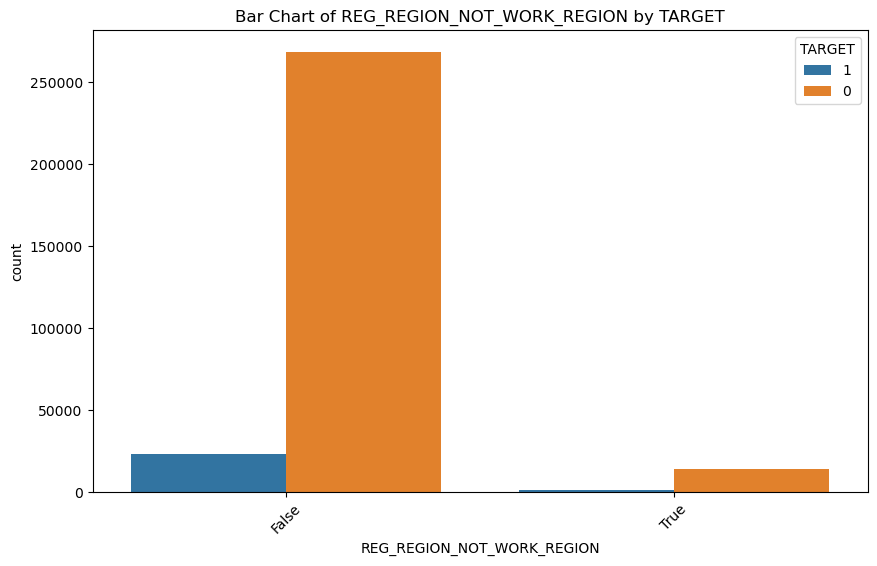

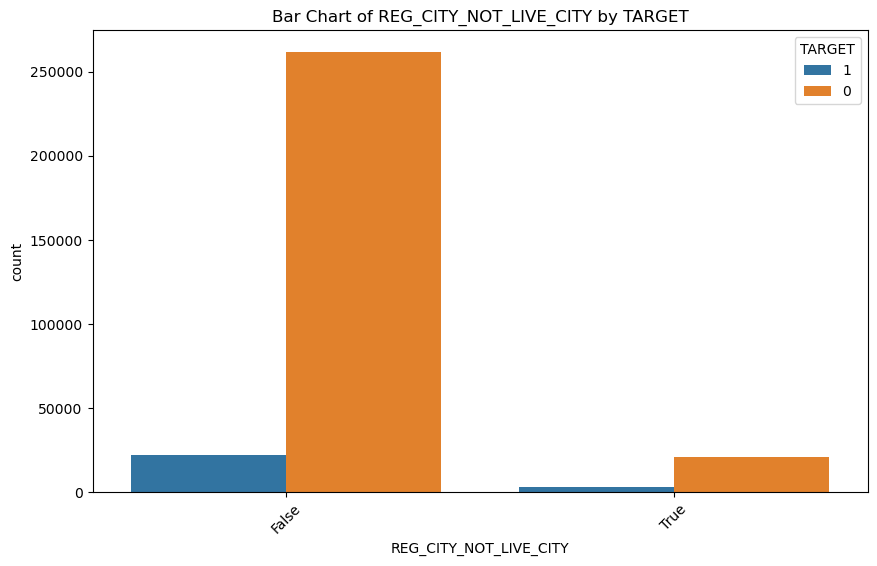

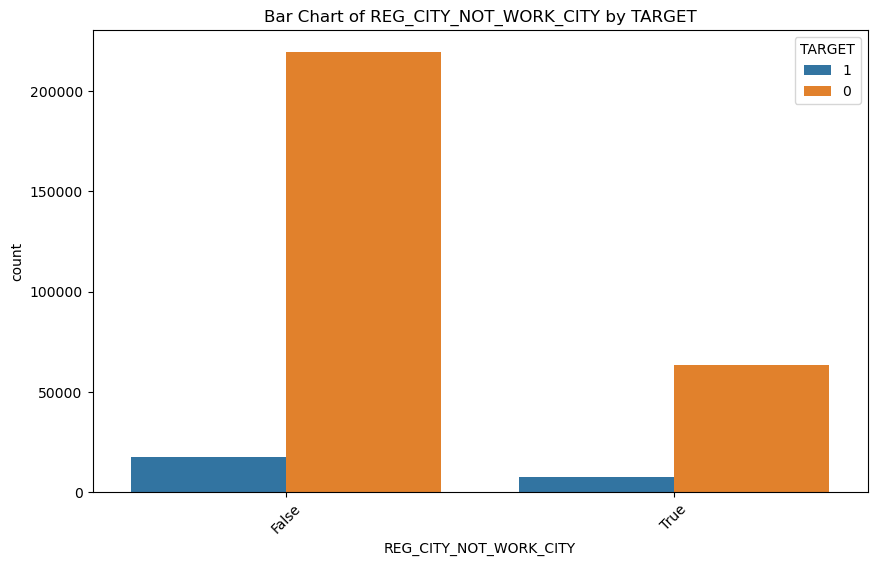

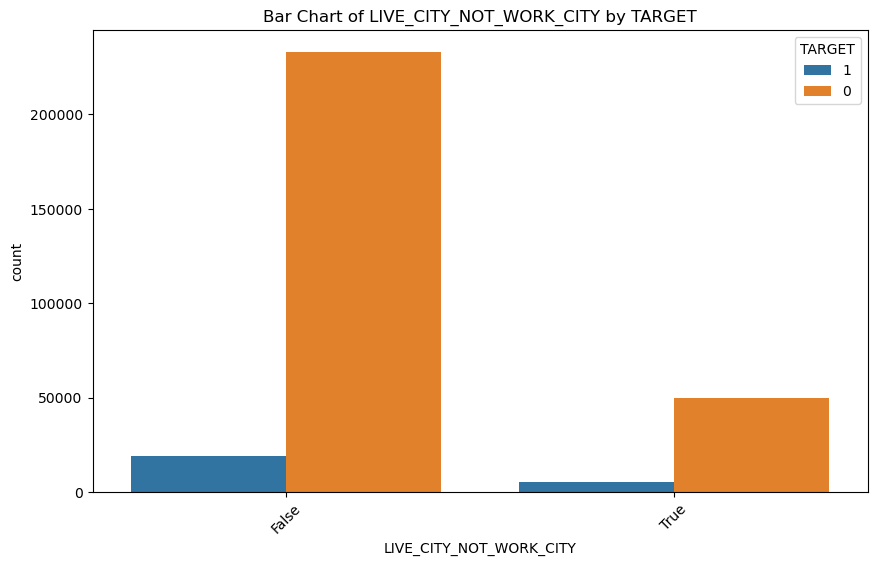

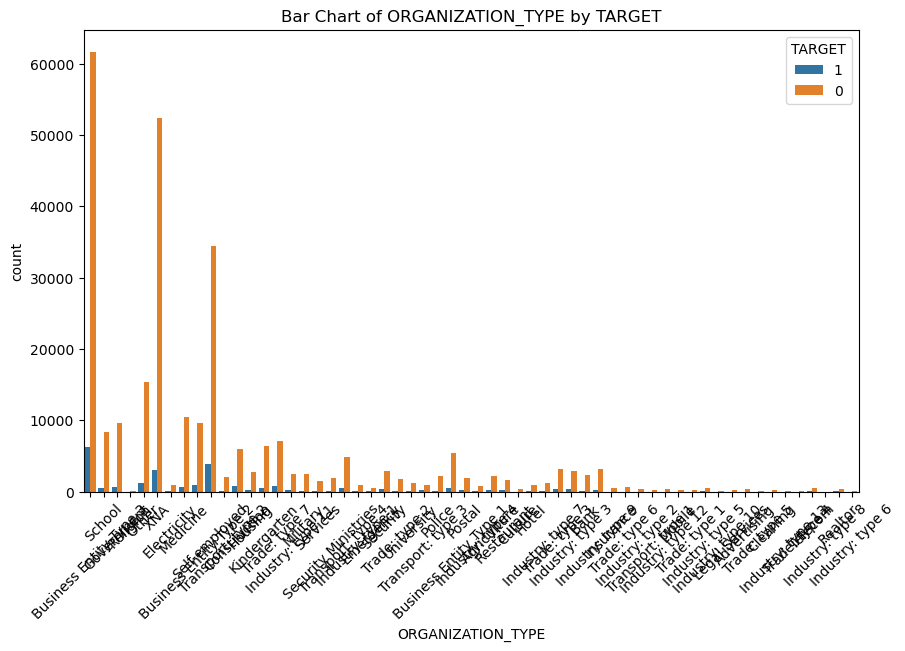

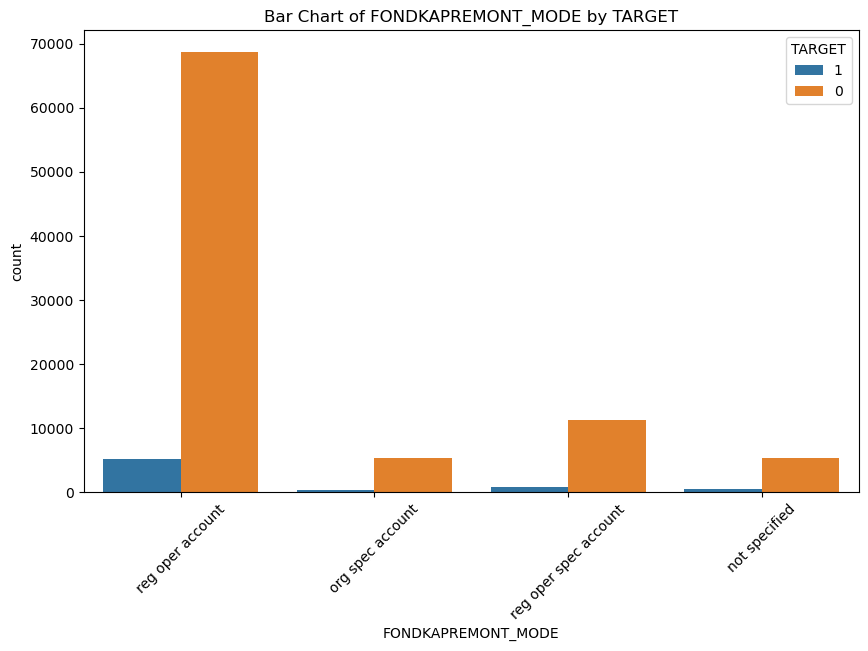

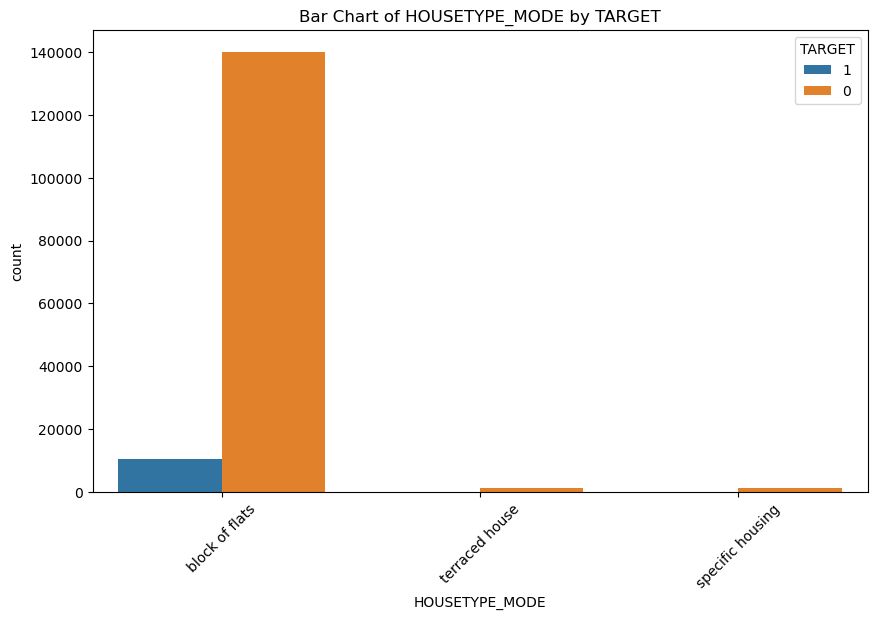

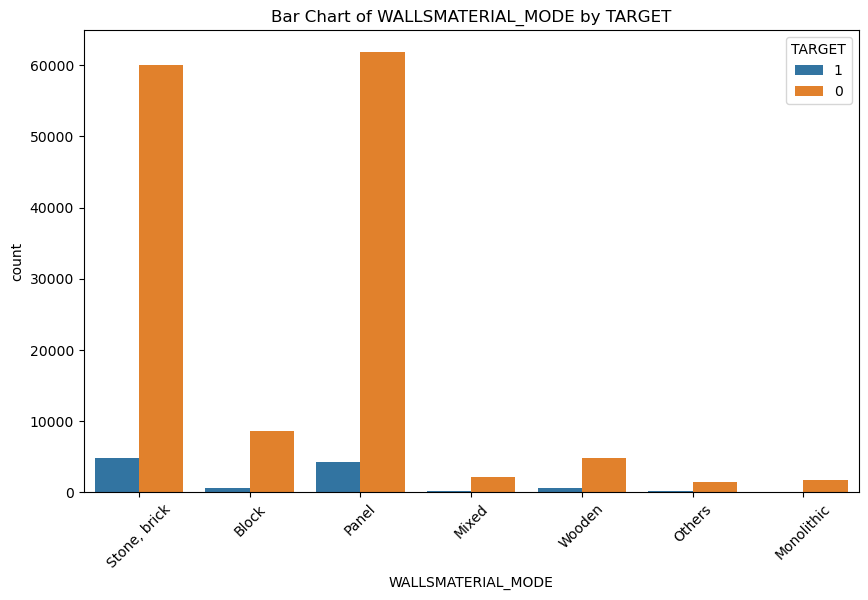

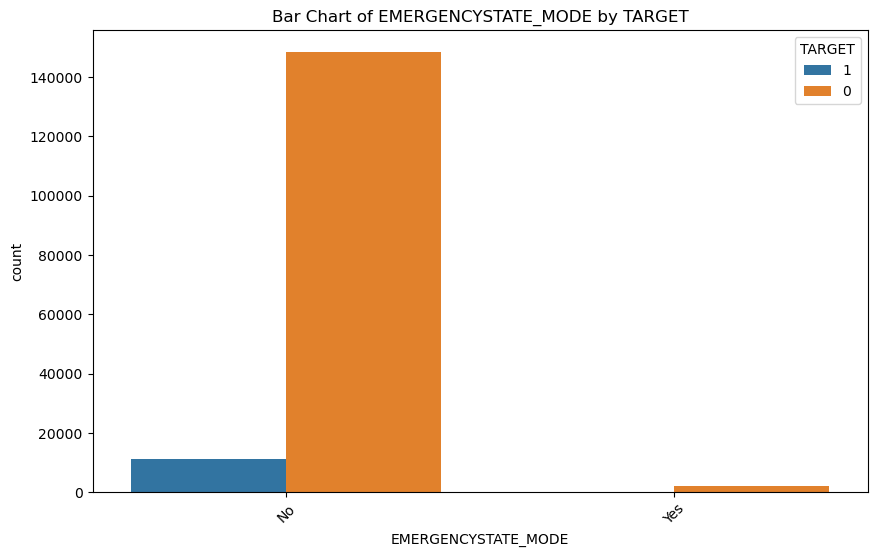

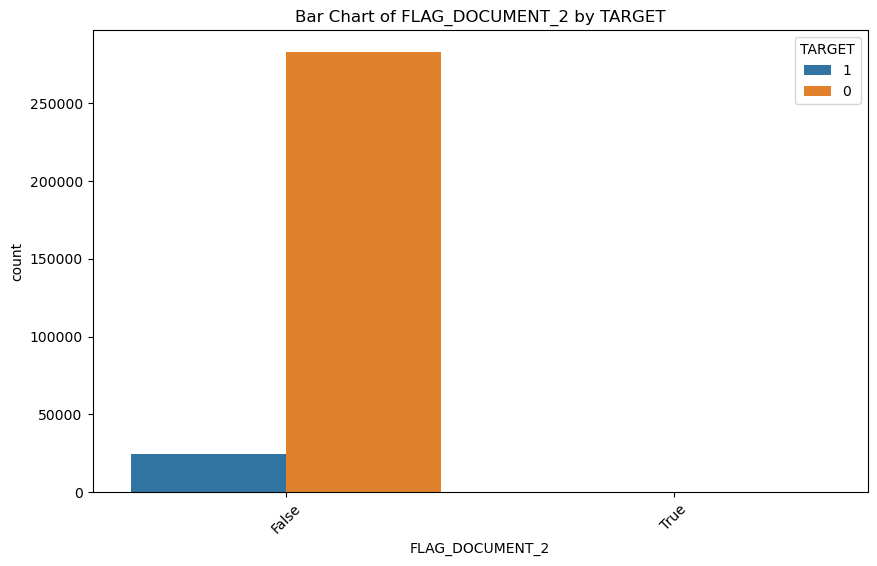

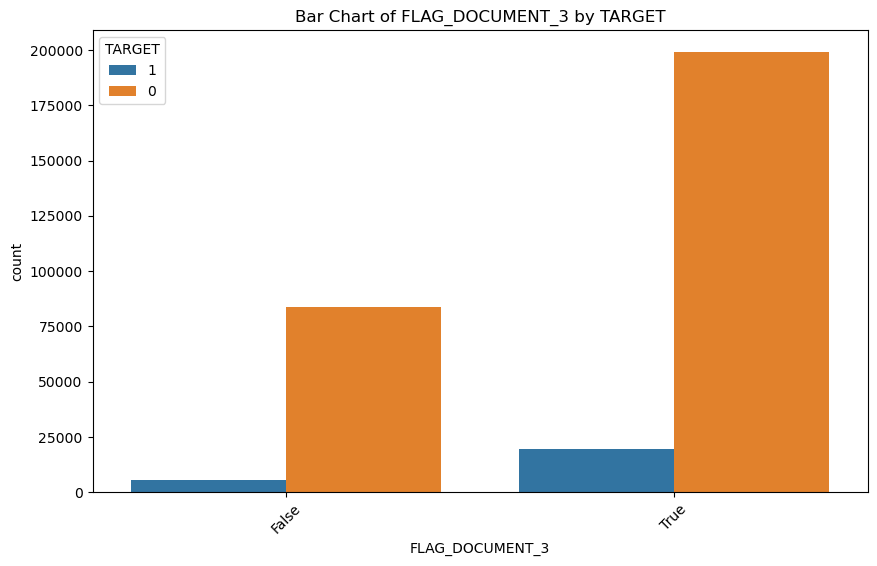

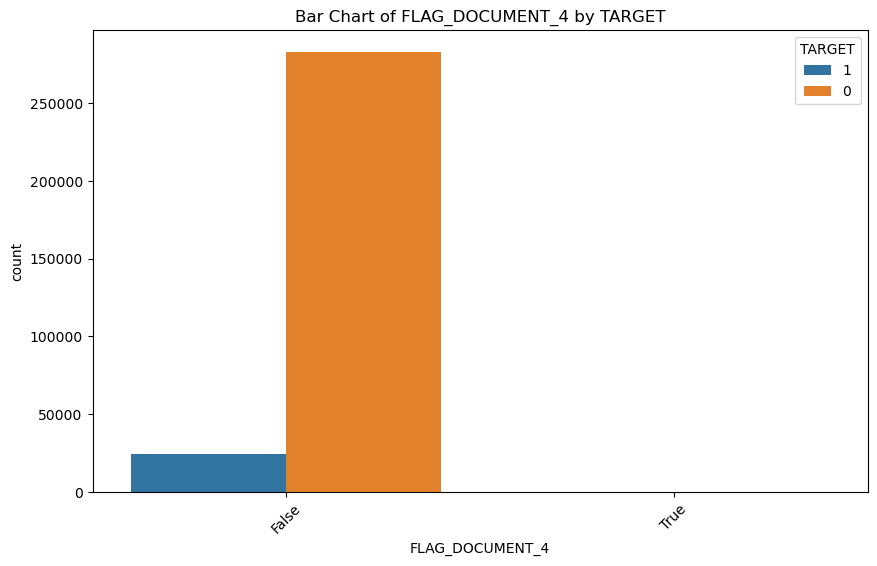

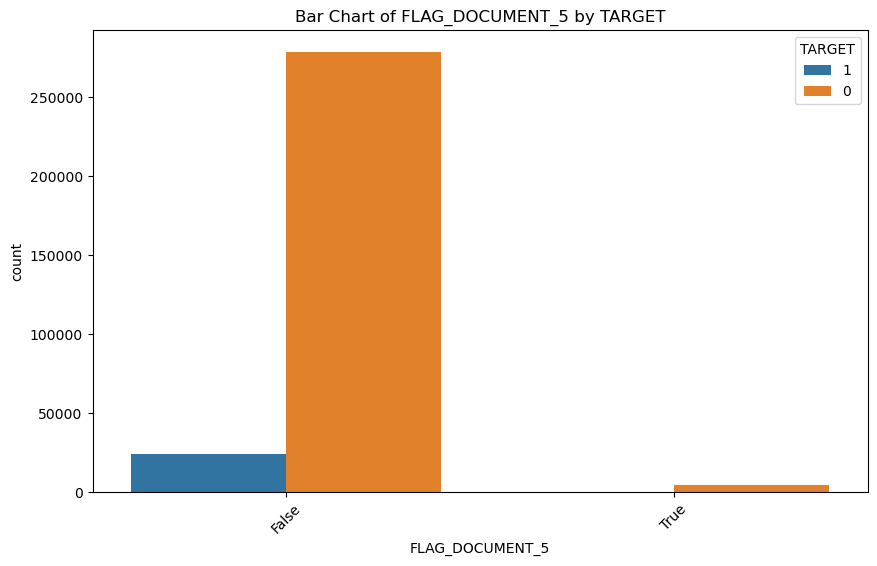

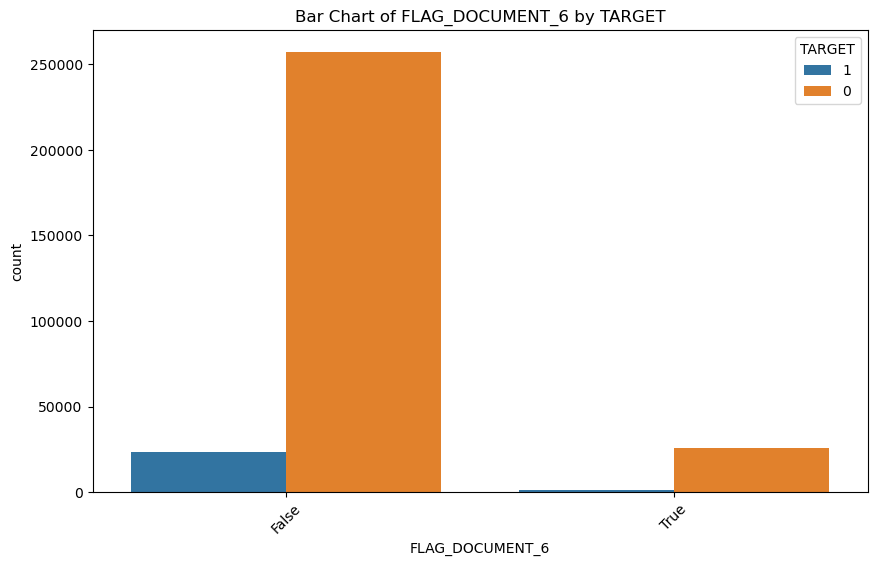

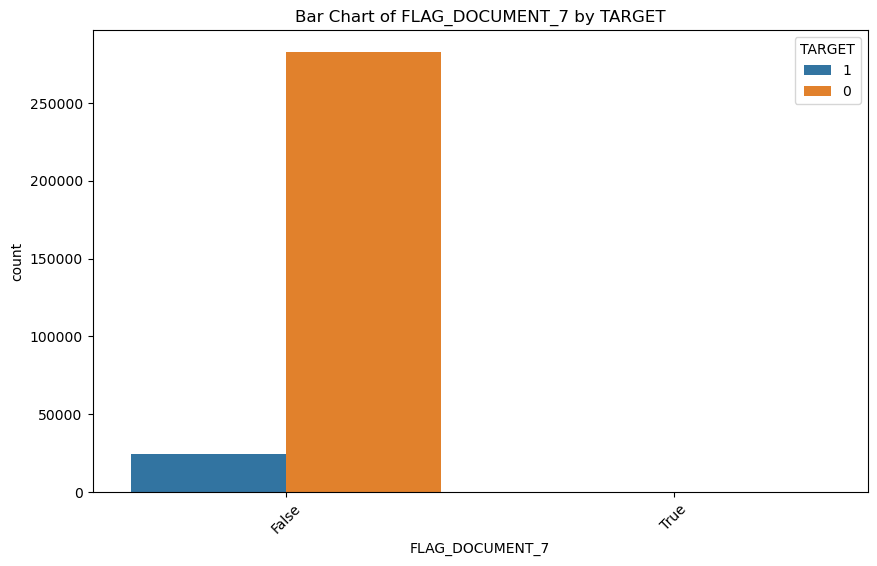

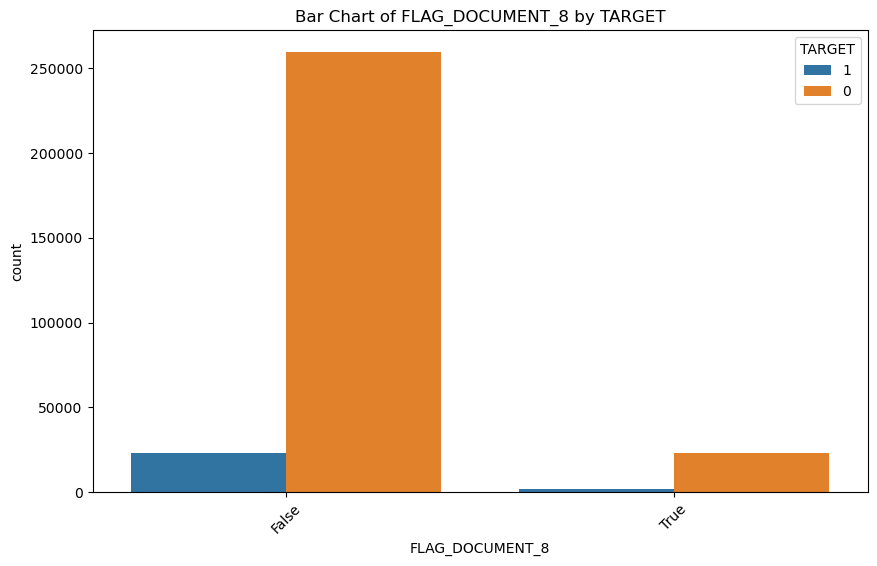

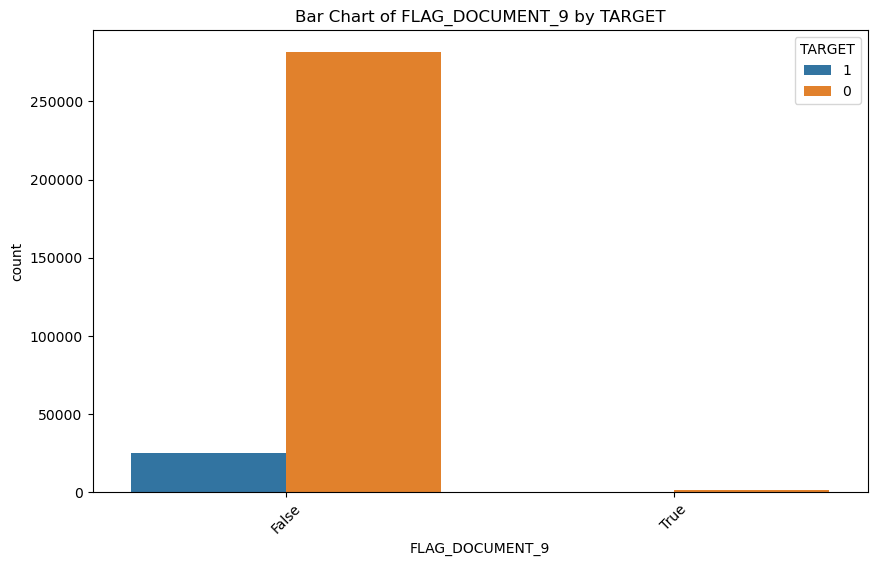

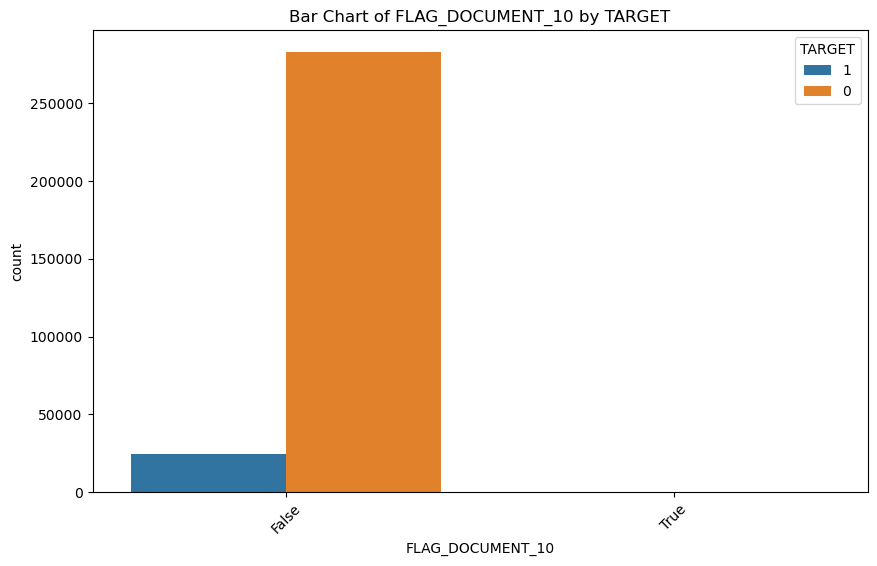

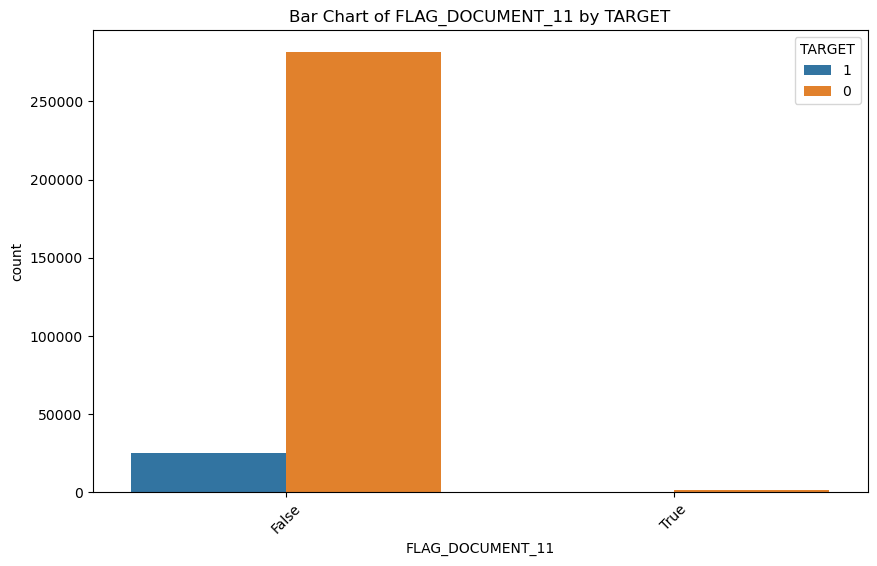

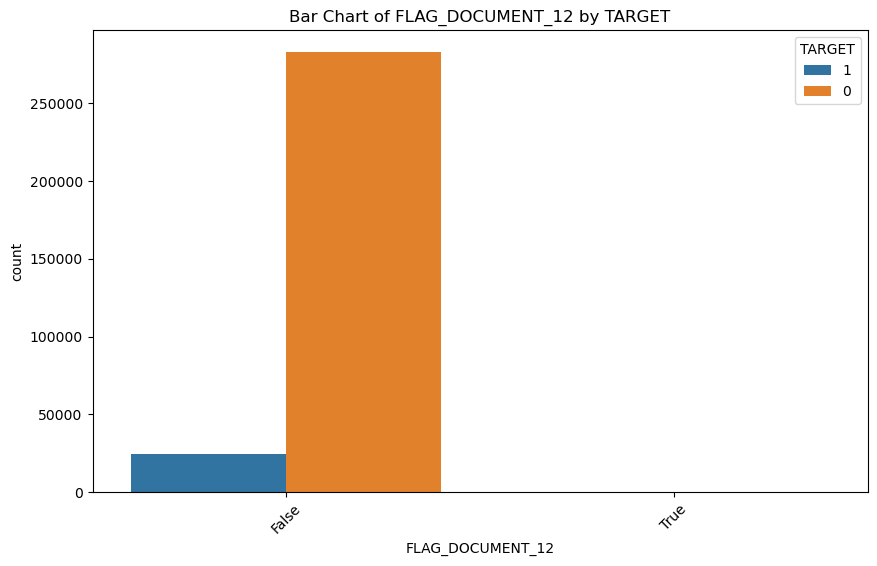

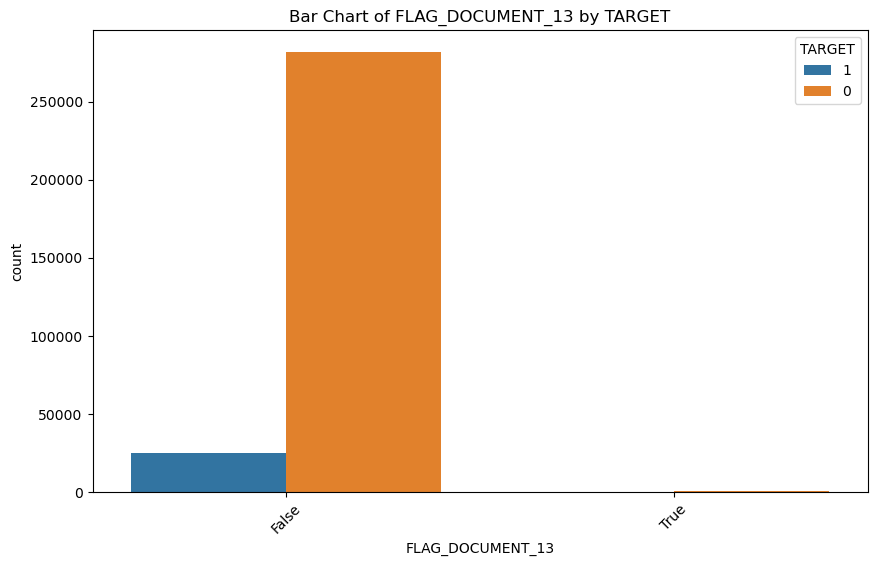

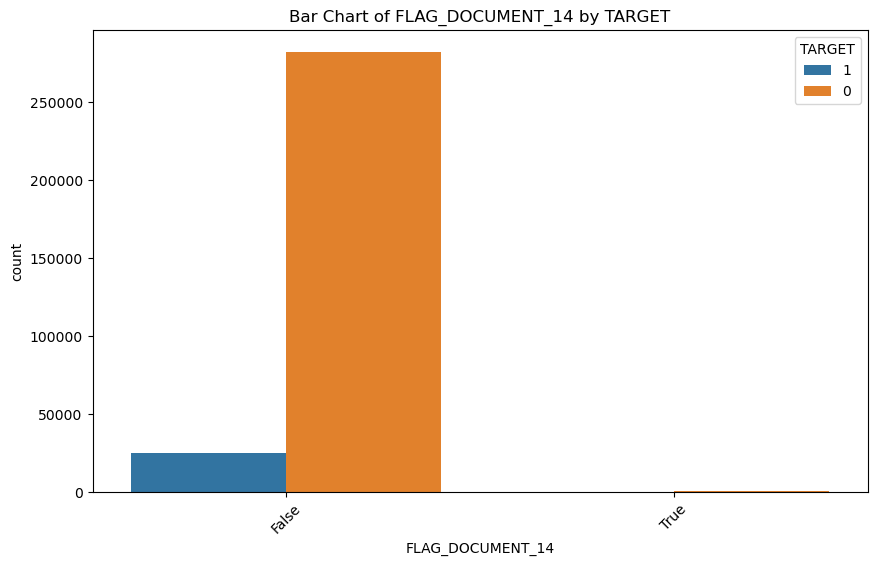

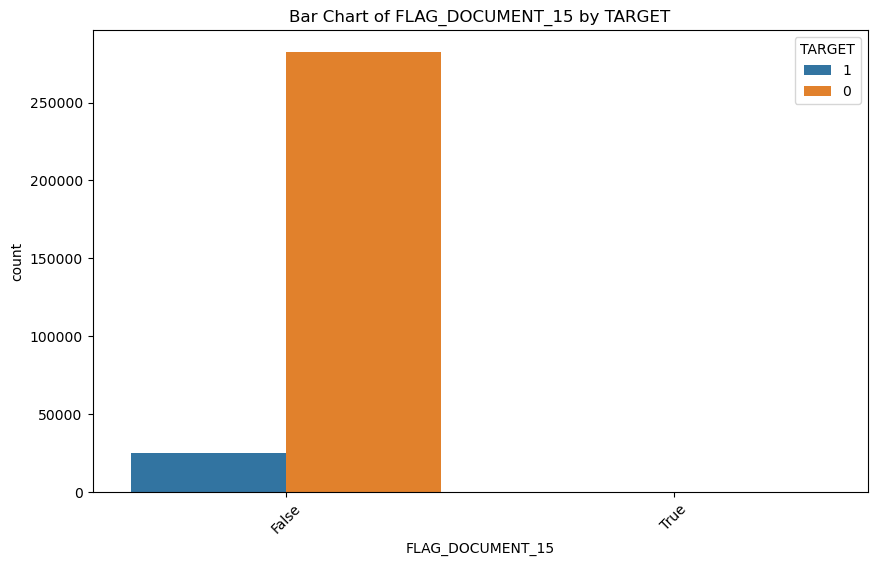

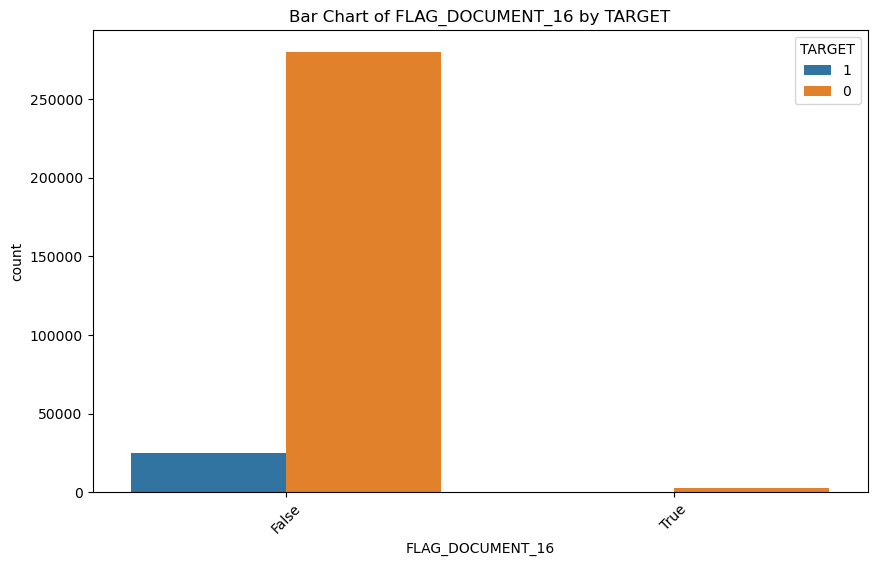

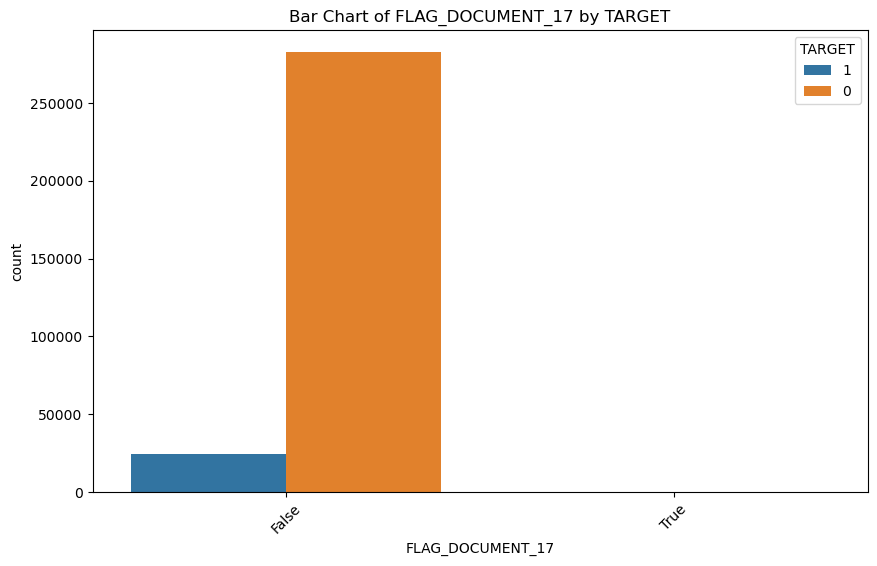

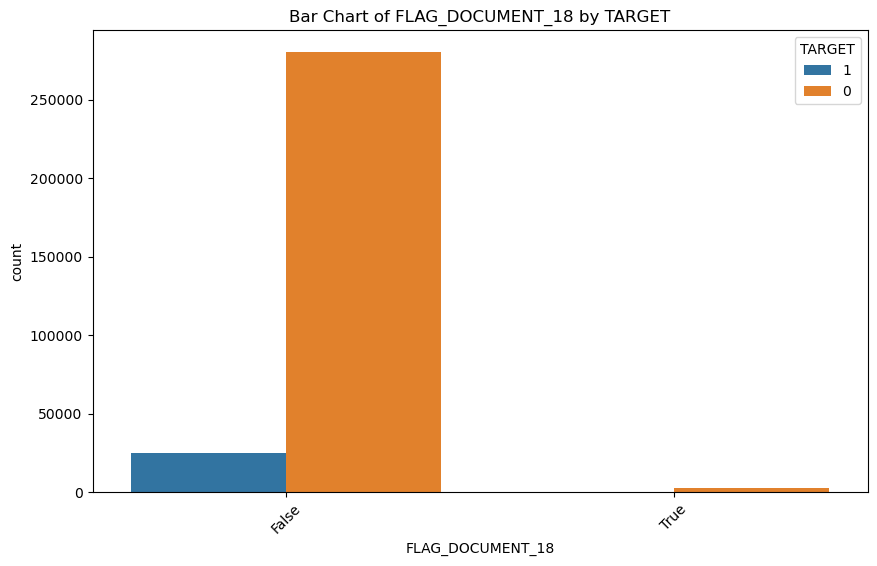

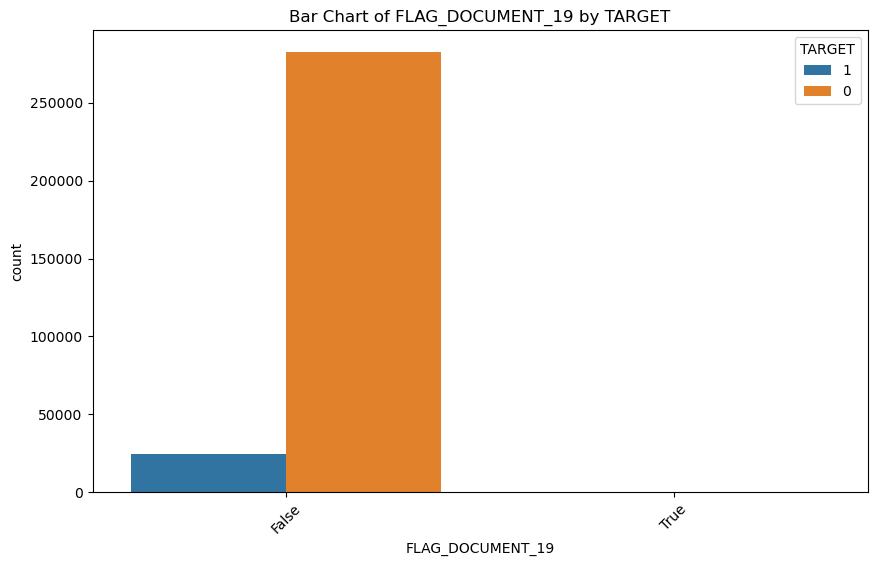

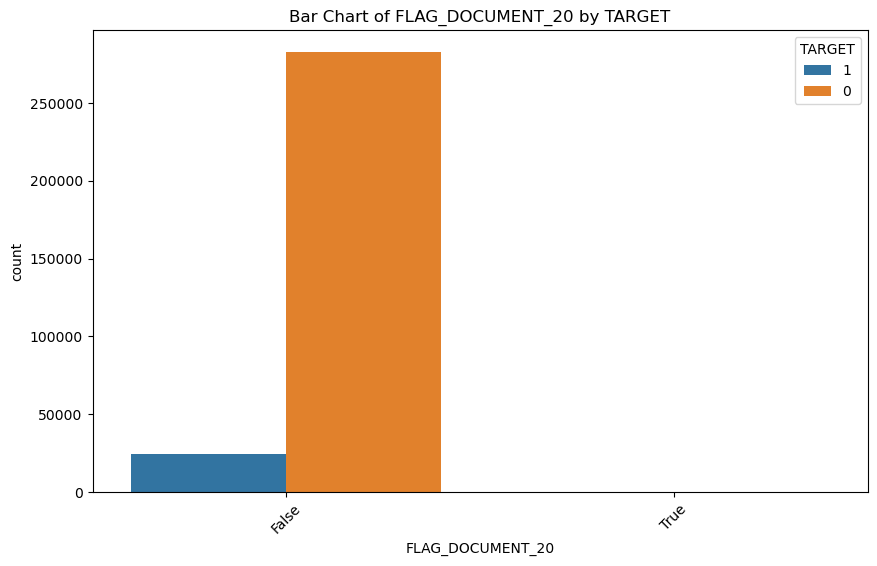

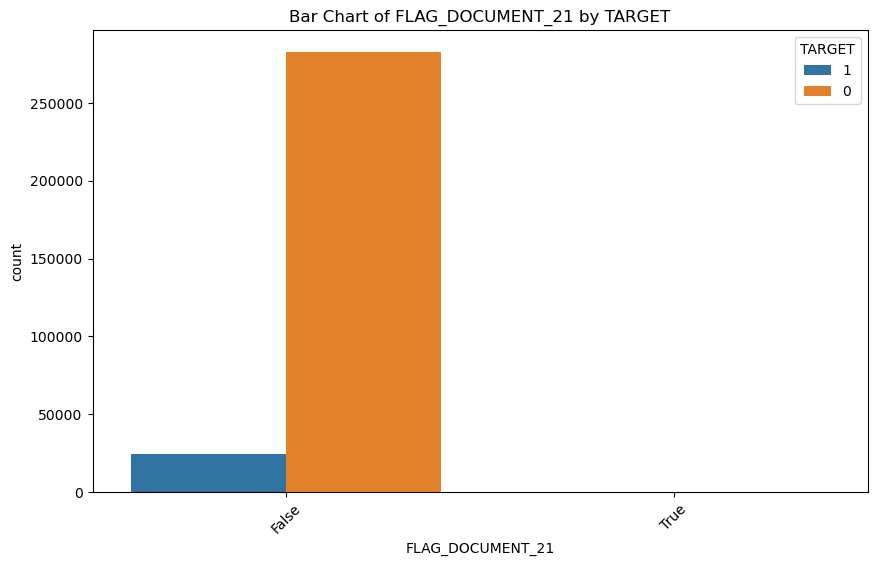

<IPython.core.display.Javascript object>

In [ ]:
generate_explorative_plots(application_train, "TARGET")

When separating numerical features in the application_train dataset based on the payment delay issue (the target variable), we observed outliers across all features. A key part of the classification exercise should be a comprehensive outlier analysis. However, for the sake of time, we will focus on a few features that may not indicate typical outliers but rather incorrect data entries.

For example, the Days Employed feature contains unusually large positive values, despite the boxplot indicating that time-related information is generally stored as negative values (relative to the application date). We aim to gain a better understanding of these distributions and potentially incorrect data points through Sweetviz reports. This tool will help us quickly identify patterns, outliers, and relationships within the data, making it easier to understand the dataset and prepare it for modeling.

### Understanding Data and Its Dependencies
It is important to ensure that no information about loans being classified in the application dataset is present in other datasets, with the exception of the bureau datasets, which provide historical credit information from other financial institutions. The primary goal is to prevent data leakage, ensuring that the data used for training the model remains independent.

In [ ]:
sk_id_curr_train_set = set(application_train["SK_ID_CURR"])

datasets_with_sk_id_prev = {
    "pos_cash_balance": pos_cash_balance,
    "credit_card_balance": credit_card_balance,
    "previous_application": previous_application,
    "installments_payments": installments_payments,
}

for dataset_name, dataset in datasets_with_sk_id_prev.items():
    sk_id_prev_set = set(dataset["SK_ID_PREV"])
    matching_train = sk_id_curr_train_set.intersection(sk_id_prev_set)

    print(f"\nDataset: {dataset_name}")
    print(f"Number of matching ids from train set: {len(matching_train)}")


Dataset: pos_cash_balance
Number of matching ids from train set: 0

Dataset: credit_card_balance
Number of matching ids from train set: 0

Dataset: previous_application
Number of matching ids from train set: 0

Dataset: installments_payments
Number of matching ids from train set: 0


<IPython.core.display.Javascript object>

## EDA using sweetviz

In [ ]:
report = sv.analyze(application_train, target_feat="TARGET")
report.show_html("application_train_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report application_train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


8% of all applications (out of more than 307,000) have experienced difficulties with loan repayments, indicating that our target feature will be imbalanced. Additionally, 90% of all applications are for cash loans.

When analyzing demographic data, 66% of applicants are women, with 4 entries missing gender information. Most applicants do not have children, with an average of 0.4 children per applicant and a median of 0. This distribution is heavily right-skewed. Interestingly, there is a correlation between having more children and a higher likelihood of loan payment delays. This makes sense intuitively, as family income must be shared among more members. However, this relationship is not as clear in the total income distribution, which is highly skewed (with a skewness indicator of 392). We will further investigate this relationship since income should be a significant factor in our classification goals.

One important observation is that over 55,000 values in the Days Employed feature are recorded as 365,243, which suggests these entries represent missing or infinite data.

Features related to housing information also have many missing values and are highly skewed.

Another crucial point is the ext_sources feature, which essentially represents credit scores. We can observe that lower credit scores are associated with a higher proportion of applicants experiencing payment issues. However, Source 1 is missing in about half of it's points.

In [ ]:
bureau_report = sv.analyze(bureau)
bureau_report.show_html("bureau_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report bureau_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


This dataset contains information on all previous loans provided by other financial institutions that were reported to the Credit Bureau for clients also present in the application_train sample.

We observe that the majority of these loans have already been closed (63%), and only 21 out of 1.7 million loans are classified as bad debts. Additionally, about 37% of the loans are still active.

In [ ]:
bureau_balance_report = sv.analyze(bureau_balance)
bureau_balance_report.show_html("bureau_balance_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report bureau_balance_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


This additional dataset can be combined with the bureau data, as it contains information on the monthly balances of previous credits reported to the Credit Bureau. Each row represents a specific month in the history of every previous credit and provides details such as days past due (DPD).

We observe that most loans in this dataset are already closed, while a significant portion have an unknown status, and many loans have not passed their due dates. However, the information regarding loans that did experience delays could be highly valuable for predicting payment delays in the Home Credit dataset.

In [ ]:
pos_cash_balance_report = sv.analyze(pos_cash_balance)
pos_cash_balance_report.show_html("pos_cash_balance_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report pos_cash_balance_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


This dataset provides monthly balance snapshots of previous point-of-sale and cash loans that the applicant had with Home Credit. Each row represents a month of history for every previous credit related to loans in the sample. The distribution of monthly balances shows a higher concentration of values in more recent months, typically between -1 to -20 months before the application date.

Notably, 91% of the contracts in this dataset are still active, indicating that most contracts recorded are ongoing or have not yet reached completion or termination.

Only a small amount of data is missing (1%), and this is limited to the CNT_INSTALMENT and CNT_INSTALMENT_FUTURE features.

In [ ]:
credit_card_balance_report = sv.analyze(credit_card_balance)
credit_card_balance_report.show_html("credit_card_balance_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report credit_card_balance_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


This dataset contains the monthly balances of previous credit cards that the applicant holds with Home Credit. Each row represents a specific month in the credit card's history.

Several features in this dataset contain missing values, but only up to a maximum of 20%. One particular feature, AMT_DRAWINGS_ATM_CURRENT, has a single negative value, which might be a faulty entry. While other balance-related features also show negative values, but these may be valid.

Given that the majority of numerical features are not normally distributed and are highly skewed, we plan to handle this issue by applying log transformations, which should help manage skewness and improve the distribution of the data.

In [ ]:
previous_application_report = sv.analyze(previous_application)
previous_application_report.show_html("previous_application_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report previous_application_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
---
(likely due to only having a single row, containing non-NaN values for both correlated features)
Affected correlations:['RATE_INTEREST_PRIMARY/DAYS_FIRST_DRAWING', 'RATE_INTEREST_PRIVILEGED/DAYS_FIRST_DRAWING', 'DAYS_FIRST_DRAWING/RATE_INTEREST_PRIMARY', 'DAYS_FIRST_DRAWING/RATE_INTEREST_PRIVILEGED']


The data on previous applications for Home Credit loans for clients in the sample reveals a few key insights. The features RATE_INTEREST_PRIMARY and RATE_INTEREST_PRIVILEGED have over 99% missing data, indicating that these features are unlikely to provide meaningful information and, therefore, will not be aggregated in our analysis.

Unfortunately, features such as DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, and DAYS_TERMINATION represent time-related information relative to the application date of the current loan. While these features offer valuable insights into the timeline of previous loans or credit applications, they require extensive feature engineering to be fully used. One approach we plan to implement is categorizing these values into bins to better capture patterns and trends in the data.

In [ ]:
installments_payments_report = sv.analyze(installments_payments)
installments_payments_report.show_html("installments_payments_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report installments_payments_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


This dataset is relatively clean, with only a few missing values in the DAYS_ENTRY_PAYMENT feature. The repayment history data is expected to be highly informative based on intuition. We will log-transform the highly skewed features to address distribution issues and derive a payment delay variable using the DAYS_ENTRY_PAYMENT and DAYS_INSTALMENT features. This derived variable should provide valuable insights into the applicant's repayment history and behavior.

### Income and Payment Delay Analysis
In this section, we will address a key question raised during the exploratory data analysis (EDA) of the application_train data sample:

**Default Risk and Income Distribution**: We will examine how income distribution affects the likelihood of payment delays, analyzing whether certain income groups are more prone to defaulting on loans or experiencing delayed payments.

In [ ]:
application_train_copy = application_train.copy()

<IPython.core.display.Javascript object>

In [ ]:
print(application_train_copy["AMT_INCOME_TOTAL"].isnull().sum())

0


<IPython.core.display.Javascript object>

In [ ]:
application_train_copy["TARGET"] = application_train_copy["TARGET"].astype(int)

<IPython.core.display.Javascript object>

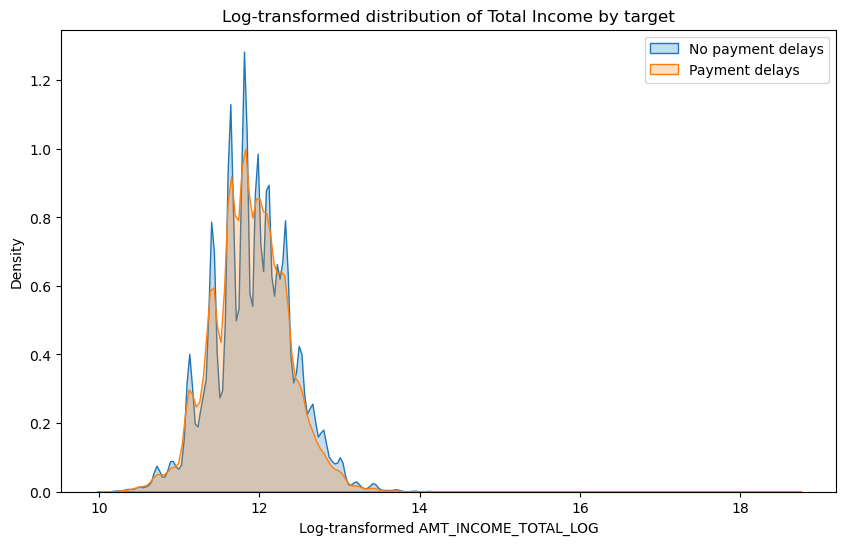

<IPython.core.display.Javascript object>

In [ ]:
application_train_copy["AMT_INCOME_TOTAL_LOG"] = np.log1p(
    application_train_copy["AMT_INCOME_TOTAL"]
)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    application_train_copy[application_train_copy["TARGET"] == 0][
        "AMT_INCOME_TOTAL_LOG"
    ],
    label="No payment delays",
    shade=True,
)
sns.kdeplot(
    application_train_copy[application_train_copy["TARGET"] == 1][
        "AMT_INCOME_TOTAL_LOG"
    ],
    label="Payment delays",
    shade=True,
)
plt.title("Log-transformed distribution of Total Income by target")
plt.xlabel("Log-transformed AMT_INCOME_TOTAL_LOG")
plt.ylabel("Density")
plt.legend()
plt.show()

There is a visible overlap between the income distributions of these two groups, suggesting that the income distributions for applicants with and without payment delays are not drastically different. However, the density for the "No payment delays" group appears to be slightly higher in certain areas, which could indicate that income-related factors are associated with payment behavior. This is an intuitive assumption, but one we were uncertain about during the EDA phase. Therefore, it becomes an interesting question, as income could potentially be a key factor in predicting loan payment issues. Nevertheless, we need to apply more quantitative methods to verify this assumption, as the visual results are not definitive. Thus, we are forming the null hypothesis that there is no difference between the groups, and the alternative hypothesis that there is.

**Null Hypothesis (H0)**: There is no significant difference in the distribution of total annual income between applicants who experience payment delays (Target 1) and those who do not (Target 0).

**Alternative Hypothesis (HA)**: Applicants who experience payment delays (Target 1) have a significantly lower total annual income compared to those who do not (Target 0).

**Significance Level**: The significance level (𝛼) is set to 0.05, meaning results will be considered statistically significant if the p-value is less than 0.05.

To test these hypotheses using Student's t-test, we need to verify the underlying assumptions of normality and homoscedasticity (equal variances).

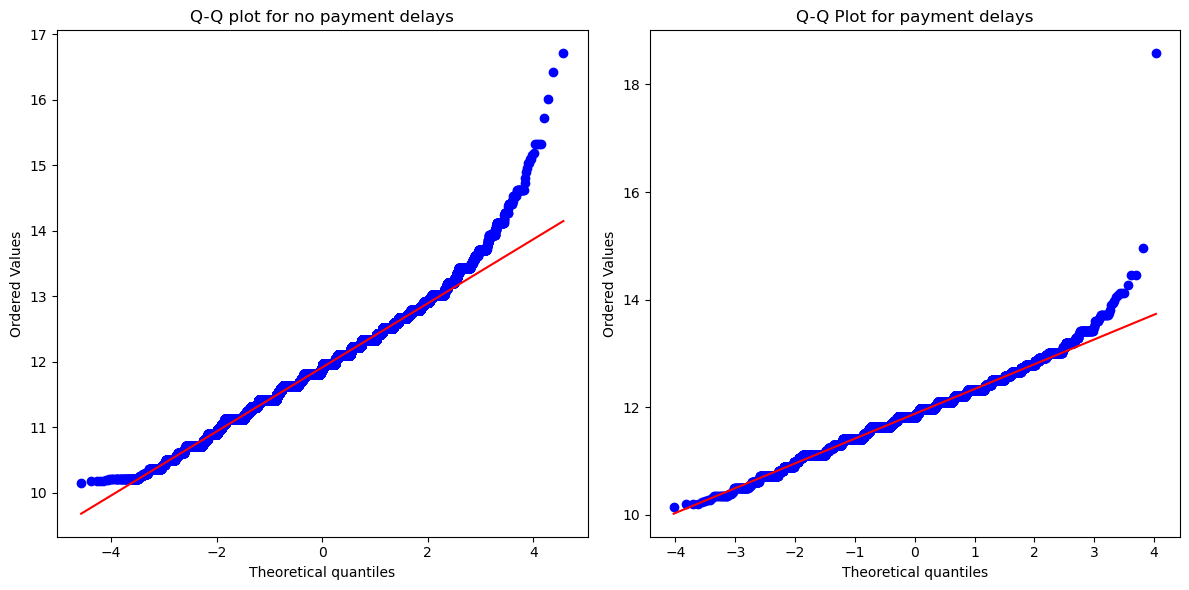

<IPython.core.display.Javascript object>

In [ ]:
non_default = application_train_copy[application_train_copy["TARGET"] == 0][
    "AMT_INCOME_TOTAL_LOG"
]
default = application_train_copy[application_train_copy["TARGET"] == 1][
    "AMT_INCOME_TOTAL_LOG"
]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(non_default, dist="norm", plot=plt)
plt.title("Q-Q plot for no payment delays")

plt.subplot(1, 2, 2)
stats.probplot(default, dist="norm", plot=plt)
plt.title("Q-Q Plot for payment delays")

plt.tight_layout()
plt.show()

Q-Q plot results indicate that the distributions deviate from normality, particularly at the tails, suggesting that the data is not perfectly normally distributed.

In [ ]:
levene_stat, levene_p = levene(non_default, default)

print(f"Levenes test statistic: {levene_stat:.3f}")
print(f"p-value: {levene_p:.3f}")

alpha = 0.05
if levene_p < alpha:
    print("Rejecting the null hypothesis: variance is unequal aka heteroscedasticity")
else:
    print("Can't reject the null hypothesis: variances is equal aka homoscedasticity")

Levenes test statistic: 159.555
p-value: 0.000
Rejecting the null hypothesis: variance is unequal aka heteroscedasticity


<IPython.core.display.Javascript object>

Levene's test was conducted to check for equal variances between the target groups.

Test Result:
Statistic = 159.55, p-value = 0.000.

Given these results, we can reject the null hypothesis that the variances between the two groups are equal. Since both assumptions for the t-test (normality and equal variances) are violated, we will use a non-parametric approach: the Mann-Whitney U test. This test is appropriate for comparing the distributions of two independent groups, as it does not assume normality or equal variances.

In [ ]:
u_stat, p_value = mannwhitneyu(non_default, default)

print(f"Mann-Whitney U test statistic: {u_stat:.3f}")
print(f"p-value: {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print(
        "Rejecting the null hypothesis: There is a significant difference in default and non-default groups"
    )
else:
    print(
        "Fail to reject the null hypothesis: There is no significant difference in the default and non-default groups"
    )

Mann-Whitney U test statistic: 3643149145.500
p-value: 0.000
Rejecting the null hypothesis: There is a significant difference in default and non-default groups


<IPython.core.display.Javascript object>

P-value = 0.000

Based on the Mann-Whitney U test results, we reject the null hypothesis. There is a statistically significant difference in the total income between the default and non-default groups.

### Correlation review

In [ ]:
numerical_features = application_train_copy.select_dtypes(
    include=["int64", "float64", "bool"]
)

correlation_with_target = numerical_features.corrwith(application_train_copy["TARGET"])
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
                                 ...   
FLOORSMAX_AVG                 -0.044003
DAYS_EMPLOYED                 -0.044932
EXT_SOURCE_1                  -0.155317
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_3                  -0.178919
Length: 106, dtype: float64

<IPython.core.display.Javascript object>

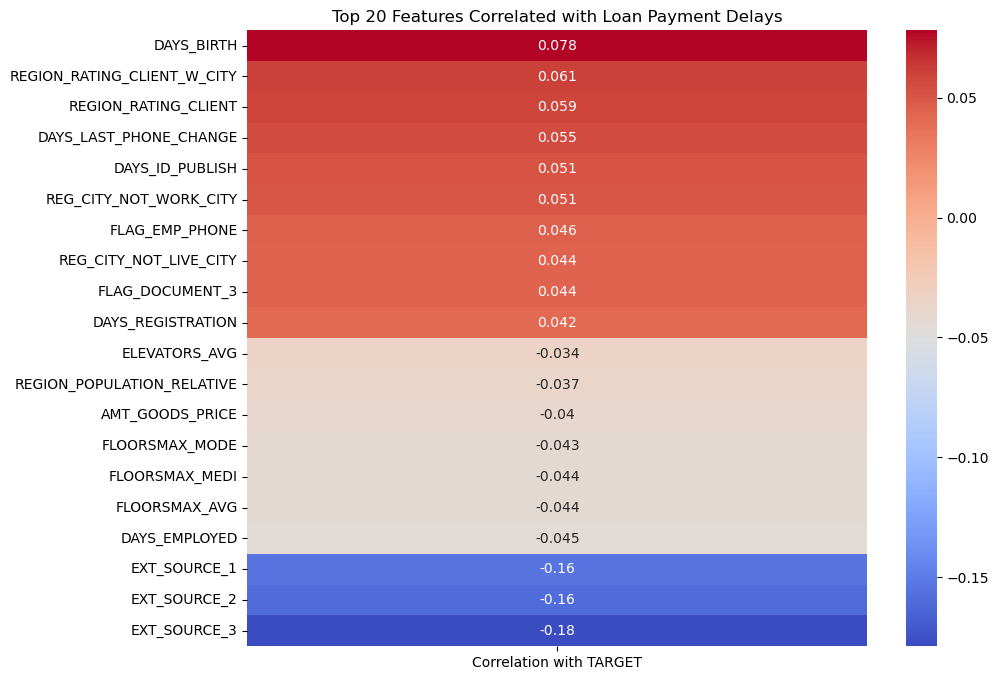

<IPython.core.display.Javascript object>

In [ ]:
top_10_positive = correlation_with_target_sorted.head(10)
top_10_negative = correlation_with_target_sorted.tail(10)
top_20_features = pd.concat([top_10_positive, top_10_negative])

top_20_corr = pd.DataFrame(top_20_features, columns=["Correlation with TARGET"])
plt.figure(figsize=(10, 8))
sns.heatmap(top_20_corr, annot=True, cmap="coolwarm", cbar=True)
plt.title("Top 20 Features Correlated with Loan Payment Delays")
plt.show()

Correlation analysis suggests that features like age, region's rating, last phone call have a slight positive correlation with loan payment delays, meaning they may indicate the risk of delays. In contrast, the external source features which is basically credit scores and days employed show a negative correlation, with higher values in these features associated with a lower likelihood of loan payment delays.

However, it's important to note that many features in the dataset do not follow a normal distribution from what we have observed, which can limit the strength of correlation analysis. Non-normal distributions may mask stronger relationships, making it difficult to capture deeper patterns or correlations between variables.

### AutoML

Our goal is to build a well-performing classification model for identifying risky loans. As a baseline for performance, we will use automatic machine learning (AutoML) tools, focusing solely on the main dataset (application_train) without requiring any additional data aggregation from external sources..

#### Pipeline

In [ ]:
X = application_train.drop(columns="TARGET")
y = application_train["TARGET"]

<IPython.core.display.Javascript object>

In [ ]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

<IPython.core.display.Javascript object>

In [ ]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocess_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

<IPython.core.display.Javascript object>

In [ ]:
X_preprocessed = preprocess_pipeline.fit_transform(X)

<IPython.core.display.Javascript object>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42, stratify=y
)

<IPython.core.display.Javascript object>

To address the imbalance in the target feature, we will apply the SMOTE. This oversampling technique will help the imbalance in the dataset, providing AutoML with a more balanced set of data for training, and ultimately improving the performance of the classification model.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<IPython.core.display.Javascript object>

In [ ]:
automl = AutoML()

settings = {
    "time_budget": 600,
    "metric": "roc_auc",
    "task": "classification",
    "log_file_name": "automl.log",
}

automl.fit(X_train_resampled, y_train_resampled, **settings)

In [ ]:
y_pred_auto = automl.predict(X_test)
y_prob_auto = automl.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

In [ ]:
accuracy_auto = accuracy_score(y_test, y_pred_auto)
f1_auto = f1_score(y_test, y_pred_auto)
precision_auto = precision_score(y_test, y_pred_auto)
recall_auto = recall_score(y_test, y_pred_auto)
roc_auc_auto = roc_auc_score(y_test, y_prob_auto)

print(f"Test Accuracy: {accuracy_auto:.4f}")
print(f"Test F1 Score: {f1_auto:.4f}")
print(f"Test Precision: {precision_auto:.4f}")
print(f"Test Recall: {recall_auto:.4f}")
print(f"Test ROC AUC: {roc_auc_auto:.4f}")

Test Accuracy: 0.9193
Test F1 Score: 0.0609
Test Precision: 0.5000
Test Recall: 0.0324
Test ROC AUC: 0.7524


<IPython.core.display.Javascript object>

In [ ]:
print(classification_report(y_test, y_pred_auto))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.03      0.06      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.51     61503
weighted avg       0.89      0.92      0.89     61503



<IPython.core.display.Javascript object>

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_auto)
conf_matrix

array([[56377,   161],
       [ 4804,   161]], dtype=int64)

<IPython.core.display.Javascript object>

In [ ]:
automl.model.estimator

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.23962094362423958, colsample_bynode=None,
              colsample_bytree=0.6287333861100761, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08518961435699636,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=0.17416125138634553, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=549,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

<IPython.core.display.Javascript object>

With minimal preprocessing—only the necessary steps of missing data imputation, scaling, and encoding to assist the model—we achieved an accuracy of 92%. However, the precision is 50%, and the recall is just 3%, highlighting significant issues with the model’s ability to correctly identify the minority class (loan payment delays). Given the imbalanced nature of the dataset, key indicators for model evaluation will be the F1 score and the ROC-AUC metric, as they are better suited for imbalanced datasets.

Our primary goal moving forward is to improve the recall score, as it is currently close to 0, with the expectation that improving recall will also lead to an improved F1 score and ROC-AUC.

### Preparing the data: cleaning and preprocessing according to the findings from EDA

In [ ]:
exclude_columns = [
    "TARGET",
    "SK_ID_CURR",
    "SK_ID_PREV",
    "SK_ID_BUREAU",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_21",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_5",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_EMAIL",
    "FLAG_WORK_PHONE",
    "FLAG_PHONE",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "NAME_CONTRACT_STATUS",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "ORGANIZATION_TYPE",
    "WALLSMATERIAL_MODE",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WEEKDAY_APPR_PROCESS_START",
    "CODE_GENDER",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "CNT_CHILDREN",
    "CNT_FAM_MEMBERS",
]

<IPython.core.display.Javascript object>

In [ ]:
application_train_cleaned = clean_application_train(application_train)
previous_application_cleaned = clean_previous_application(previous_application)
installments_payments_cleaned = clean_installments_payments(installments_payments)
merged_bureau_data = merge_bureau_and_balance(bureau, bureau_balance)

Log-transformed features: ['AMT_CREDIT_SUM_OVERDUE', 'AMT_CREDIT_SUM', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_DEBT', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_LIMIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE']


<IPython.core.display.Javascript object>

In [ ]:
merged_data = merge_datasets(
    application_train_cleaned,
    previous_application_cleaned,
    installments_payments_cleaned,
    credit_card_balance,
    pos_cash_balance,
    merged_bureau_data,
)

<IPython.core.display.Javascript object>

In [ ]:
merged_data = feature_engineering(merged_data)
merged_data = find_and_transform_skewed_features(
    merged_data, exclude_columns=exclude_columns
)

Log-transformed features: ['AMT_INCOME_TOTAL', 'INCOME_PER_FAM_MEMBER', 'AMT_REQ_CREDIT_BUREAU_QRT', 'CREDIT_SK_DPD_DEF_MEAN', 'POS_SK_DPD_DEF_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'BUREAU_AMT_CREDIT_SUM_OVERDUE', 'BUREAU_CREDIT_DAY_OVERDUE', 'POS_SK_DPD_MEAN', 'INST_AMT_INSTALMENT_MEAN', 'BUREAU_CREDIT_CURRENCY', 'NONLIVINGAPARTMENTS_MODE', 'INST_AMT_PAYMENT_MEAN', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 'CREDIT_CNT_DRAWINGS_OTHER_CURRENT_MEAN', 'CREDIT_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'CREDIT_SK_DPD_MEAN', 'CREDIT_PREV_LOANS_COUNT', 'CREDIT_AMT_DRAWINGS_POS_CURRENT_MEAN', 'CREDIT_AMT_PAYMENT_TOTAL_CURRENT_MEAN', 'BUREAU_AMT_CREDIT_SUM_LIMIT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'BUREAU_AMT_CREDIT_SUM_DEBT', 'CREDIT_AMT_DRAWINGS_ATM_CURRENT_MEAN', 'AMT_REQ_CREDIT_BUREAU_MON', 'CREDIT_AMT_DRAWINGS_CURRENT_MEAN', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI', 'CREDIT_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CREDIT_CNT_DRAWINGS_CURRENT_MEAN

<IPython.core.display.Javascript object>

In [ ]:
merged_data_report = sv.analyze(merged_data, target_feat="TARGET")
merged_data_report.show_html("merged_data_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report merged_data_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<IPython.core.display.Javascript object>

In [ ]:
X = merged_data.drop(columns=["TARGET"])
y = merged_data["TARGET"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

<IPython.core.display.Javascript object>

In [ ]:
sk_id_curr_train = X_train["SK_ID_CURR"]
sk_id_curr_valid = X_valid["SK_ID_CURR"]
sk_id_curr_test = X_test["SK_ID_CURR"]

X_train = X_train.drop(columns=["SK_ID_CURR"])
X_valid = X_valid.drop(columns=["SK_ID_CURR"])
X_test = X_test.drop(columns=["SK_ID_CURR"])

<IPython.core.display.Javascript object>

In [ ]:
preprocessor = preprocessing_pipeline(X_train)

X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

<IPython.core.display.Javascript object>

Our goal is to identify the best machine learning model for predicting loan payment delays by evaluating three of the most popular algorithms: Random Forest Classifier, LightGBM Classifier, and XGBoost Classifier. These algorithms were among the top performers in our AutoML process, demonstrating strong predictive power. Additionally, we will use Optuna for hyperparameter optimization to fine-tune each model and further improve performance.

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "LightGBM", "XGBoost"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 190, 250)
        max_depth = trial.suggest_int("max_depth", 10, 30, log=True)
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
        )

    elif classifier_name == "LightGBM":
        n_estimators = trial.suggest_int("n_estimators", 190, 250)
        learning_rate = trial.suggest_float("learning_rate", 0.02, 0.6)
        max_depth = trial.suggest_int("max_depth", 10, 30, log=True)
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
        )

    else:
        n_estimators = trial.suggest_int("n_estimators", 190, 250)
        learning_rate = trial.suggest_float("learning_rate", 0.02, 0.6)
        max_depth = trial.suggest_int("max_depth", 10, 30, log=True)
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
        )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train_processed, y_train):
        X_train_cv, X_val_cv = X_train_processed[train_idx], X_train_processed[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_cv, y_train_cv)
        preds = model.predict_proba(X_val_cv)[:, 1]
        roc_auc = roc_auc_score(y_val_cv, preds)

        scores.append(roc_auc)

    return np.mean(scores)

<IPython.core.display.Javascript object>

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
dask_optuna = DaskStorage(client=client)

<IPython.core.display.Javascript object>

In [ ]:
study = optuna.create_study(
    study_name="dask_ml",
    storage=dask_optuna,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    load_if_exists=True
)

study.optimize(objective, n_trials=20)

In [ ]:
best_trial = study.best_trial
best_params = best_trial.params

print("Best parameters:", best_params)

Best parameters: {'classifier': 'LightGBM', 'n_estimators': 225, 'learning_rate': 0.045322325591845625, 'max_depth': 15, 'class_weight': 'balanced'}


<IPython.core.display.Javascript object>

In [ ]:
def train_best_model(best_params, X, y):
    classifier_name = best_params["classifier"]

    if classifier_name == "RandomForest":
        model = RandomForestClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            class_weight=best_params["class_weight"],
            random_state=42,
        )

    elif classifier_name == "LightGBM":
        model = LGBMClassifier(
            n_estimators=best_params["n_estimators"],
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            class_weight=best_params["class_weight"],
            random_state=42,
        )

    elif classifier_name == "XGBoost":
        model = XGBClassifier(
            n_estimators=best_params["n_estimators"],
            learning_rate=best_params["learning_rate"],
            max_depth=best_params["max_depth"],
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
        )

    model.fit(X, y)

    return model


best_model_ml = train_best_model(best_params, X_train_processed, y_train)

[LightGBM] [Info] Number of positive: 17377, number of negative: 197877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25295
[LightGBM] [Info] Number of data points in the train set: 215254, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


<IPython.core.display.Javascript object>

In [ ]:
test_preds = best_model_ml.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, test_preds)
print("Test ROC AUC:", roc_auc)
print("Classification Report:\n", classification_report(y_test, test_preds > 0.5))

Test ROC AUC: 0.7809697487863435
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.73      0.83     42403
           1       0.18      0.70      0.29      3724

    accuracy                           0.72     46127
   macro avg       0.57      0.71      0.56     46127
weighted avg       0.90      0.72      0.78     46127



<IPython.core.display.Javascript object>

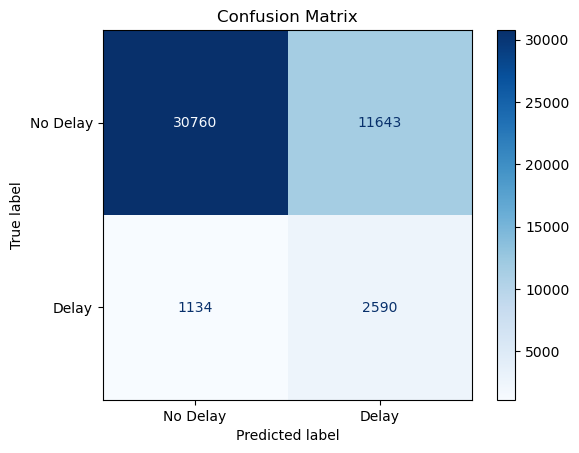

<IPython.core.display.Javascript object>

In [ ]:
y_pred = best_model_ml.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Delay", "Delay"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

After performing hyperparameter optimization with three classifiers (RandomForest, LightGBM, and XGBoost), the best model selected was the LightGBM classifier with the these parameters: n_estimators: 225, learning_rate: 0.045, max_depth: 15, class_weight: 'balanced'.

ROC AUC score of 0.781 indicates a reasonably good model.

From classification report we can see that payment delays group precision is only 18%. Here model is not the best to predict payment delays accurately, tho it identifies 70% of actual payment delays but at the cost of a lot of false positives.
F1 score is 0.29. Overall model accuracy is 72%. We can see in the confusion matrix actual cases how model predicted one group or another when was given an unseen test data.

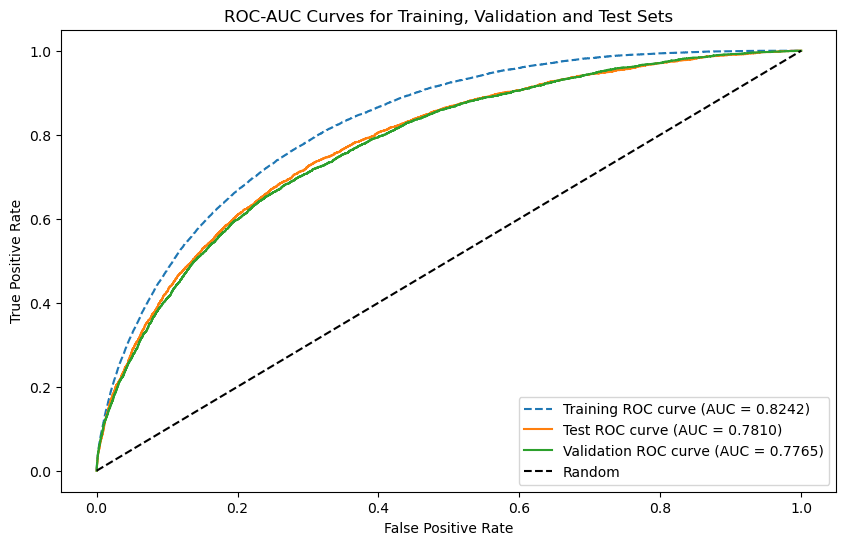

<IPython.core.display.Javascript object>

In [ ]:
train_preds = best_model_ml.predict_proba(X_train_processed)[:, 1]
roc_auc_train = roc_auc_score(y_train, train_preds)
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)

fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)

valid_preds = best_model_ml.predict_proba(X_valid_processed)[:, 1]
roc_auc_valid = roc_auc_score(y_valid, valid_preds)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(
    fpr_train,
    tpr_train,
    label=f"Training ROC curve (AUC = {roc_auc_train:.4f})",
    linestyle="--",
)
plt.plot(
    fpr_test, tpr_test, label=f"Test ROC curve (AUC = {roc_auc:.4f})", linestyle="-"
)
plt.plot(
    fpr_valid,
    tpr_valid,
    label=f"Validation ROC curve (AUC = {roc_auc_valid:.4f})",
    linestyle="-",
)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves for Training, Validation and Test Sets")
plt.legend(loc="lower right")
plt.show()

The model shows good consistency between training, validation, and test AUC scores. The slight drop from training to validation and test AUC suggests the model generalizes well but there is some space for improvements here as well.

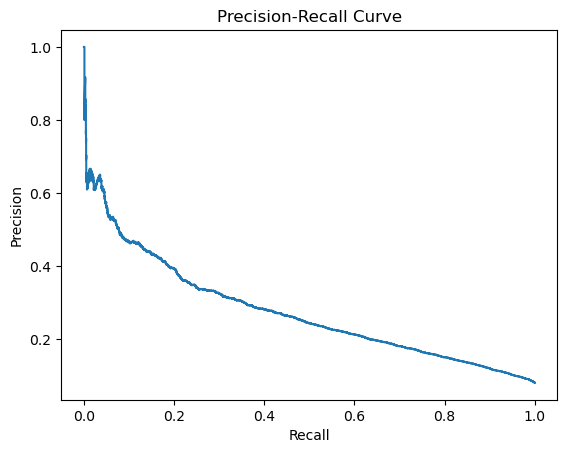

<IPython.core.display.Javascript object>

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, test_preds)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

Precision-recall curve starts with high precision but very low recall, so the model initially starts very cautious, only making positive predictions when it is highly confident, resulting in fewer false positives but also missing many true positive cases. This is an issue of imbalanced classification and this can also benefit from some improvement when it come to the classes imbalances methods, maybe SMOTE method could be combined with class weights or other.

Let's see if the model even with these moderate results is not overfitting:

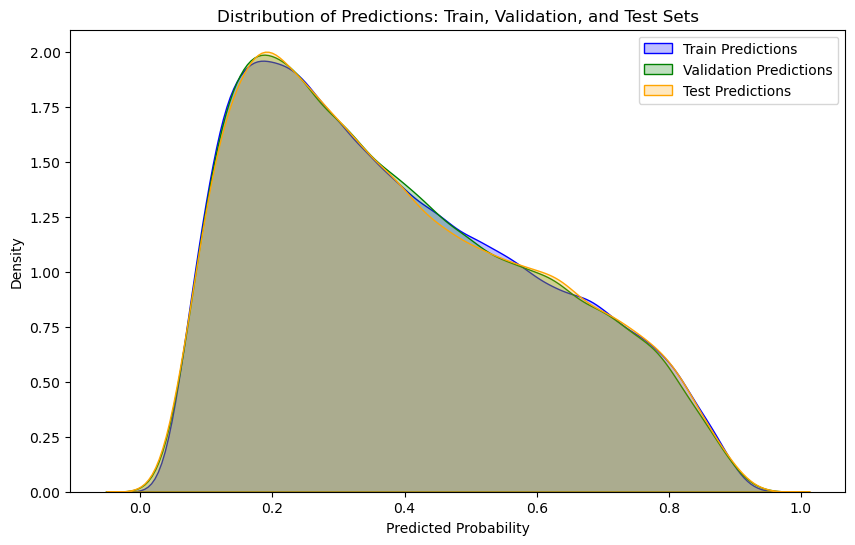

<IPython.core.display.Javascript object>

In [ ]:
train_preds = best_model_ml.predict_proba(X_train_processed)[:, 1].flatten()
valid_preds = best_model_ml.predict_proba(X_valid_processed)[:, 1].flatten()
test_preds = best_model_ml.predict_proba(X_test_processed)[:, 1].flatten()

plt.figure(figsize=(10, 6))
sns.kdeplot(train_preds, label="Train Predictions", shade=True, color="blue")
sns.kdeplot(valid_preds, label="Validation Predictions", shade=True, color="green")
sns.kdeplot(test_preds, label="Test Predictions", shade=True, color="orange")

plt.title("Distribution of Predictions: Train, Validation, and Test Sets")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

The distribution plots of predicted probabilities from the training, validation, and test sets show visible overlap, which suggests that the model does generalize well. Similar distributions indicate that model is predicting without significant overfitting or underfitting, which is a good result.

Now we will try to optimize the decision threshold used to classify no-payment delay and delay cases which will help to improve the balance between precision and recall. The goal is to find a threshold that optimizes f1 score.

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []
for threshold in thresholds:
    y_pred_thresh = (test_preds >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.66


<IPython.core.display.Javascript object>

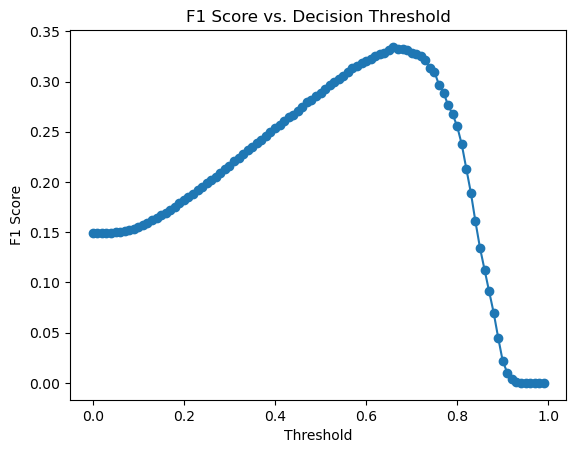

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(thresholds, f1_scores, marker="o")
plt.title("F1 Score vs. Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
print("Classification Report:\n", classification_report(y_test, test_preds > 0.66))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.92     42403
           1       0.26      0.47      0.33      3724

    accuracy                           0.85     46127
   macro avg       0.61      0.67      0.63     46127
weighted avg       0.89      0.85      0.87     46127



<IPython.core.display.Javascript object>

We find that the optimal threshold of 0.66 improved the balance between precision and recall. The initial model (0.5 threshold) had a relatively low recall and precision for loans with payment delays group, but after threshold optimization f1 score increased from 18% to 26%. F1 score increased to 0.33, which is a better balance between precision and recall than the initial model. The overall accuracy improved to 85% from 72%

This threshold provides the best scenario for this LGBM classification model, it allows fewer false positives, meaning fewer unnecessary evaluations of loan applications. By reducing recall, we minimize the risk of mistakenly approving risky loans. However, now some high-risk applications may go undetected.

In [ ]:
model_filename = "best_model_lgbm.pkl"
joblib.dump(best_model_ml, model_filename)

preprocessor_filename = "preprocessor_lgbm.pkl"
joblib.dump(preprocessor, preprocessor_filename)

['preprocessor_lgbm.pkl']

<IPython.core.display.Javascript object>

### Feature importance: SHAP and Permutation Importance

In [ ]:
X_valid_processed_named = pd.DataFrame(X_valid_processed, columns=feature_names_after_preprocessing)

<IPython.core.display.Javascript object>

In [ ]:
explainer = shap.TreeExplainer(best_model_ml)
shap_values = explainer.shap_values(X_valid_processed_named)

<IPython.core.display.Javascript object>

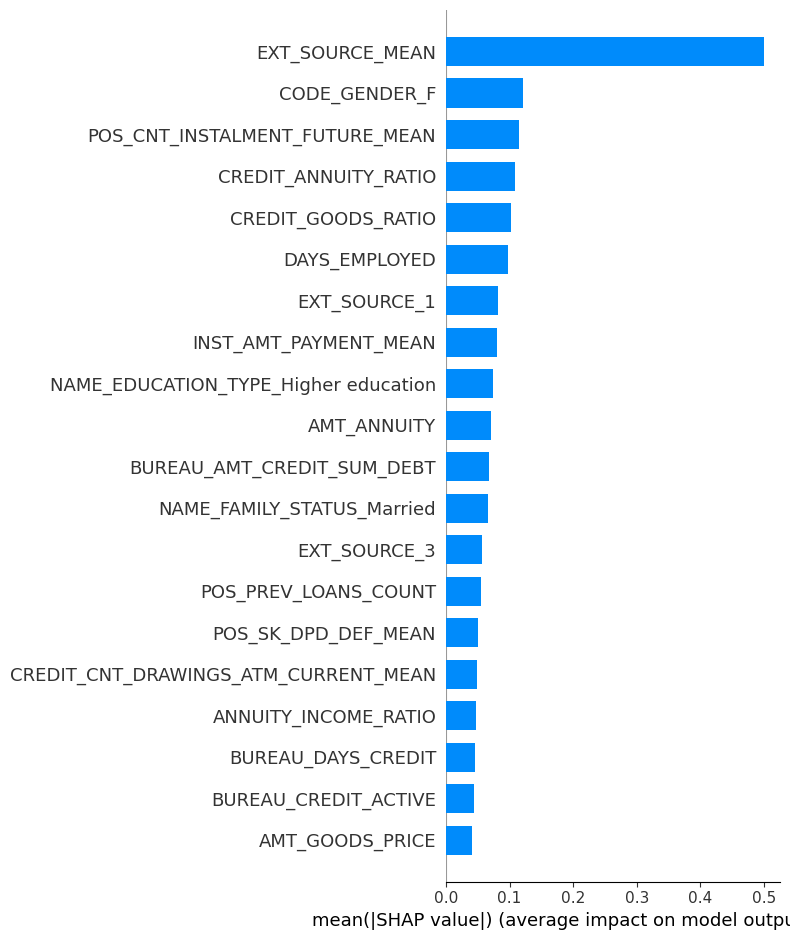

<IPython.core.display.Javascript object>

In [ ]:
shap.summary_plot(shap_values, X_valid_processed_named, plot_type="bar")

SHAP analysis shows that the model's decision-making is strongly influenced by credit scores mean (EXT_SOURCE_MEAN). Features reflecting credit and payment behavior (such as POS_CNT_INSTALMENT_FUTURE_MEAN and CREDIT_ANNUITY_RATIO) are also important drivers, suggesting that applicants with higher future installment counts and annuity-to-credit ratio are more likely to delay their loan payments.

Additionally, demographic factors such as gender (CODE_GENDER_F) contribute to the model’s predictions, with female applicants showing distinct patterns in loan outcomes. However, it is crucial to interpret the influence of gender with caution, as there is a significant imbalance in the dataset—more female applicants than male—which could skew the model’s interpretation. This imbalance may lead the model to overemphasize gender as a predictor, making it important to approach these results carefully to avoid biased conclusions.

In [ ]:
perm_importance = permutation_importance(best_model_ml, X_valid_processed_named, y_valid, n_repeats=5, random_state=42)

<IPython.core.display.Javascript object>

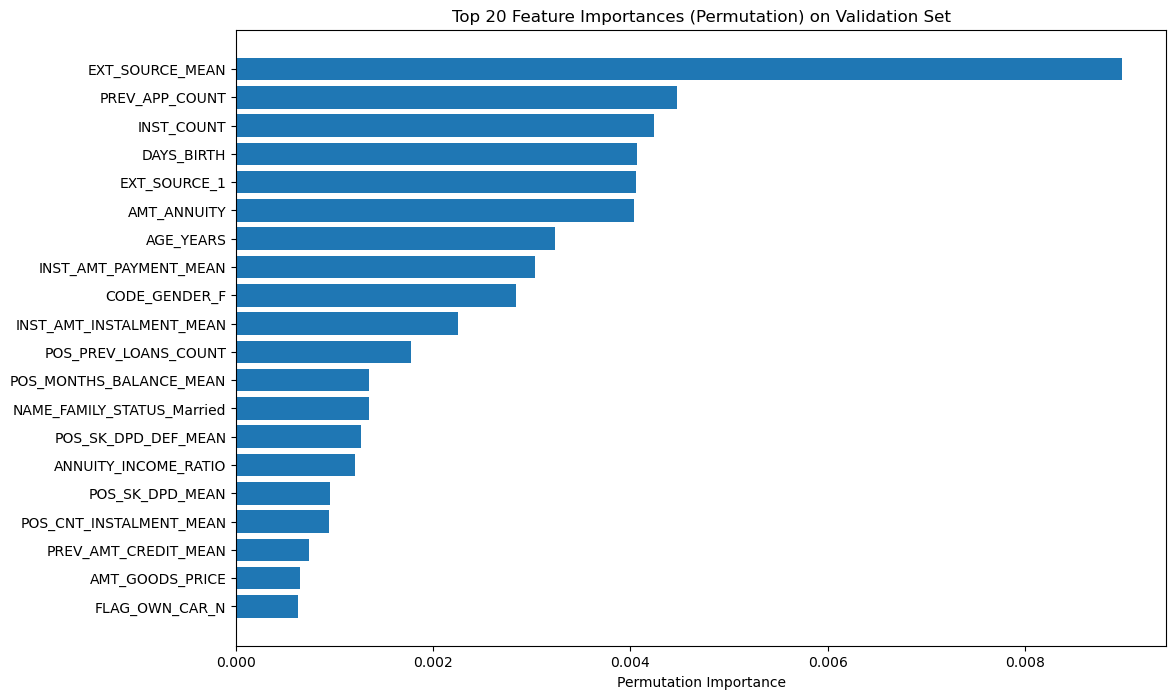

<IPython.core.display.Javascript object>

In [ ]:
top_n = 20

sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]

plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_names_after_preprocessing)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_n} Feature Importances (Permutation) on Validation Set")
plt.show()

The permutation importance plot highlights the top 20 features contributing to model predictions. EXT_SOURCE_MEAN is the most impactful. Other significant features include the previous application count (PREV_APP_COUNT) and installment count (INST_COUNT), which suggests that a borrower’s history with prior loans and the number of installments play an essential role in predicting the risk. Age-related features like DAYS_BIRTH and AGE_YEARS also contribute, likely capturing the impact of borrower's maturity.

In [ ]:
#loaded_model = joblib.load("best_model_lgbm.pkl")
#loaded_preprocessor = joblib.load("preprocessor_lgbm.pkl")

<IPython.core.display.Javascript object>

## Dimensionality reduction using PCA

Given the high dimensionality of our data feature set, we will apply principal component analysis (PCA) to reduce the number of features while retaining 90% of the data variance. This potentially can improve model performance.

In [ ]:
pca = PCA()
pca.fit(X_train_processed)

PCA()

<IPython.core.display.Javascript object>

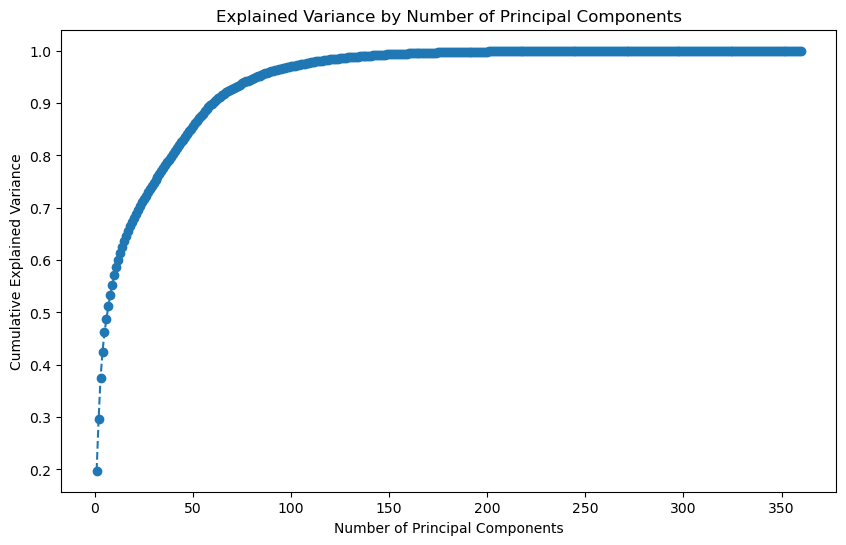

<IPython.core.display.Javascript object>

In [ ]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Explained Variance by Number of Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [ ]:
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1

print(f"Components needed to cover 90% of variance: {n_components_90}")

Components needed to cover 90% of variance: 61


<IPython.core.display.Javascript object>

In [ ]:
optimal_n_components = 61

pca = PCA(n_components=optimal_n_components)
X_train_pca = pca.fit_transform(X_train_processed)
X_valid_pca = pca.transform(X_valid_processed)
X_test_pca = pca.transform(X_test_processed)

<IPython.core.display.Javascript object>

In [ ]:
def objective(trial):
    classifier_name = trial.suggest_categorical(
        "classifier", ["RandomForest", "LightGBM", "XGBoost"]
    )

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
        )
    elif classifier_name == "LightGBM":
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42,
        )
    else: # XGBoost
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
        )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train_pca, y_train):
        X_train_cv, X_val_cv = X_train_pca[train_idx], X_train_pca[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_cv, y_train_cv)
        preds = model.predict_proba(X_val_cv)[:, 1]
        roc_auc = roc_auc_score(y_val_cv, preds)

        scores.append(roc_auc)

    return np.mean(scores)

<IPython.core.display.Javascript object>

In [ ]:
study = optuna.create_study(
    study_name="dask_ml",
    storage=dask_optuna,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    load_if_exists=True
)

[I 2024-09-05 12:13:04,118] A new study created in memory with name: dask_ml


<IPython.core.display.Javascript object>

In [ ]:
study.optimize(objective, n_trials=15)

In [ ]:
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")

Best trial: 0.7428069728605425
Best hyperparameters: {'classifier': 'XGBoost', 'n_estimators': 221, 'learning_rate': 0.09459456096548267, 'max_depth': 4}


<IPython.core.display.Javascript object>

In [ ]:
LGBM_model = LGBMClassifier(
    n_estimators=201,
    learning_rate=0.07924616093169401,
    max_depth=24,
    class_weight="balanced",
    random_state=42,
)

<IPython.core.display.Javascript object>

In [ ]:
XGB_model = XGBClassifier(
            n_estimators=221,
            learning_rate=0.09459456096548267,
            max_depth=4,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train) #ratio of group 0 and 1
        )

XGB_model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.09459456096548267, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=221, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

<IPython.core.display.Javascript object>

In [ ]:
test_preds = XGB_model.predict_proba(X_test_pca)[:, 1]
roc_auc = roc_auc_score(y_test, test_preds)
print("Test ROC AUC:", roc_auc)
print("Classification Report:\n", classification_report(y_test, test_preds > 0.5))

Test ROC AUC: 0.7492703666899517
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82     42403
           1       0.17      0.66      0.27      3724

    accuracy                           0.71     46127
   macro avg       0.56      0.69      0.54     46127
weighted avg       0.90      0.71      0.77     46127



<IPython.core.display.Javascript object>

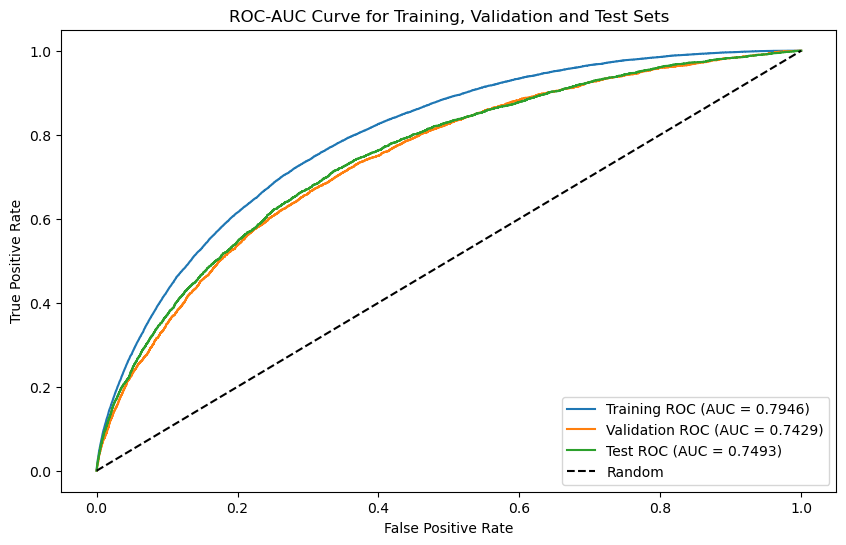

<IPython.core.display.Javascript object>

In [ ]:
train_preds = XGB_model.predict_proba(X_train_pca)[:, 1]
roc_auc_train = roc_auc_score(y_train, train_preds)
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)

val_preds = XGB_model.predict_proba(X_valid_pca)[:, 1]
roc_auc_valid = roc_auc_score(y_valid, val_preds)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, val_preds)

fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Training ROC (AUC = {roc_auc_train:.4f})")
plt.plot(fpr_valid, tpr_valid, label=f"Validation ROC (AUC = {roc_auc_valid:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Training, Validation and Test Sets")
plt.legend(loc="lower right")
plt.show()

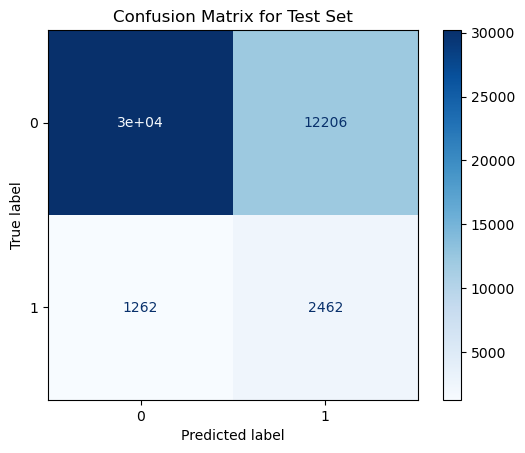

<IPython.core.display.Javascript object>

In [ ]:
test_preds_class = (test_preds >= 0.5).astype(int)

cm_test = confusion_matrix(y_test, test_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Set")
plt.show()

The Test ROC AUC score of 0.7493 indicates that the model does maintains decent performance when it comes to distinguishing between loan applicants with and without payment delays, but it is slightly lower compared to the original model without PCA applied.

### Feature selections based on feature importance

For feature selection we will employ feature importance, this might improve the model as it will reduce the noisy and irrelavant data. We will do this for the best so far working LGBM model.

In [ ]:
lgbm_model = joblib.load("best_model_lgbm.pkl")
loaded_preprocessor = joblib.load("preprocessor_lgbm.pkl")

<IPython.core.display.Javascript object>

In [ ]:
importances = lgbm_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_processed.shape[1]):
    print(f"{f + 1}. feature {f} (Importance: {importances[indices[f]]})")

Feature ranking:
1. feature 0 (Importance: 444)
2. feature 1 (Importance: 224)
3. feature 2 (Importance: 217)
4. feature 3 (Importance: 189)
5. feature 4 (Importance: 172)
6. feature 5 (Importance: 169)
7. feature 6 (Importance: 165)
8. feature 7 (Importance: 156)
9. feature 8 (Importance: 155)
10. feature 9 (Importance: 141)
11. feature 10 (Importance: 138)
12. feature 11 (Importance: 127)
13. feature 12 (Importance: 121)
14. feature 13 (Importance: 119)
15. feature 14 (Importance: 113)
16. feature 15 (Importance: 110)
17. feature 16 (Importance: 106)
18. feature 17 (Importance: 106)
19. feature 18 (Importance: 104)
20. feature 19 (Importance: 98)
21. feature 20 (Importance: 97)
22. feature 21 (Importance: 94)
23. feature 22 (Importance: 94)
24. feature 23 (Importance: 94)
25. feature 24 (Importance: 92)
26. feature 25 (Importance: 91)
27. feature 26 (Importance: 90)
28. feature 27 (Importance: 86)
29. feature 28 (Importance: 82)
30. feature 29 (Importance: 81)
31. feature 30 (Importa

<IPython.core.display.Javascript object>

In [ ]:
selected_indices = [i for i in indices if importances[i] > 50]

<IPython.core.display.Javascript object>

We are selecting features that have 50 or more importance score

In [ ]:
X_train_selected = X_train_processed[:, selected_indices]
X_valid_selected = X_valid_processed[:, selected_indices]
X_test_selected = X_test_processed[:, selected_indices]

<IPython.core.display.Javascript object>

In [ ]:
lgbm_model.fit(X_train_selected, y_train)

[LightGBM] [Info] Number of positive: 17377, number of negative: 197877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8603
[LightGBM] [Info] Number of data points in the train set: 215254, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.045322325591845625,
               max_depth=15, n_estimators=225, random_state=42)

<IPython.core.display.Javascript object>

In [ ]:
test_probs_selected = lgbm_model.predict_proba(X_test_selected)[:, 1]

<IPython.core.display.Javascript object>

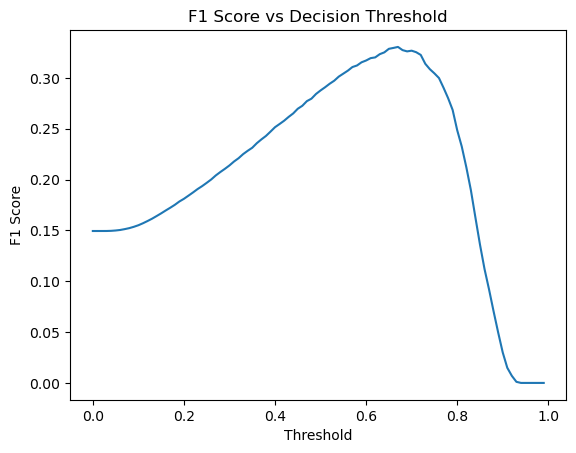

Decision threshold:  0.67


<IPython.core.display.Javascript object>

In [ ]:
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = [f1_score(y_test, test_probs_selected > thresh) for thresh in thresholds]

plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Decision Threshold")
plt.show()

optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Decision threshold: ", optimal_threshold)

In [ ]:
y_pred_selected = (test_probs_selected >= 0.67).astype(int)

print(
    "Classification Report with Selected Features:\n",
    classification_report(y_test, y_pred_selected),
)

Classification Report with Selected Features:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92     42403
           1       0.26      0.44      0.33      3724

    accuracy                           0.85     46127
   macro avg       0.61      0.67      0.62     46127
weighted avg       0.89      0.85      0.87     46127



<IPython.core.display.Javascript object>

We did not improve the model however it was able to handle feature selection/reduction without sacrificing performance, which is beneficial as it allowed to simplify the model.

## Deep learning model experiment

After experimenting with machine learning models like Random Forest, LightGBM, and XGBoost, we decided to try a deep learning approach using a Multilayer Perceptron (MLP) model. As previously we will use optune for hyperparameters optimization and with optimize according to the f1 score the decision threshold.

In [ ]:
y_train_np = y_train.to_numpy()

<IPython.core.display.Javascript object>

In [ ]:
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train_np), y=y_train_np
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

<IPython.core.display.Javascript object>

In [ ]:
def create_mlp_model(input_dim, n_layers=2, n_units=64, learning_rate=0.001):
    model = tf.keras.Sequential()
    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(n_units, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["AUC"])
    return model

<IPython.core.display.Javascript object>

In [ ]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 32, 256)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_indices, val_indices in kf.split(X_train_processed):
        X_train_fold, X_val_fold = (
            X_train_processed[train_indices],
            X_train_processed[val_indices],
        )
        y_train_fold, y_val_fold = y_train_np[train_indices], y_train_np[val_indices]

        model = create_mlp_model(
            X_train_processed.shape[1], n_layers, n_units, learning_rate
        )

        model.fit(
            X_train_fold,
            y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=10,
            batch_size=32,
            class_weight=class_weights_dict,
            callbacks=[TFKerasPruningCallback(trial, "val_auc")],
            verbose=0,
        )

        val_preds = model.predict(X_val_fold).flatten()
        roc_auc = roc_auc_score(y_val_fold, val_preds)
        roc_auc_scores.append(roc_auc)

    return np.mean(roc_auc_scores)

<IPython.core.display.Javascript object>

In [ ]:
study.optimize(objective, n_trials=25, n_jobs=-1)

In [ ]:
print(f"Best hyperparameters: {study.best_params}")
best_trial = study.best_trial
best_model = create_mlp_model(
    X_train_processed.shape[1],
    best_trial.params["n_layers"],
    best_trial.params["n_units"],
    best_trial.params["learning_rate"],
)
best_model.fit(
    X_train_processed,
    y_train_np,
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict,
    verbose=1,
)
test_preds = best_model.predict(X_test_processed).flatten()
test_roc_auc = roc_auc_score(y_test, test_preds)
print(f"Test ROC AUC Score with best model: {test_roc_auc:.4f}")

Best hyperparameters: {'n_layers': 1, 'n_units': 196, 'learning_rate': 4.078391277117298e-05}
Epoch 1/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6792 - loss: 0.6499
Epoch 2/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.7586 - loss: 0.5865
Epoch 3/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - AUC: 0.7673 - loss: 0.5745
Epoch 4/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - AUC: 0.7722 - loss: 0.5726
Epoch 5/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - AUC: 0.7723 - loss: 0.5728
Epoch 6/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - AUC: 0.7797 - loss: 0.5635
Epoch 7/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - AUC: 0.7809 - loss: 0.5626
Epoch 8/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - AUC: 0.7846 - loss: 0.5562
Epoch 9/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.7881 - loss: 0.5569
Epoch 10/10
6727/6727 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - AUC: 0.7904 - loss: 0.5527
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step
Test ROC AUC Score wit

<IPython.core.display.Javascript object>

In [ ]:
y_test_pred = (test_preds >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, test_preds)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

print(f"Test ROC AUC Score: {roc_auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test ROC AUC Score: 0.7722
Test Precision: 0.1783
Test Recall: 0.6834
Test F1-Score: 0.2828
Test Accuracy: 0.7201


<IPython.core.display.Javascript object>

In [ ]:
mlp_loaded_model = load_model('best_model_mlp.keras') #reloading the model. Model now is called mlp_loaded_model

<IPython.core.display.Javascript object>

In [ ]:
train_preds = mlp_loaded_model.predict(X_train_processed).flatten()
valid_preds = mlp_loaded_model.predict(X_valid_processed).flatten()
test_preds = mlp_loaded_model.predict(X_test_processed).flatten()

train_roc_auc = roc_auc_score(y_train, train_preds)
valid_roc_auc = roc_auc_score(y_valid, valid_preds)
test_roc_auc = roc_auc_score(y_test, test_preds)

print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Valid ROC AUC: {valid_roc_auc:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

6727/6727 ━━━━━━━━━━━━━━━━━━━━ 5s 736us/step
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step
1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 724us/step
Train ROC AUC: 0.7952
Valid ROC AUC: 0.7652
Test ROC AUC: 0.7722


<IPython.core.display.Javascript object>

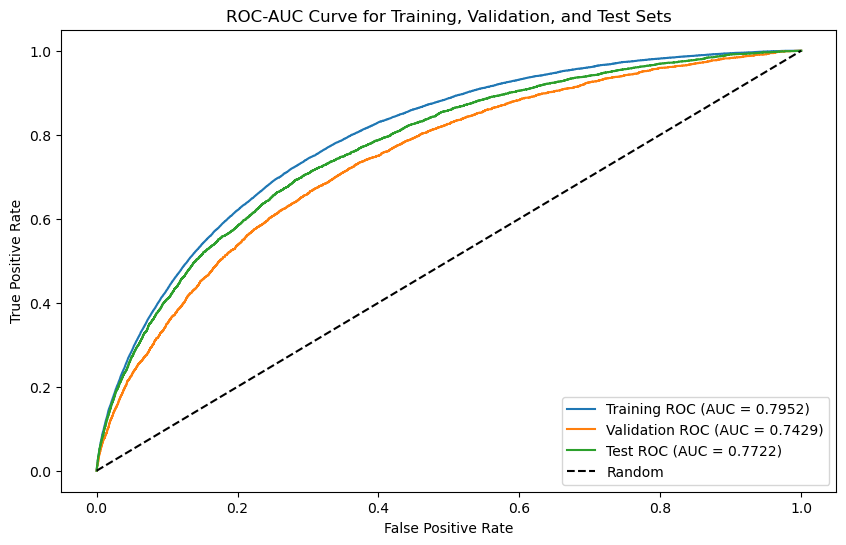

<IPython.core.display.Javascript object>

In [ ]:
roc_auc_train = roc_auc_score(y_train, train_preds)
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds)

roc_auc_valid = roc_auc_score(y_valid, val_preds)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, val_preds)

roc_auc_test = roc_auc_score(y_test, test_preds)
fpr_test, tpr_test, _ = roc_curve(y_test, test_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Training ROC (AUC = {roc_auc_train:.4f})")
plt.plot(fpr_valid, tpr_valid, label=f"Validation ROC (AUC = {roc_auc_valid:.4f})")
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {roc_auc_test:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Training, Validation, and Test Sets")
plt.legend(loc="lower right")
plt.show()

In [ ]:
test_preds_class = (mlp_loaded_model.predict(X_test_processed).flatten() > 0.5).astype(
    int
)
cm_test = confusion_matrix(y_test, test_preds_class)

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<IPython.core.display.Javascript object>

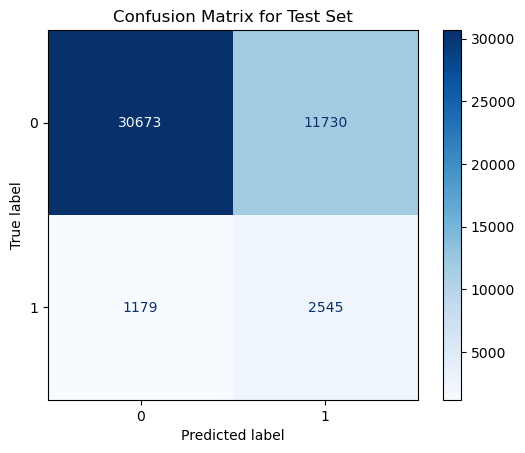

<IPython.core.display.Javascript object>

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Set")
plt.show()

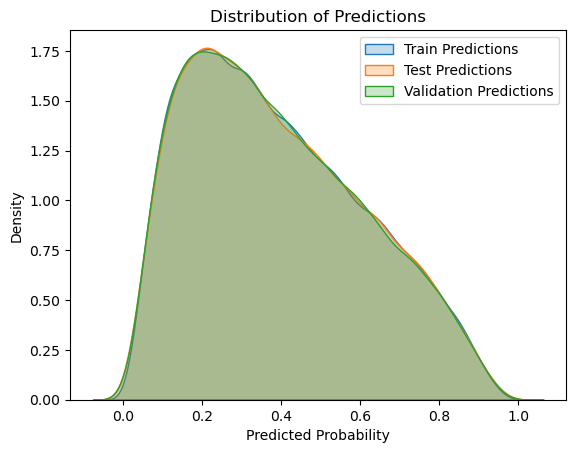

<IPython.core.display.Javascript object>

In [ ]:
sns.kdeplot(train_preds, label="Train Predictions", shade=True)
sns.kdeplot(test_preds, label="Test Predictions", shade=True)
sns.kdeplot(valid_preds, label="Validation Predictions", shade=True)
plt.title("Distribution of Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
test_preds_proba = mlp_loaded_model.predict(X_test_processed).flatten()

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    test_preds_class = (test_preds_proba >= threshold).astype(int)
    f1 = f1_score(y_test, test_preds_class)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step
Best threshold: 0.64
Best F1 Score: 0.32276451727823297


<IPython.core.display.Javascript object>

In [ ]:
final_test_preds_class = (test_preds_proba >= best_threshold).astype(int)

print("Classification Report with Optimized Threshold:\n")
print(classification_report(y_test, final_test_preds_class))

Classification Report with Optimized Threshold:

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     42403
           1       0.24      0.49      0.32      3724

    accuracy                           0.84     46127
   macro avg       0.60      0.68      0.61     46127
weighted avg       0.89      0.84      0.86     46127



<IPython.core.display.Javascript object>

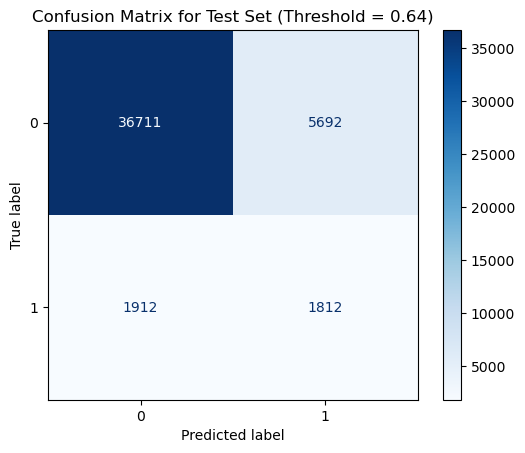

<IPython.core.display.Javascript object>

In [ ]:
final_test_preds_class = (test_preds_proba >= best_threshold).astype(int)

cm_test = confusion_matrix(y_test, final_test_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix for Test Set (Threshold = {best_threshold})")
plt.show()

Unfortunately, we were unable to achieve better results with the MLP model compared to the LGBM model. While the performance is quite similar, the MLP model showed a slightly lower ROC-AUC score, along with a bit worse precision and F1 scores. Finally, we will try to combine both MLP and LGBM models using voting classifier with hopes to get at least few more cases of loan's payment problems right.

### Models ensemble

Finally we will be using a soft voting classifier which can allow us to combine the strengths of both models, combining the decision power of the MLP and LGBM models might help to our goal.

In [ ]:
lgbm_model = joblib.load("best_model_lgbm.pkl")

<IPython.core.display.Javascript object>

In [ ]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        pass

    def predict_proba(self, X):
        positive_class_proba = self.model.predict(X)

        negative_class_proba = 1 - positive_class_proba

        return np.hstack([negative_class_proba, positive_class_proba])

<IPython.core.display.Javascript object>

In [ ]:
mlp_model_wrapper = KerasClassifierWrapper(mlp_loaded_model)

<IPython.core.display.Javascript object>

In [ ]:
voting_clf = VotingClassifier(
    estimators=[('lgbm', lgbm_model), ('mlp', mlp_model_wrapper)],
    voting='soft'
)

voting_clf.fit(X_train_processed, y_train_np)

[LightGBM] [Info] Number of positive: 17377, number of negative: 197877
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25295
[LightGBM] [Info] Number of data points in the train set: 215254, number of used features: 345
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             learning_rate=0.045322325591845625,
                                             max_depth=15, n_estimators=225,
                                             random_state=42)),
                             ('mlp',
                              KerasClassifierWrapper(model=<Sequential name=sequential, built=True>))],
                 voting='soft')

<IPython.core.display.Javascript object>

In [ ]:
train_preds_voting = voting_clf.predict_proba(X_train_processed)[:, 1]
roc_auc_voting_train = roc_auc_score(y_train, train_preds_voting)

print(f"Training ROC AUC Score with Voting Classifier: {roc_auc_voting_train:.4f}")

6727/6727 ━━━━━━━━━━━━━━━━━━━━ 5s 733us/step
Training ROC AUC Score with Voting Classifier: 0.8155


<IPython.core.display.Javascript object>

In [ ]:
valid_preds_voting = voting_clf.predict_proba(X_valid_processed)[:, 1]
roc_auc_voting_valid = roc_auc_score(y_valid, valid_preds_voting)

print(f"Validation ROC AUC Score with Voting Classifier: {roc_auc_voting_valid:.4f}")

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
Validation ROC AUC Score with Voting Classifier: 0.7761


<IPython.core.display.Javascript object>

In [ ]:
test_preds_voting = voting_clf.predict_proba(X_test_processed)[:, 1]
roc_auc_voting = roc_auc_score(y_test, test_preds_voting)

print(f"Test ROC AUC Score with Voting Classifier: {roc_auc_voting:.4f}")

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step
Test ROC AUC Score with Voting Classifier: 0.7820


<IPython.core.display.Javascript object>

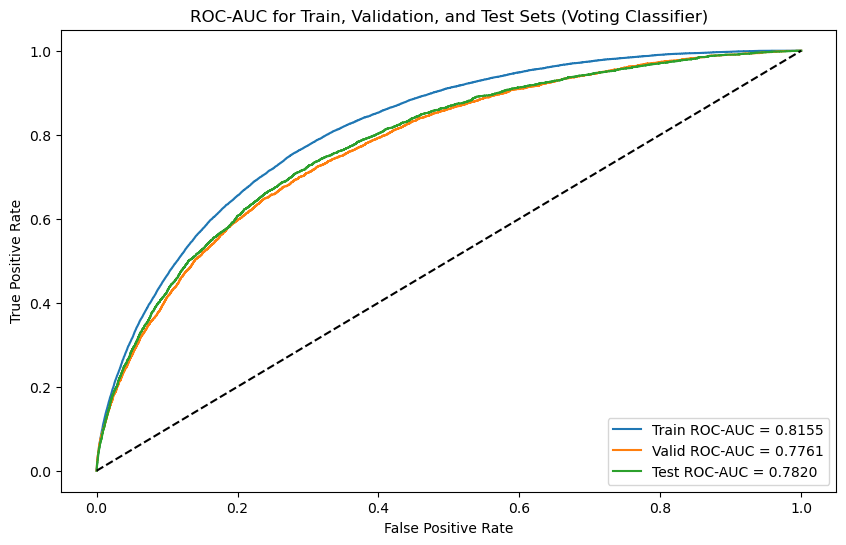

<IPython.core.display.Javascript object>

In [ ]:
fpr_train, tpr_train, _ = roc_curve(y_train, train_preds_voting)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_preds_voting)
fpr_test, tpr_test, _ = roc_curve(y_test, test_preds_voting)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC-AUC = {roc_auc_voting_train:.4f}")
plt.plot(fpr_valid, tpr_valid, label=f"Valid ROC-AUC = {roc_auc_voting_valid:.4f}")
plt.plot(fpr_test, tpr_test, label=f"Test ROC-AUC = {roc_auc_voting:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC for Train, Validation, and Test Sets (Voting Classifier)")
plt.legend(loc="lower right")
plt.show()

The ROC-AUC curves indicates that the model's performance is consistent across all 3 sets, with a Test ROC-AUC of 0.7820, which is a bit better than previous models' results. Combining the models indeed brought slight improvements.

In [ ]:
test_preds_class = (test_preds_voting >= 0.5).astype(int)
print(classification_report(y_test, test_preds_class))

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     42403
           1       0.18      0.69      0.29      3724

    accuracy                           0.73     46127
   macro avg       0.57      0.71      0.56     46127
weighted avg       0.90      0.73      0.79     46127



<IPython.core.display.Javascript object>

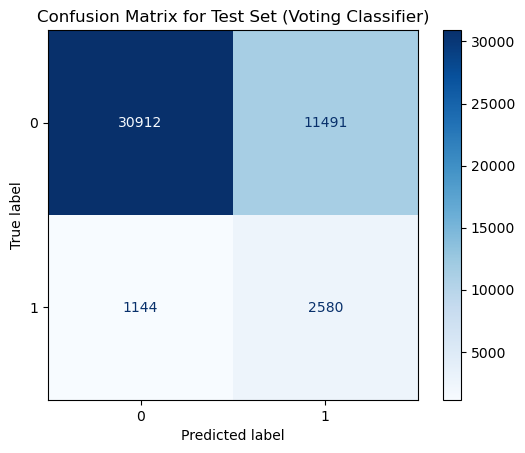

<IPython.core.display.Javascript object>

In [ ]:
cm_test = confusion_matrix(y_test, test_preds_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Test Set (Voting Classifier)")
plt.show()

In [ ]:
test_preds_voting = voting_clf.predict_proba(X_test_processed)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    test_preds_class = (test_preds_voting >= threshold).astype(int)
    f1 = f1_score(y_test, test_preds_class)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"Optimal threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}")

1442/1442 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step
Optimal threshold: 0.64
Best F1 Score: 0.3346


<IPython.core.display.Javascript object>

In [ ]:
test_preds_class = (test_preds_voting >= best_threshold).astype(int)
print(classification_report(y_test, test_preds_class))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     42403
           1       0.25      0.49      0.33      3724

    accuracy                           0.84     46127
   macro avg       0.60      0.68      0.62     46127
weighted avg       0.89      0.84      0.86     46127



<IPython.core.display.Javascript object>

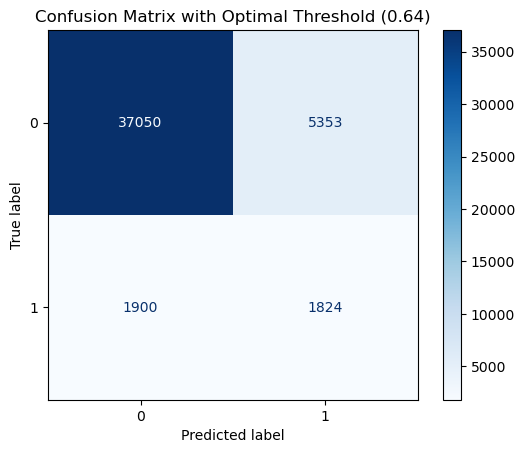

<IPython.core.display.Javascript object>

In [ ]:
cm_test = confusion_matrix(y_test, test_preds_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix with Optimal Threshold ({best_threshold:.2f})")
plt.show()

Finally decision threshold optimization helped to have 25% of precision, 49% recall and f1 score of 33.

In [ ]:
perm_importance = permutation_importance(
    voting_clf, X_valid_processed, y_valid, n_repeats=10, random_state=42
)

In [ ]:
feature_names_after_preprocessing = get_feature_names(
    preprocessor.named_steps["num_cat"],
    numerical_features=numerical_features,
    categorical_features=categorical_features,
)

<IPython.core.display.Javascript object>

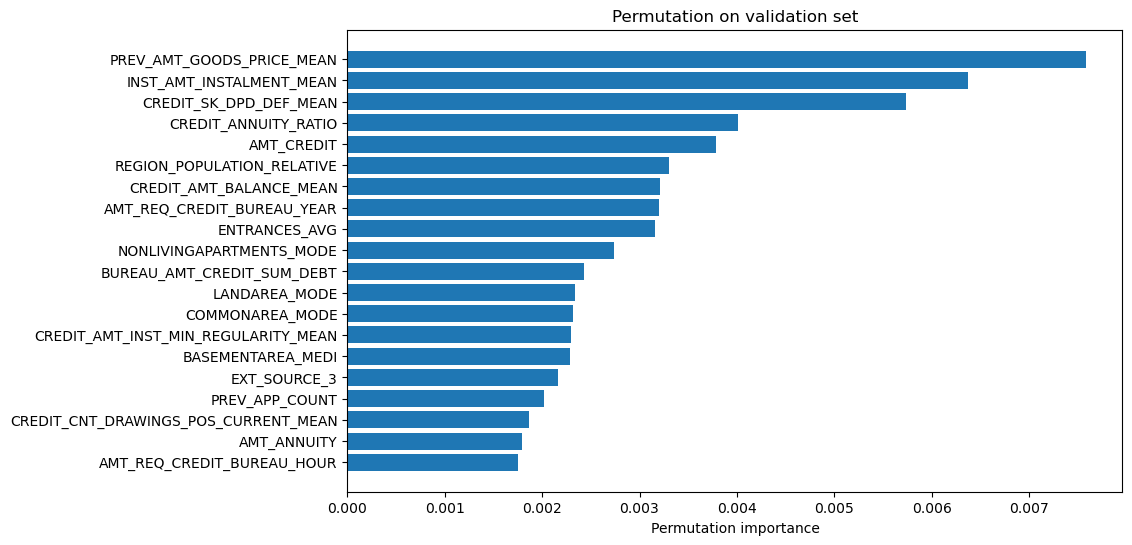

<IPython.core.display.Javascript object>

In [ ]:
top_n = 20

sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]
plt.figure(figsize=(10, 6))
plt.barh(
    np.array(feature_names_after_preprocessing)[sorted_idx],
    perm_importance.importances_mean[sorted_idx],
)
plt.xlabel("Permutation importance")
plt.title("Permutation on validation set")
plt.show()

Financial features like credit amounts, balances, and annuity ratios is all over the list, showing their importance for the model. Housing features also appear, though with less importance compared to financial features. It is interesting to see that results have changed from LGBM model's permuation importance analysis where we had EXT_SOURCE_MEAN and PREV_APP_COUNT as dominant features.

### Findings and conclusions

From the beginning, our goal was to develop the best possible model for classifying potential loan defaulters. We tackled this by focusing on key steps: understanding the dataset through exploratory data analysis (EDA), cleaning and transforming the data, generating new features, and applying a variety of machine learning and trying deep learning model.

From the EDA, we identified several problematic features, including those with missing data, skewed distributions, and incorrect entries. To address these, we implemented cleaning functions and transformed the data accordingly. New features were introduced, such as payment delays, the income-per-family ratio, and credit-to-income ratio, which provided the model with more predictive power. However, feature engineering is one of the key areas that could be further improved. While we explored features like income ratios, family size, and external sources, there is a lot more potential in extracting more meaningful insights from existing data. For instance, aggregation methods such as taking the mode, minimum, or maximum of certain features could provide further insights. Additionally, handling missing data—particularly by using more advanced imputation techniques like KNN imputation—might have yielded even better results.

Despite these opportunities for further improvement, our analysis clearly shows that each step of feature engineering and preprocessing had a positive impact on model performance. For example, external data aggregation, particularly information from the credit bureau, installment payments, and previous loans, played an important role in the model.

Several machine learning models were trained and tuned, including Random Forest, XGBoost, and LightGBM. Among them, the LightGBM model consistently outperformed others, proving to be the most effective in classifying loan defaults. After applying decision threshold optimization, we managed to achieve an F1 score of 0.33, improving our model’s recall and balancing precision. In efforts to further improve results, we applied a MLP model, which is more designed to capture non-linear relationships. However, MLP performed similarly to LightGBM, but it did not outperform the tree-based methods significantly. Finally, we employed an ensemble method, combining LightGBM and MLP using a voting classifier. This strategy slightly improved the ROC-AUC scores on both the validation and test sets.

The most critical features identified through permutation importance were related to payment history, external credit sources, and previous loan applications. Features like INST_AMT_PAYMENT_MEAN and POS_PREV_LOANS_COUNT consistently ranked high in importance, reaffirming that an applicant's historical behavior with previous loans is a strong predictor of their future loan performance. Interestingly, features with missing data, such as EXT_SOURCE_1, still showed up as important in the final models. This highlights a key area for potential improvement—accurately imputing missing data for these features could further boost model performance. For even proper classification we would have to have some external information that could suggest what is the current economical or social situation in the area when the prediction is made as this can have some predicting power to the model as well. So in order to improve our results we need more advanced feature engineering, exploring more complex relationships between features or introducing new external data could unlock even better results. Advanced imputation strategies could help improve model performance, especially for features that had significant amount of missing data but were still important. Aggregating features using multiple statistical methods could provide better insights than just relying on averages.

In conclusion, while the ensemble of LightGBM and MLP was our best-performing classifier, the results show room for improvement.